In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns


Application_train

In [6]:

file_path = "/Users/bella/Downloads/Home credit /home-credit-default-risk/application_train.csv"
df = pd.read_csv(file_path)

print("Shape:", df.shape)
df.head()

# Check column types
df.info()

# Convert days columns to positive integers (absolute value) and optional datetime
days_cols = [col for col in df.columns if "DAYS" in col]
for col in days_cols:
    df[col] = df[col].replace(365243, np.nan)  # special placeholder for missing
    df[col] = df[col].astype("float")

# Example: convert DAYS_BIRTH to years
df["YEARS_BIRTH"] = (-df["DAYS_BIRTH"] / 365).round(1)
# Missing value count
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({"Missing Values": missing, "Percentage": missing_pct})
print(missing_df.head(10))

# Strategy
num_cols = df.select_dtypes(include=["float", "int"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

# Numeric: fill with median
df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.median()))

# Categorical: fill with "Missing"
df[cat_cols] = df[cat_cols].fillna("Missing")

# Example: GENDER column has 'XNA'
if "CODE_GENDER" in df.columns:
    df["CODE_GENDER"] = df["CODE_GENDER"].replace("XNA", "Missing")

# Cap income total at 99th percentile
q99_income = df["AMT_INCOME_TOTAL"].quantile(0.99)
df["AMT_INCOME_TOTAL"] = df["AMT_INCOME_TOTAL"].clip(upper=q99_income)

# Cap annuity at 99th percentile
q99_annuity = df["AMT_ANNUITY"].quantile(0.99)
df["AMT_ANNUITY"] = df["AMT_ANNUITY"].clip(upper=q99_annuity)

# Credit to income ratio
df["CREDIT_TO_INCOME_RATIO"] = df["AMT_CREDIT"] / df["AMT_INCOME_TOTAL"]

# Annuity to income ratio
df["ANNUITY_TO_INCOME_RATIO"] = df["AMT_ANNUITY"] / df["AMT_INCOME_TOTAL"]

# Age group
df["AGE_GROUP"] = pd.cut(df["YEARS_BIRTH"], bins=[20,30,40,50,60,70], labels=["20-30","30-40","40-50","50-60","60-70"])

df_encoded = pd.get_dummies(df, drop_first=True)
print("Encoded shape:", df_encoded.shape)

# Save inside the writable directory
#df_encoded.to_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/application_train_clean.csv", index=False)
#print("Cleaned dataset saved at /Users/bella/Downloads/Home credit /home-credit-default-risk/application_train_clean.csv")



Shape: (307511, 122)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
                          Missing Values  Percentage
COMMONAREA_MEDI                   214865   69.872297
COMMONAREA_AVG                    214865   69.872297
COMMONAREA_MODE                   214865   69.872297
NONLIVINGAPARTMENTS_MEDI          213514   69.432963
NONLIVINGAPARTMENTS_MODE          213514   69.432963
NONLIVINGAPARTMENTS_AVG           213514   69.432963
FONDKAPREMONT_MODE                210295   68.386172
LIVINGAPARTMENTS_AVG              210199   68.354953
LIVINGAPARTMENTS_MODE             210199   68.354953
LIVINGAPARTMENTS_MEDI             210199   68.354953
Encoded shape: (307511, 243)


application_test


In [7]:
file_path = "/Users/bella/Downloads/Home credit /home-credit-default-risk/application_test.csv"
df = pd.read_csv(file_path)
print("Shape:", df.shape)

df.head()

df.info()

# Pick only columns with "DAYS" in the name and numeric dtype
days_cols = [col for col in df.columns if "DAYS" in str(col) and pd.api.types.is_numeric_dtype(df[col])]

for col in days_cols:
    # Convert to float first to ensure replace works
    df[col] = df[col].astype(float)
    df[col] = df[col].replace(365243, np.nan)  # replace special missing code

# Example: convert DAYS_BIRTH to years
if "DAYS_BIRTH" in df.columns:
    df["YEARS_BIRTH"] = (-df["DAYS_BIRTH"] / 365).round(1)
# Step 3 – Handle Missing Values
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({"Missing Values": missing, "Percentage": missing_pct})
print(missing_df.head(10))
num_cols = df.select_dtypes(include=["float", "int"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns
df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.median()))
df[cat_cols] = df[cat_cols].fillna("Missing")

# Step 4 – Fix Categorical Inconsistencies
if "CODE_GENDER" in df.columns:
    df["CODE_GENDER"] = df["CODE_GENDER"].replace("XNA", "Missing")

# Step 5 – Outlier Handling
if "AMT_INCOME_TOTAL" in df.columns:
    q99_income = df["AMT_INCOME_TOTAL"].quantile(0.99)
    df["AMT_INCOME_TOTAL"] = df["AMT_INCOME_TOTAL"].clip(upper=q99_income)

if "AMT_ANNUITY" in df.columns:
    q99_annuity = df["AMT_ANNUITY"].quantile(0.99)
    df["AMT_ANNUITY"] = df["AMT_ANNUITY"].clip(upper=q99_annuity)

# Step 6 – Feature Engineering
if {"AMT_CREDIT", "AMT_INCOME_TOTAL"}.issubset(df.columns):
    df["CREDIT_TO_INCOME_RATIO"] = df["AMT_CREDIT"] / df["AMT_INCOME_TOTAL"]

if {"AMT_ANNUITY", "AMT_INCOME_TOTAL"}.issubset(df.columns):
    df["ANNUITY_TO_INCOME_RATIO"] = df["AMT_ANNUITY"] / df["AMT_INCOME_TOTAL"]

if "YEARS_BIRTH" in df.columns:
    df["AGE_GROUP"] = pd.cut(
        df["YEARS_BIRTH"], 
        bins=[20, 30, 40, 50, 60, 70], 
        labels=["20-30", "30-40", "40-50", "50-60", "60-70"]
    )

# Step 7 – Encoding Categorical Variables
df_encoded = pd.get_dummies(df, drop_first=True)
print("Encoded shape:", df_encoded.shape)

# Save inside the writable directory
#df_encoded.to_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/application_test_clean.csv", index=False)
#print("Cleaned dataset saved at /Users/bella/Downloads/Home credit /home-credit-default-risk/application_test_clean.csv")


Shape: (48744, 121)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
                          Missing Values  Percentage
COMMONAREA_MODE                    33495   68.716150
COMMONAREA_AVG                     33495   68.716150
COMMONAREA_MEDI                    33495   68.716150
NONLIVINGAPARTMENTS_MEDI           33347   68.412523
NONLIVINGAPARTMENTS_MODE           33347   68.412523
NONLIVINGAPARTMENTS_AVG            33347   68.412523
FONDKAPREMONT_MODE                 32797   67.284179
LIVINGAPARTMENTS_MODE              32780   67.249302
LIVINGAPARTMENTS_MEDI              32780   67.249302
LIVINGAPARTMENTS_AVG               32780   67.249302
Encoded shape: (48744, 239)


bureau

In [8]:
# Change the path to your file location
file_path = "/Users/bella/Downloads/Home credit /home-credit-default-risk/bureau.csv"
df = pd.read_csv(file_path)

print("Shape:", df.shape)

df.head()

# Step 2 – Inspect & Correct Data Types
df.info()

# Convert days columns to positive floats
days_cols = [col for col in df.columns if "DAYS" in col]
for col in days_cols:
    df[col] = df[col].replace(365243, pd.NA)  # placeholder for missing
    df[col] = df[col].astype("float")
    
# Step 3 – Handle Missing Values
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({"Missing Values": missing, "Percentage": missing_pct})
print(missing_df.head(10))
num_cols = df.select_dtypes(include=["float", "int"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.median()))
df[cat_cols] = df[cat_cols].fillna("Missing")

# Step 4 – Fix Categorical Inconsistencies
# Example: replace unknown values if any specific columns contain them
for col in cat_cols:
    df[col] = df[col].replace("XNA", "Missing")

# Step 5 – Outlier Handling
if "AMT_CREDIT_SUM" in df.columns:
    q99_credit_sum = df["AMT_CREDIT_SUM"].quantile(0.99)
    df["AMT_CREDIT_SUM"] = df["AMT_CREDIT_SUM"].clip(upper=q99_credit_sum)

if "AMT_CREDIT_SUM_DEBT" in df.columns:
    q99_credit_debt = df["AMT_CREDIT_SUM_DEBT"].quantile(0.99)
    df["AMT_CREDIT_SUM_DEBT"] = df["AMT_CREDIT_SUM_DEBT"].clip(upper=q99_credit_debt)

# Step 6 – Feature Engineering
if {"AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT"}.issubset(df.columns):
    df["DEBT_TO_CREDIT_RATIO"] = df["AMT_CREDIT_SUM_DEBT"] / df["AMT_CREDIT_SUM"]

if {"DAYS_CREDIT", "DAYS_ENDDATE_FACT"}.issubset(df.columns):
    df["CREDIT_DURATION_DAYS"] = df["DAYS_ENDDATE_FACT"] - df["DAYS_CREDIT"]

# Step 7 – Encoding Categorical Variables
df_encoded = pd.get_dummies(df, drop_first=True)
print("Encoded shape:", df_encoded.shape)

# Save inside the writable directory
#df_encoded.to_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/bureau_clean.csv", index=False)
#print("Cleaned dataset saved at /Users/bella/Downloads/Home credit /home-credit-default-risk/bureau_clean.csv")


Shape: (1716428, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB
                        Missing Values  Percentage
AMT_ANNUITY                    1226791   71.4734

previous_application

In [9]:
file_path = "/Users/bella/Downloads/Home credit /home-credit-default-risk/previous_application.csv"
df = pd.read_csv(file_path)

print("Shape:", df.shape)
df.head()


# Step 2 – Inspect & Correct Data Types
df.info()
# Only include numeric columns with "DAYS" in their name
days_cols = [
    col for col in df.columns
    if "DAYS" in col and pd.api.types.is_numeric_dtype(df[col])
]

for col in days_cols:
    df[col] = df[col].astype(float)  # convert to float first
    df[col] = df[col].replace(365243, np.nan)  # replace placeholder with Na
    
# Step 3 – Handle Missing Values
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({"Missing Values": missing, "Percentage": missing_pct})
print(missing_df.head(10))

num_cols = df.select_dtypes(include=["float", "int"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.median()))
df[cat_cols] = df[cat_cols].fillna("Missing")

# Step 4 – Fix Categorical Inconsistencies
for col in cat_cols:
    df[col] = df[col].replace("XNA", "Missing")

# Step 5 – Outlier Handling
if "AMT_APPLICATION" in df.columns:
    q99_app_amt = df["AMT_APPLICATION"].quantile(0.99)
    df["AMT_APPLICATION"] = df["AMT_APPLICATION"].clip(upper=q99_app_amt)

if "AMT_CREDIT" in df.columns:
    q99_credit_amt = df["AMT_CREDIT"].quantile(0.99)
    df["AMT_CREDIT"] = df["AMT_CREDIT"].clip(upper=q99_credit_amt)

# Step 6 – Feature Engineering
if {"AMT_CREDIT", "AMT_APPLICATION"}.issubset(df.columns):
    df["CREDIT_TO_APPLICATION_RATIO"] = df["AMT_CREDIT"] / df["AMT_APPLICATION"]

if {"DAYS_DECISION", "DAYS_FIRST_DUE"}.issubset(df.columns):
    df["DAYS_TO_FIRST_DUE"] = df["DAYS_FIRST_DUE"] - df["DAYS_DECISION"]

# Step 7 – Encoding Categorical Variables
df_encoded = pd.get_dummies(df, drop_first=True)
print("Encoded shape:", df_encoded.shape)

# Save inside the writable directory
#df_encoded.to_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/previous_application_clean.csv", index=False)
#print("Cleaned dataset saved at /Users/bella/Downloads/Home credit /home-credit-default-risk/previous_application_clean.csv")


Shape: (1670214, 37)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT    

POS_CASH balance

In [10]:
# Step 1 – Load from Local
file_path = "/Users/bella/Downloads/Home credit /home-credit-default-risk/POS_CASH_balance.csv"
df = pd.read_csv(file_path)

print("Shape:", df.shape)
df.head()

# Step 2 – Inspect & Correct Data Types
df.info()

# Handle DAYS columns if any
days_cols = [
    col for col in df.columns
    if "DAYS" in col and pd.api.types.is_numeric_dtype(df[col])
]
for col in days_cols:
    df[col] = df[col].astype(float)
    df[col] = df[col].replace(365243, np.nan)


# Step 3 – Handle Missing Values
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({"Missing Values": missing, "Percentage": missing_pct})
print(missing_df.head(10))

num_cols = df.select_dtypes(include=["float", "int"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.median()))
df[cat_cols] = df[cat_cols].fillna("Missing")


# Step 4 – Encoding Categorical Variables
df_encoded = pd.get_dummies(df, drop_first=True)
print("Encoded shape:", df_encoded.shape)


# Step 5 - Save inside the writable directory
#df_encoded.to_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/POS_CASH_balance_clean.csv", index=False)
#print("Cleaned dataset saved at /Users/bella/Downloads/Home credit /home-credit-default-risk/POS_CASH_balance_clean.csv")


Shape: (10001358, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB
                       Missing Values  Percentage
CNT_INSTALMENT_FUTURE           26087    0.260835
CNT_INSTALMENT                  26071    0.260675
SK_ID_PREV                          0    0.000000
SK_ID_CURR                          0    0.000000
MONTHS_BALANCE                      0    0.000000
NAME_CONTRACT_STATUS                0    0.000000
SK_DPD                              0    0.000000
SK_DPD_DEF                          0    

Credit_card_balance

In [11]:
# Step 1 – Load from Local
file_path = "/Users/bella/Downloads/Home credit /home-credit-default-risk/credit_card_balance.csv"
df = pd.read_csv(file_path)

print("Shape:", df.shape)
df.head()


# Step 2 – Inspect & Correct Data Types
df.info()

# Handle DAYS columns if any
days_cols = [
    col for col in df.columns
    if "DAYS" in col and pd.api.types.is_numeric_dtype(df[col])
]
for col in days_cols:
    df[col] = df[col].astype(float)
    df[col] = df[col].replace(365243, np.nan)


# Step 3 – Handle Missing Values
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({"Missing Values": missing, "Percentage": missing_pct})
print(missing_df.head(10))

num_cols = df.select_dtypes(include=["float", "int"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.median()))
df[cat_cols] = df[cat_cols].fillna("Missing")


# Step 4 – Encoding Categorical Variables
df_encoded = pd.get_dummies(df, drop_first=True)
print("Encoded shape:", df_encoded.shape)


# Step 5 - Save inside the writable directory
#df_encoded.to_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/credit_card_balance_clean.csv", index=False)
#print("Cleaned dataset saved at /Users/bella/Downloads/Home credit /home-credit-default-risk/credit_card_balance_clean.csv")


Shape: (3840312, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  

installments_payments

In [12]:
# Step 1 – Load from Local
file_path = "/Users/bella/Downloads/Home credit /home-credit-default-risk/installments_payments.csv"
df = pd.read_csv(file_path)

print("Shape:", df.shape)
df.head()


# Step 2 – Inspect & Correct Data Types
df.info()

# Handle DAYS columns if any
days_cols = [
    col for col in df.columns
    if "DAYS" in col and pd.api.types.is_numeric_dtype(df[col])
]
for col in days_cols:
    df[col] = df[col].astype(float)
    df[col] = df[col].replace(365243, np.nan)


# Step 3 – Handle Missing Values
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({"Missing Values": missing, "Percentage": missing_pct})
print(missing_df.head(10))

num_cols = df.select_dtypes(include=["float", "int"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.median()))
df[cat_cols] = df[cat_cols].fillna("Missing")


# Step 4 – Encoding Categorical Variables
df_encoded = pd.get_dummies(df, drop_first=True)
print("Encoded shape:", df_encoded.shape)

# Step 5 - Save inside the writable directory
#df_encoded.to_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/installments_payments_clean.csv", index=False)
#print("Cleaned dataset saved at /Users/bella/Downloads/Home credit /home-credit-default-risk/installments_payments_clean.csv")

Shape: (13605401, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB
                        Missing Values  Percentage
DAYS_ENTRY_PAYMENT                2905    0.021352
AMT_PAYMENT                       2905    0.021352
SK_ID_PREV                           0    0.000000
SK_ID_CURR                           0    0.000000
NUM_INSTALMENT_VERSION               0    0.000000
NUM_INSTALMENT_NUMBER                0    0.000000
DAYS_INSTALMENT                      0    0.000000
AMT_INSTALMENT                     

bureau_balance

In [13]:
# Step 1 – Load from Local
file_path = "/Users/bella/Downloads/Home credit /home-credit-default-risk/bureau_balance.csv"
df = pd.read_csv(file_path)

print("Shape:", df.shape)
df.head()


# Step 2 – Inspect & Correct Data Types
df.info()


# Step 3 – Handle Missing Values
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({"Missing Values": missing, "Percentage": missing_pct})
print(missing_df.head(10))

num_cols = df.select_dtypes(include=["float", "int"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.median()))
df[cat_cols] = df[cat_cols].fillna("Missing")


# Step 4 – Encoding Categorical Variables
df_encoded = pd.get_dummies(df, drop_first=True)
print("Encoded shape:", df_encoded.shape)


# Step 5 - Save inside the writable directory
#df_encoded.to_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/bureau_balance_clean.csv", index=False)
#print("Cleaned dataset saved at /Users/bella/Downloads/Home credit /home-credit-default-risk/bureau_balance_clean.csv")


Shape: (27299925, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB
                Missing Values  Percentage
SK_ID_BUREAU                 0         0.0
MONTHS_BALANCE               0         0.0
STATUS                       0         0.0
Encoded shape: (27299925, 9)


EDA

In [14]:

# Set display & style
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# Load main training data
app_train = pd.read_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/application_train_clean.csv")

print("Shape:", app_train.shape)
app_train.head()


Shape: (307511, 243)


SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0      100002       1             0          202500.0    406597.5   
1      100003       0             0          270000.0   1293502.5   
2      100004       0             0           67500.0    135000.0   
3      100006       0             0          135000.0    312682.5   
4      100007       0             0          121500.0    513000.0   

   AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0      24700.5         351000.0                    0.018801     -9461.0   
1      35698.5        1129500.0                    0.003541    -16765.0   
2       6750.0         135000.0                    0.010032    -19046.0   
3      29686.5         297000.0                    0.008019    -19005.0   
4      21865.5         513000.0                    0.028663    -19932.0   

   DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0         -637.0            -3648.0          -2120.0          9.0           1   
1        -1188.0            -1186.0           -291.0          9.0           1   
2         -225.0            -4260.0          -2531.0         26.0           1   
3        -3039.0            -9833.0          -2437.0          9.0           1   
4        -3038.0            -4311.0          -3458.0          9.0           1   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           1           0   
1               1                0                 1           1           0   
2               1                1                 1           1           0   
3               1                0                 1           0           0   
4               1                0                 1           0           0   

   CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0              1.0                     2                            2   
1              2.0                     1                            1   
2              1.0                     2                            2   
3              2.0                     2                            2   
4              1.0                     2                            2   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       10                           0   
1                       11                           0   
2                        9                           0   
3                       17                           0   
4                       11                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                       0                       0                        0   
1                       0                       0                        0   
2                       0                       0                        0   
3                       0                       0                        0   
4                       0                       1                        1   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.083037      0.262949      0.139376          0.0247            0.0369   
1      0.311267      0.622246      0.535276          0.0959            0.0529   
2      0.505998      0.555912      0.729567          0.0876            0.0763   
3      0.505998      0.650442      0.535276          0.0876            0.0763   
4      0.505998      0.322738      0.535276          0.0876            0.0763   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COM

 Target Variable Distribution

0    91.927118
1     8.072882
Name: TARGET, dtype: float64


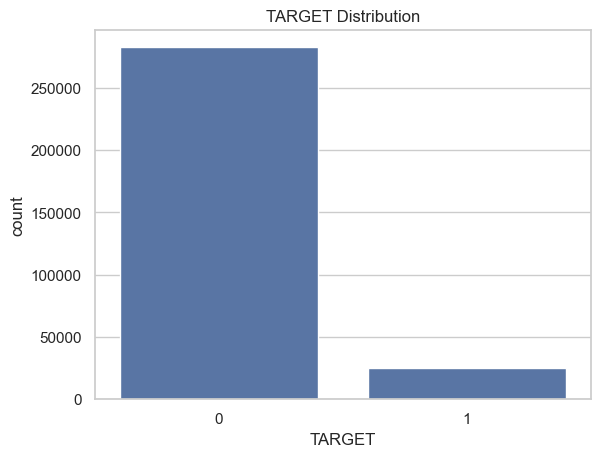

In [15]:
# Check TARGET balance
target_counts = app_train['TARGET'].value_counts(normalize=True) * 100
print(target_counts)

# Plot
sns.countplot(data=app_train, x='TARGET')
plt.title("TARGET Distribution")
plt.show()


Numerical Feature Distributions

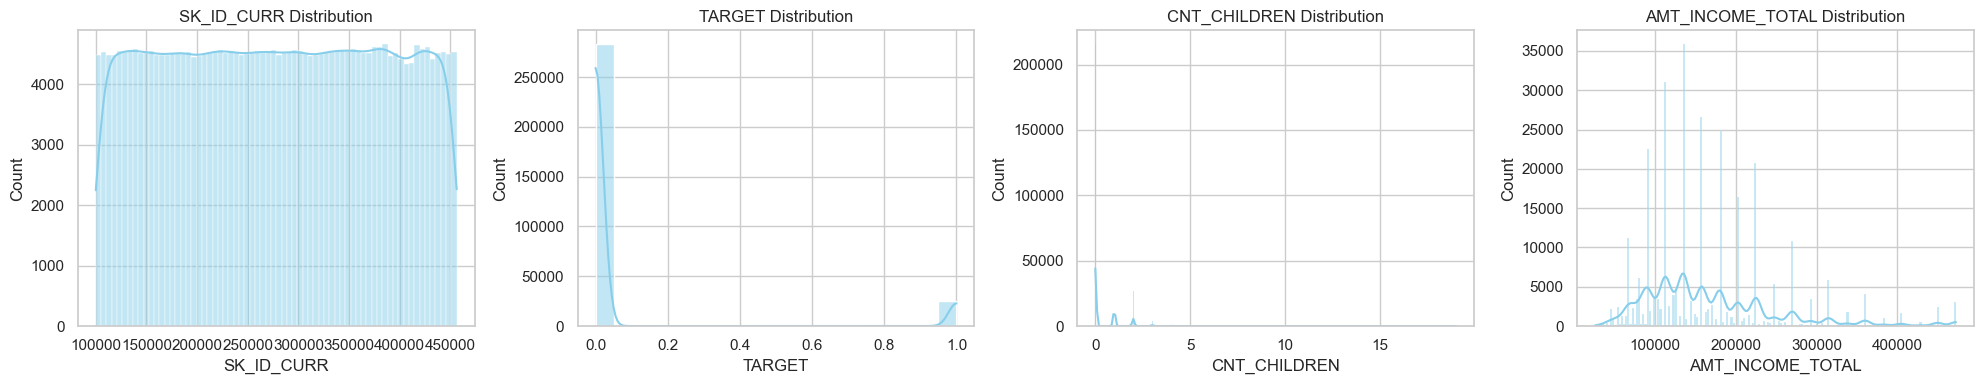

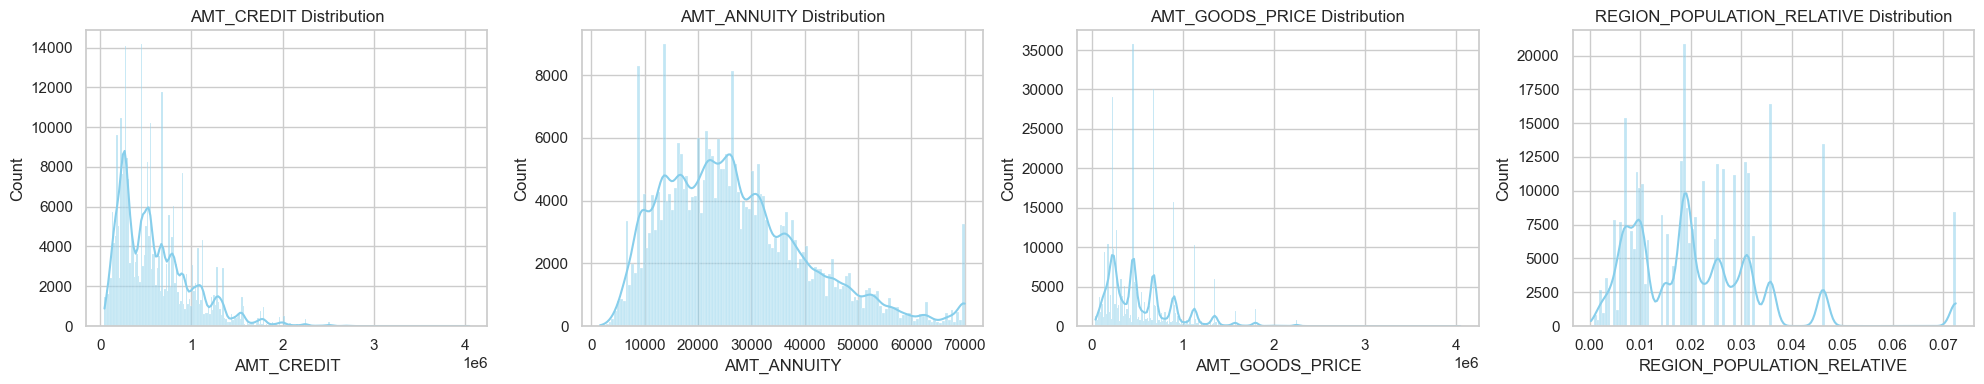

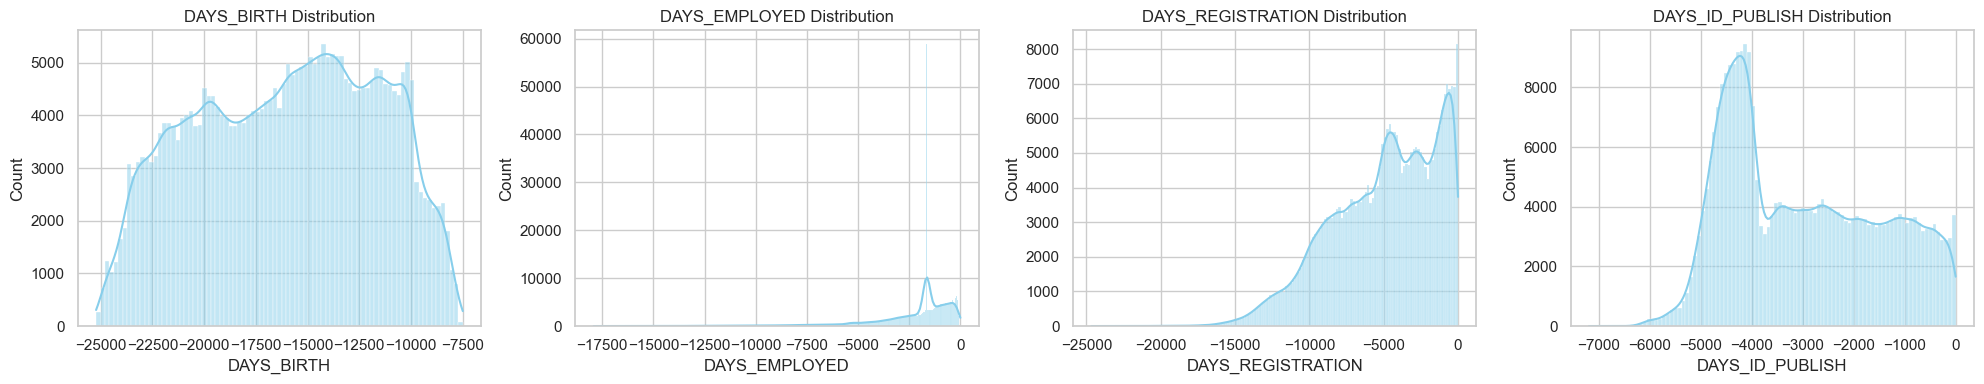

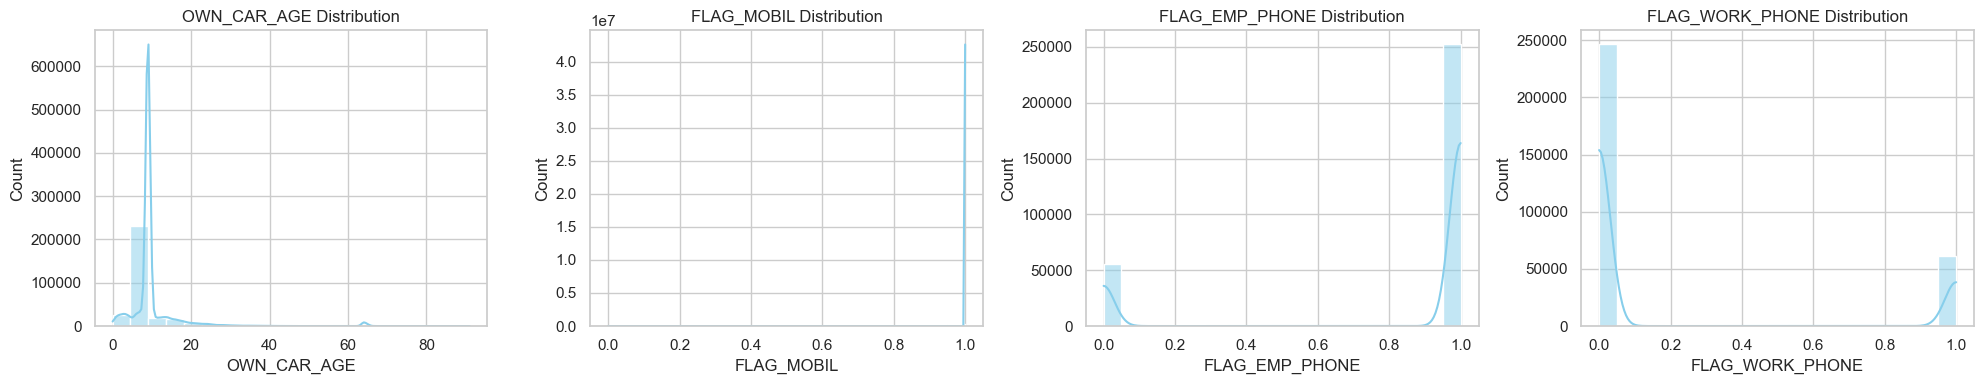

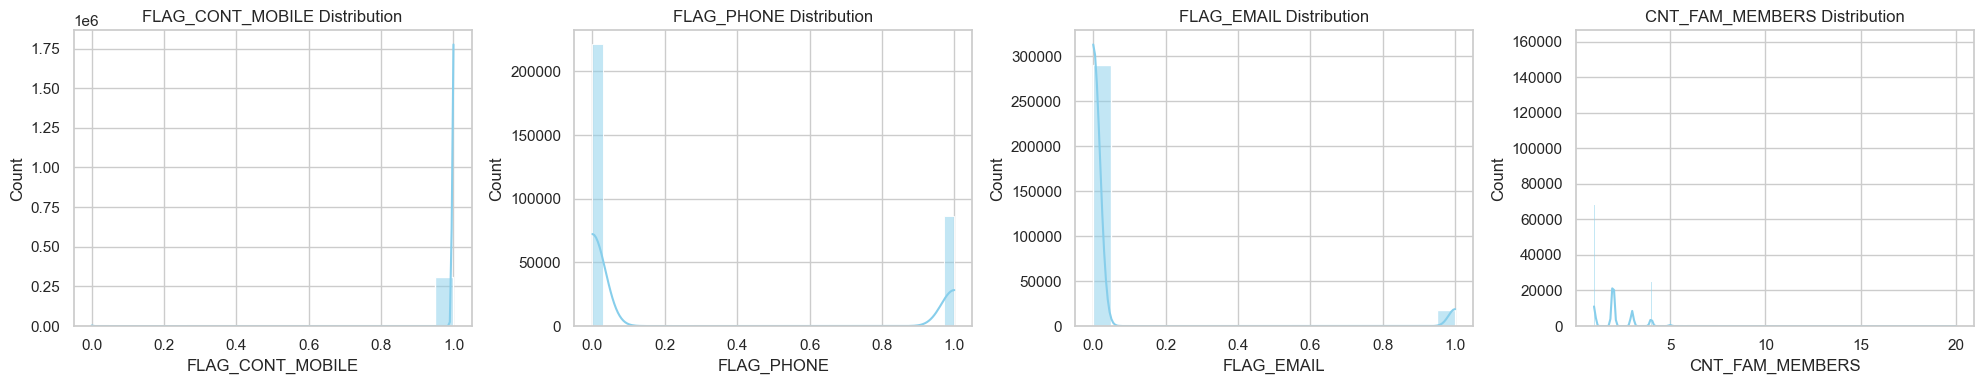

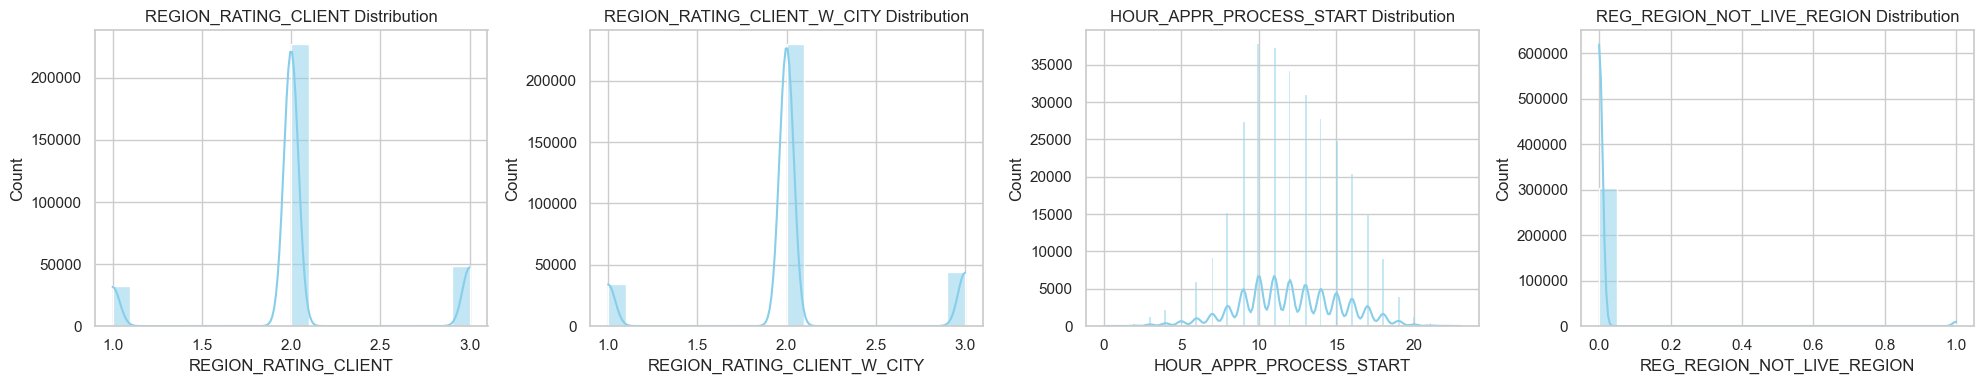

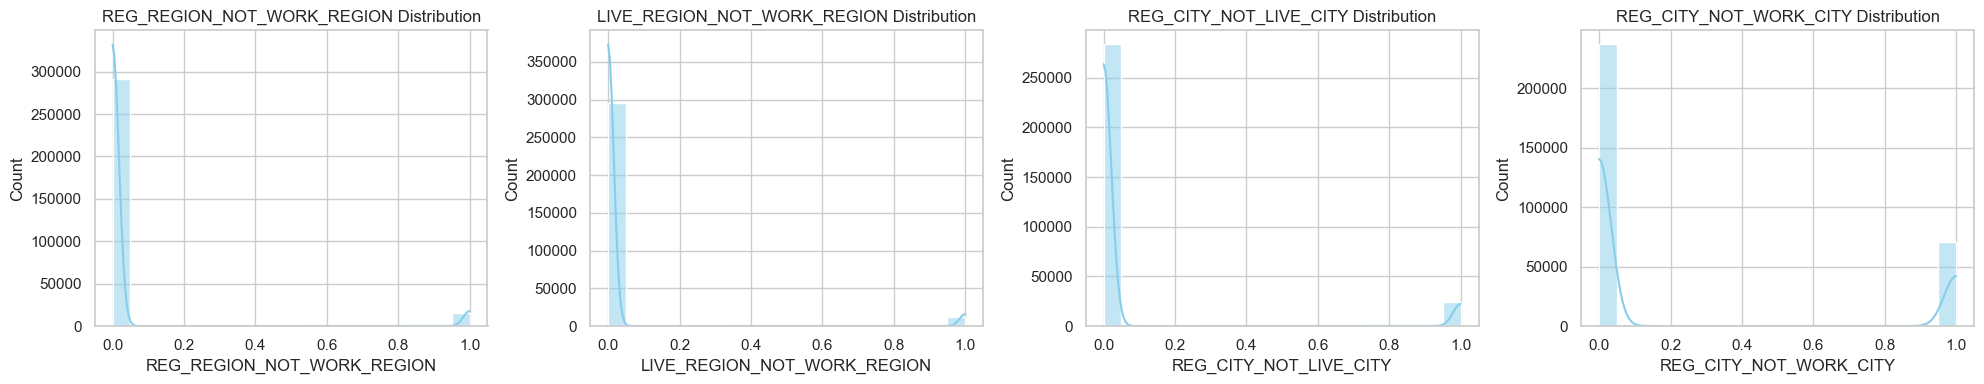

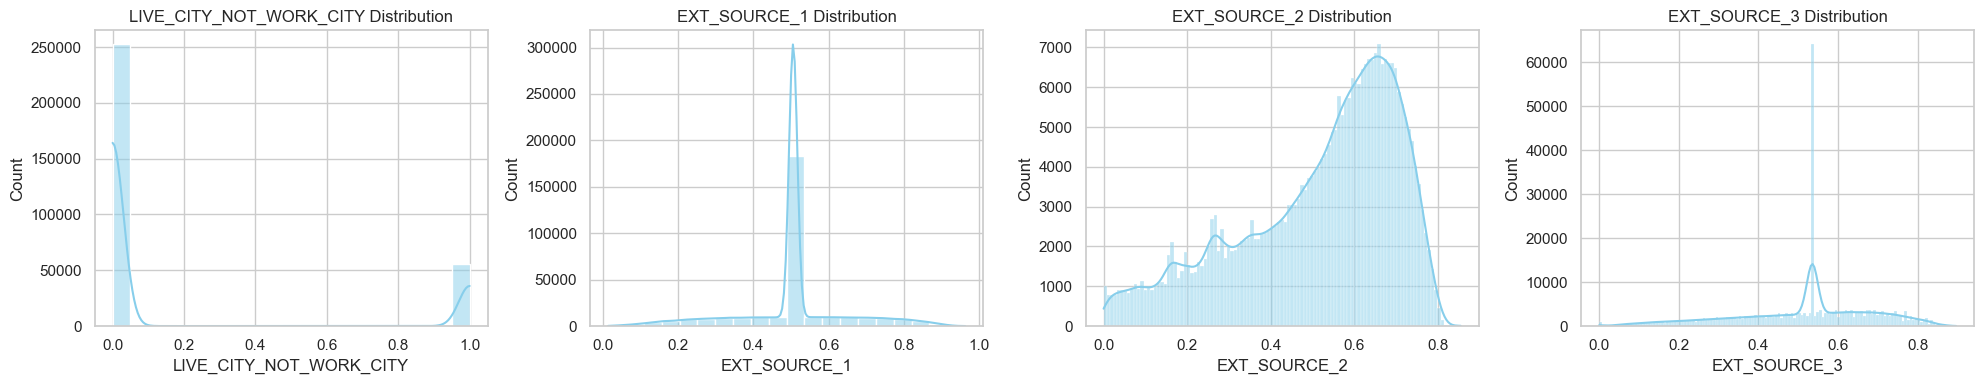

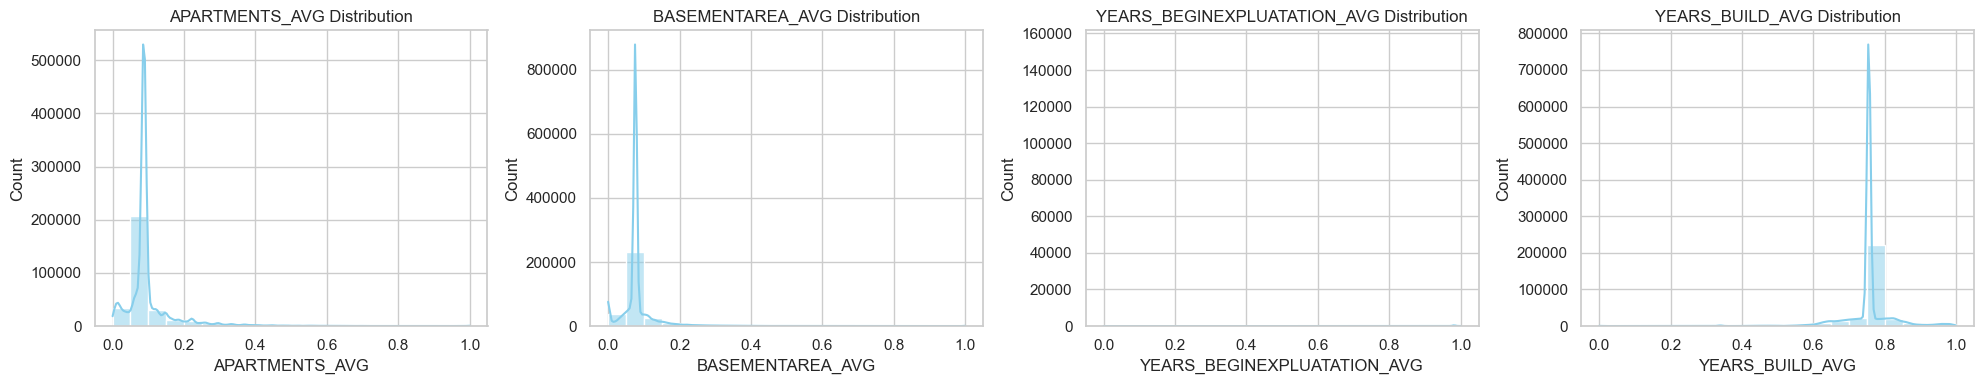

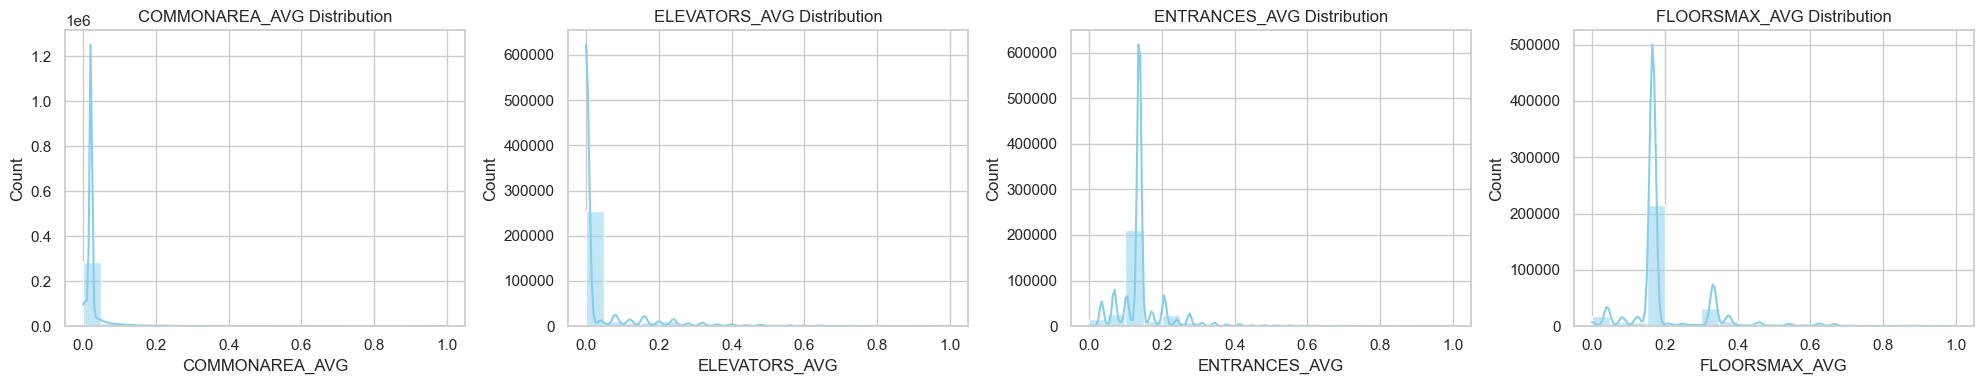

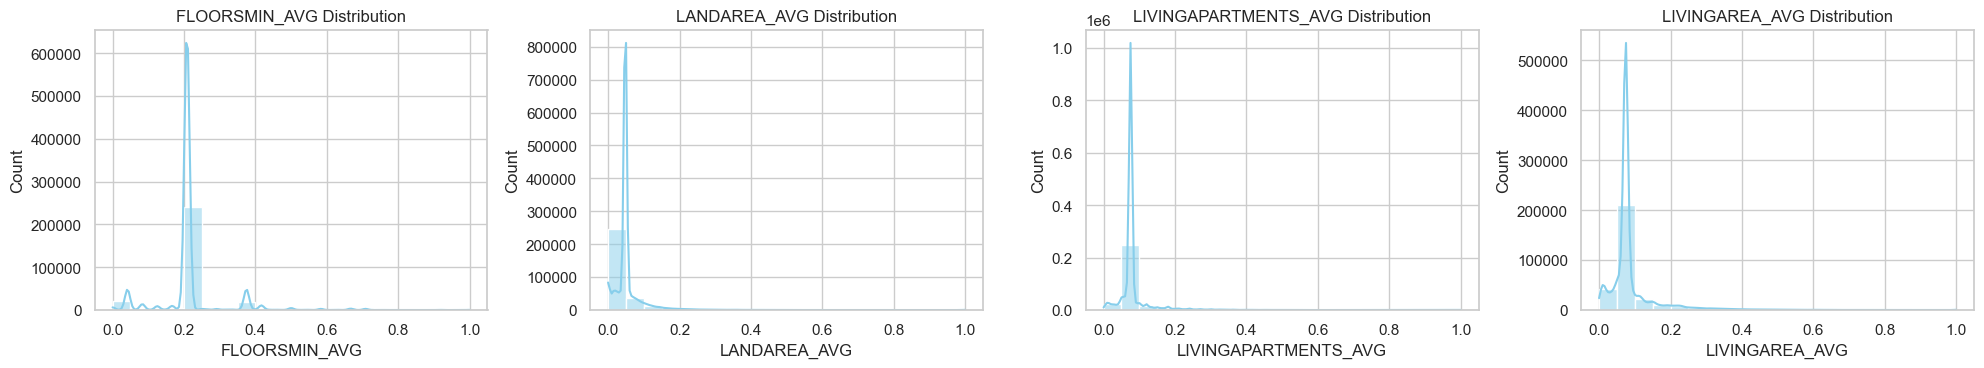

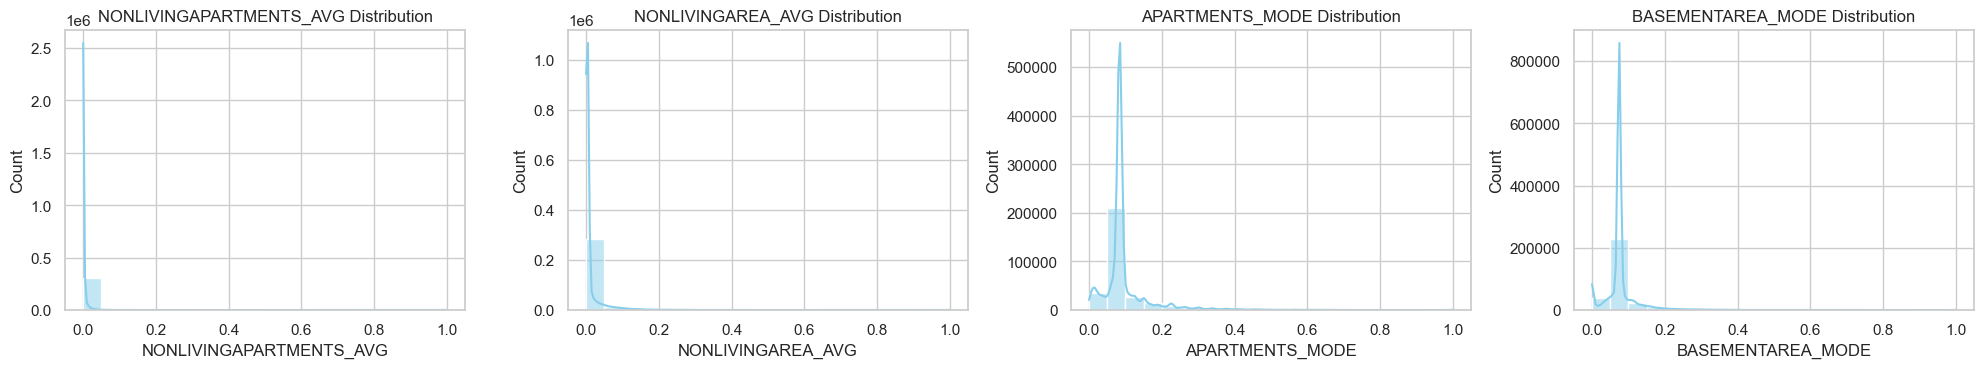

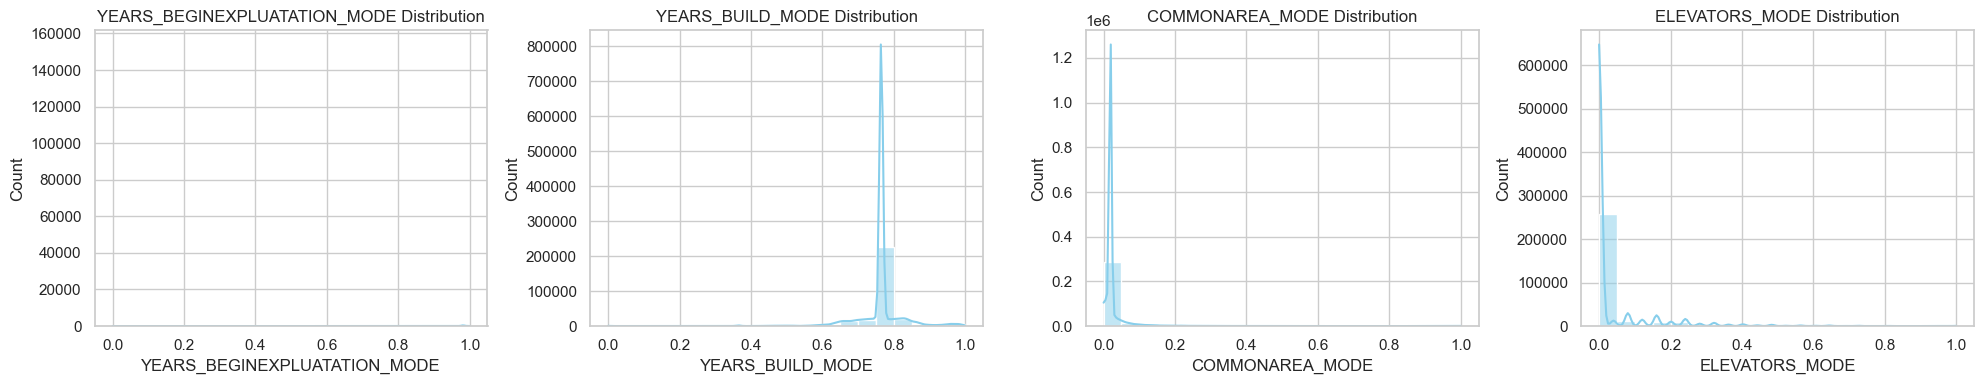

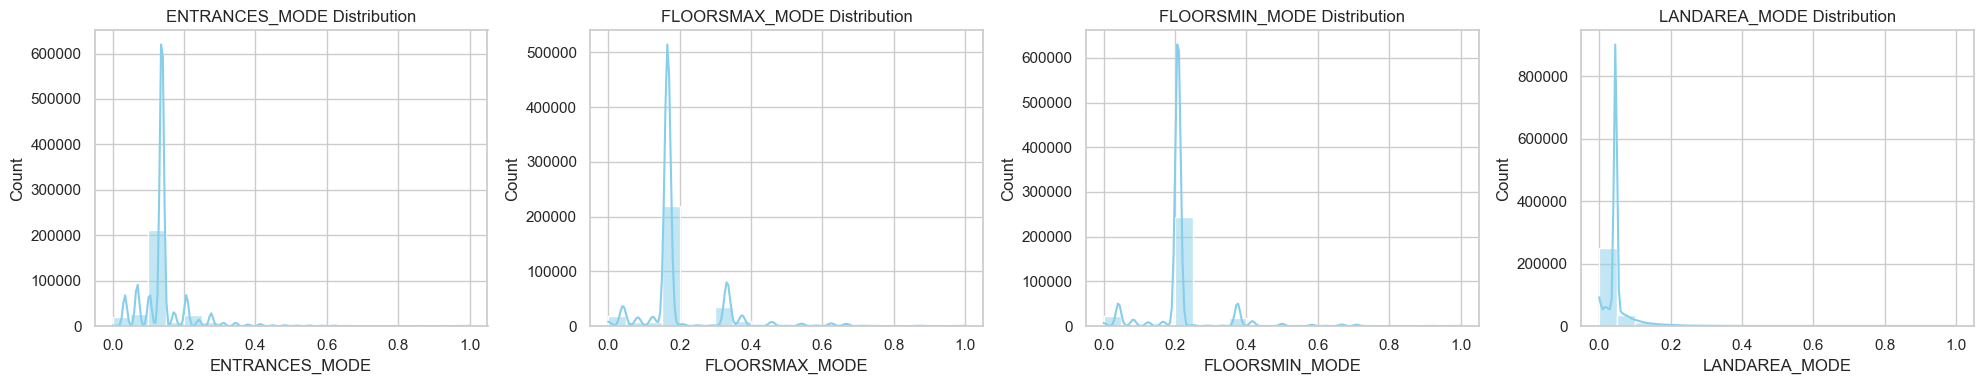

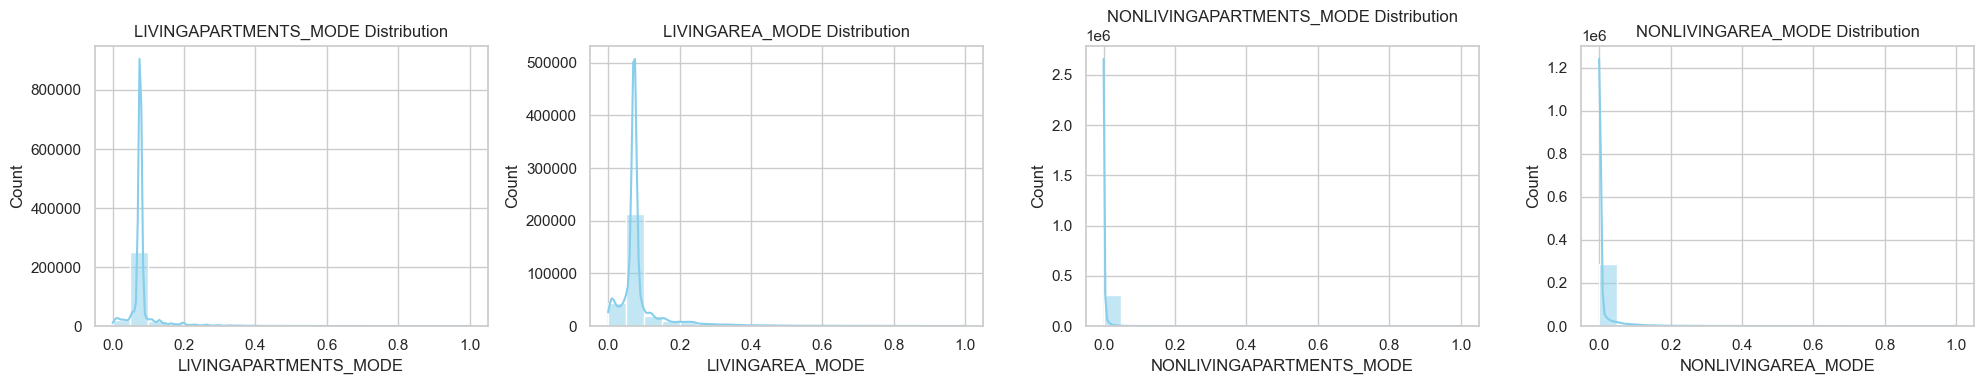

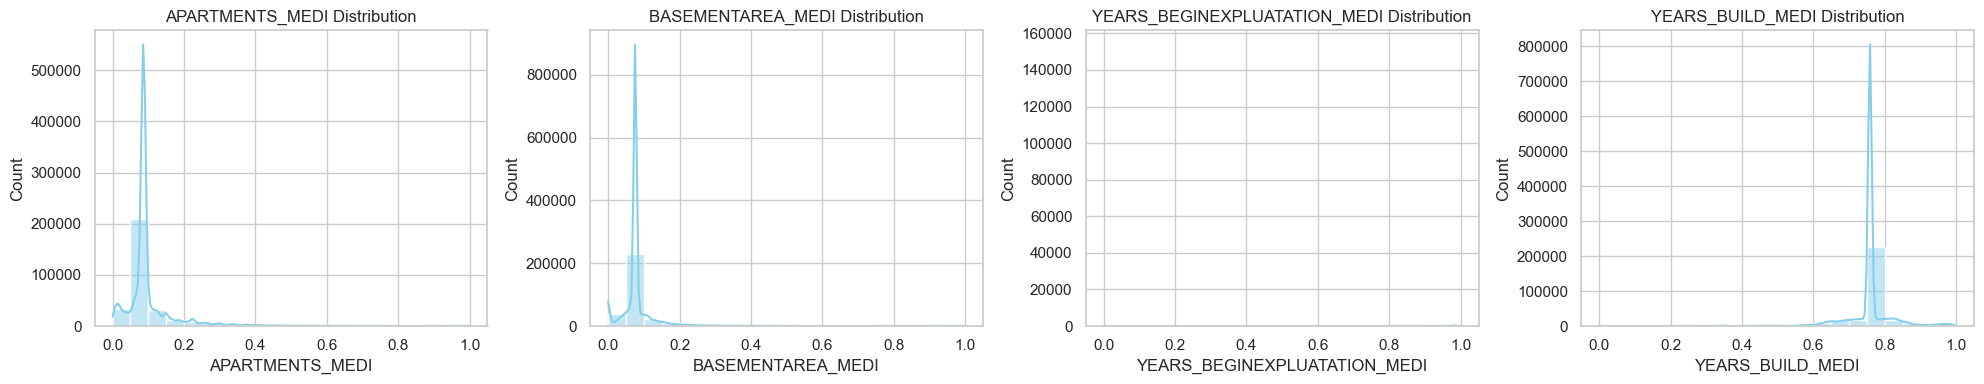

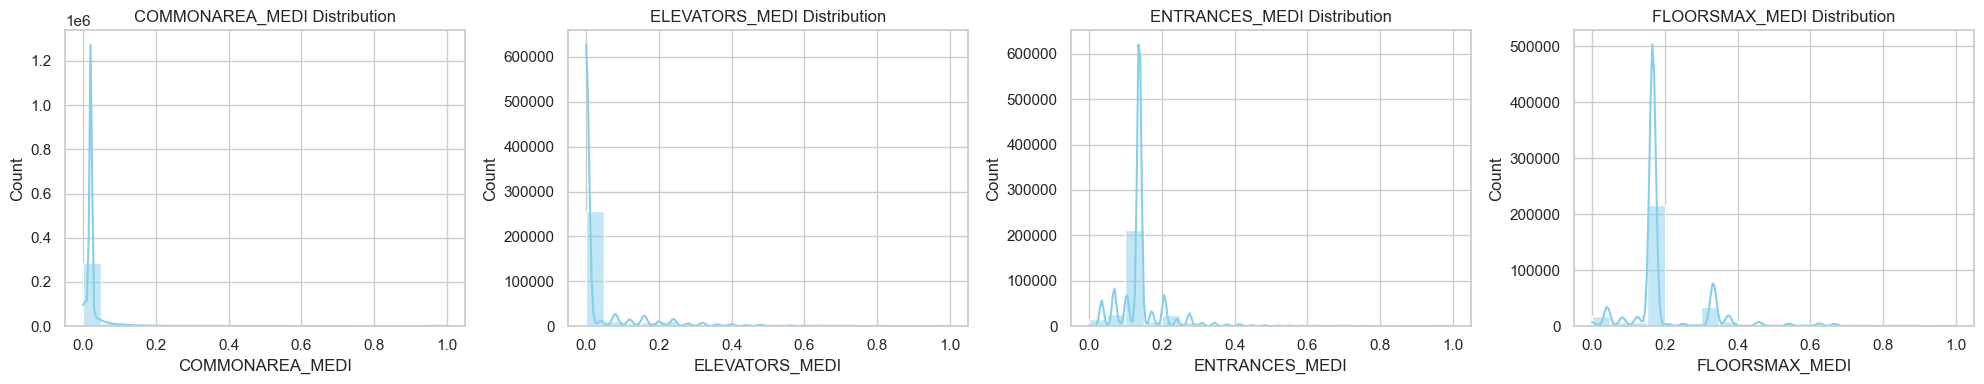

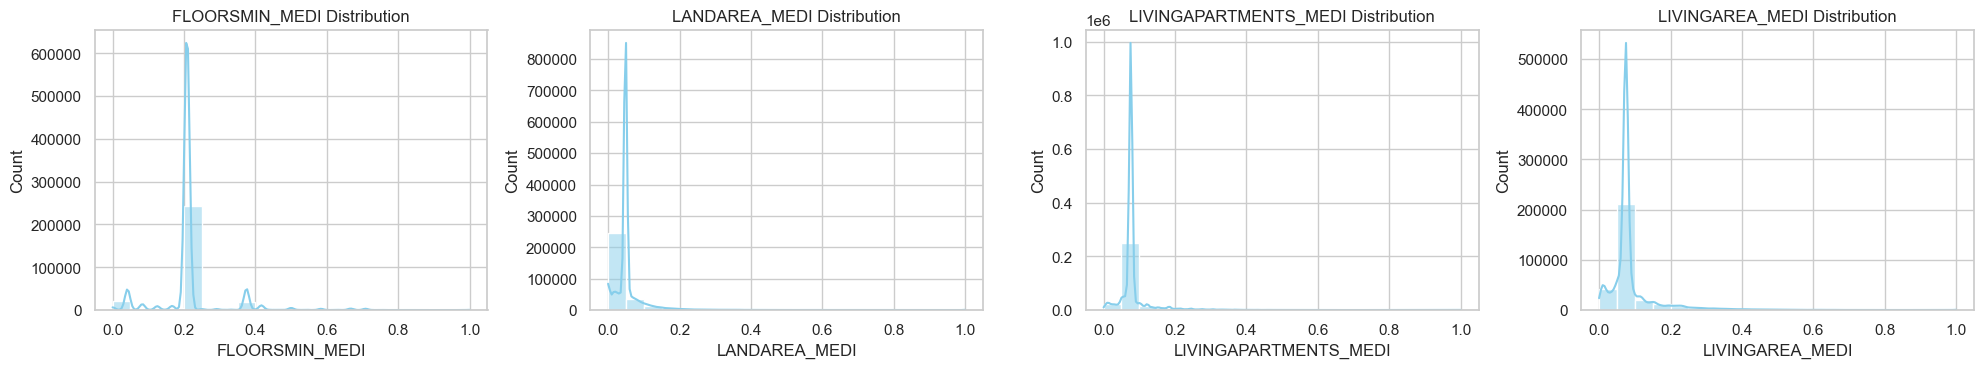

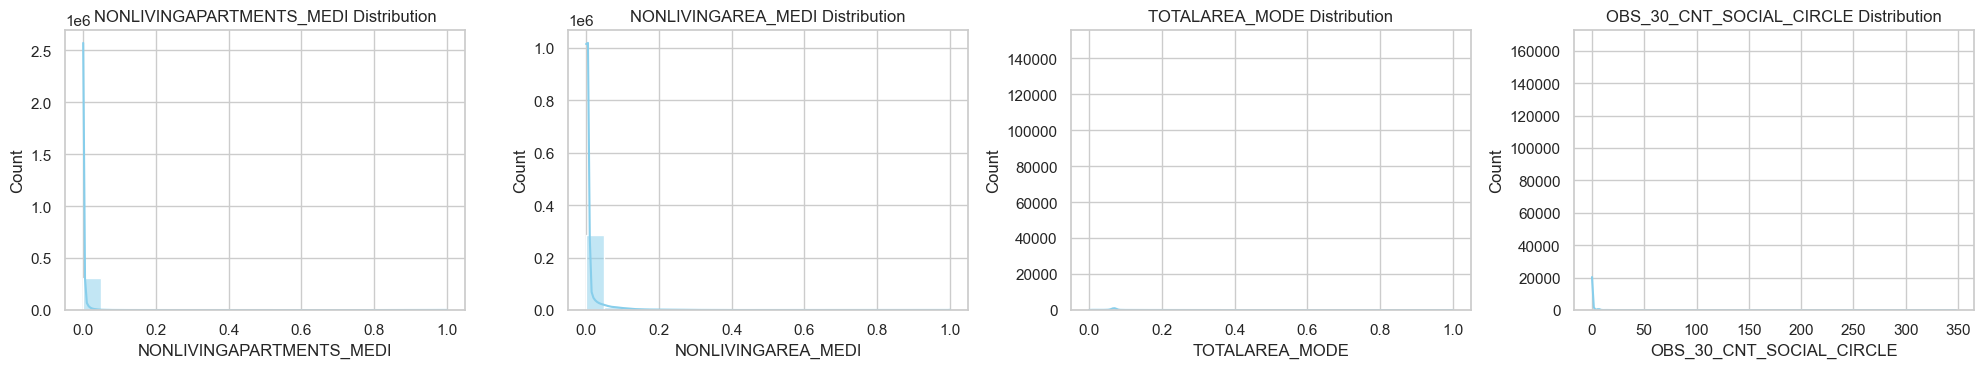

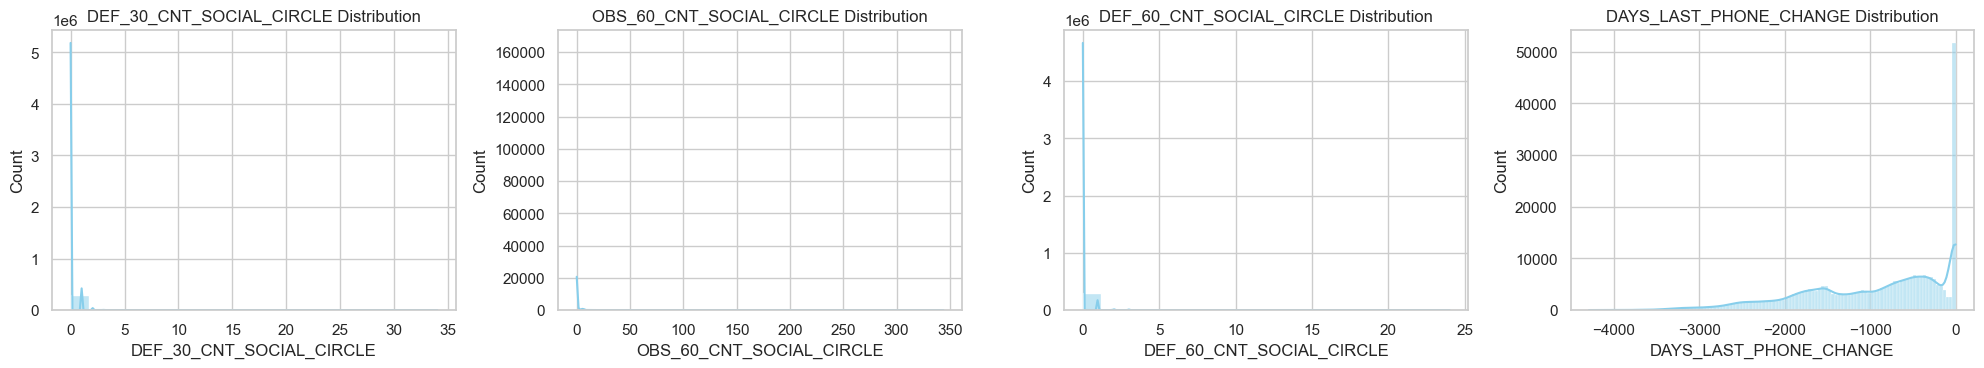

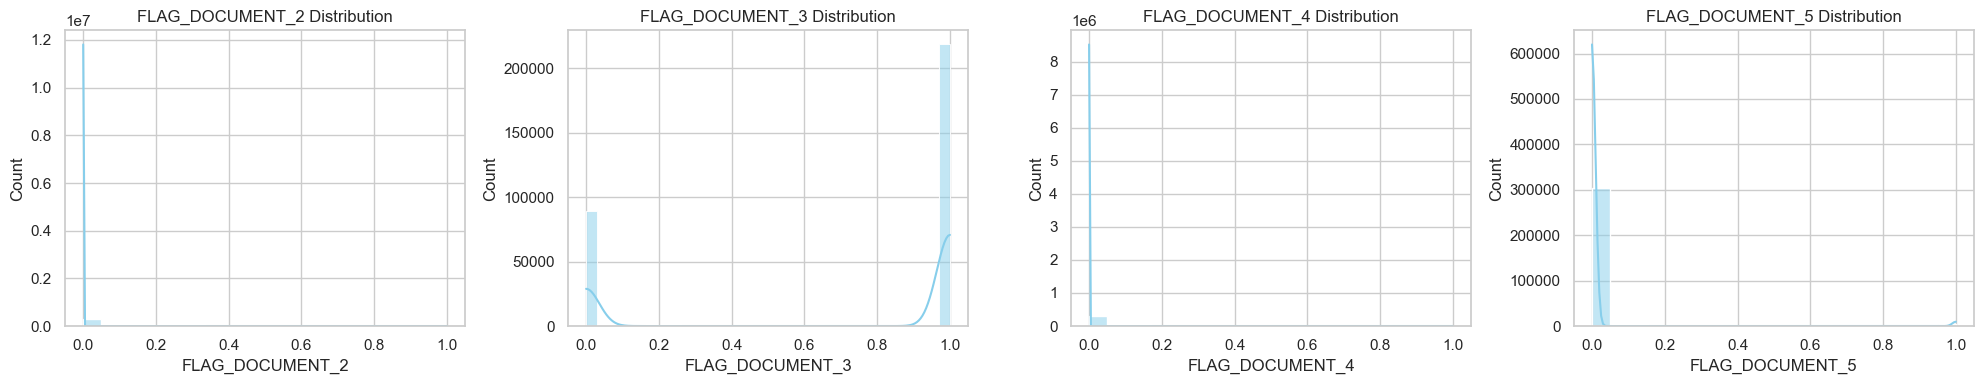

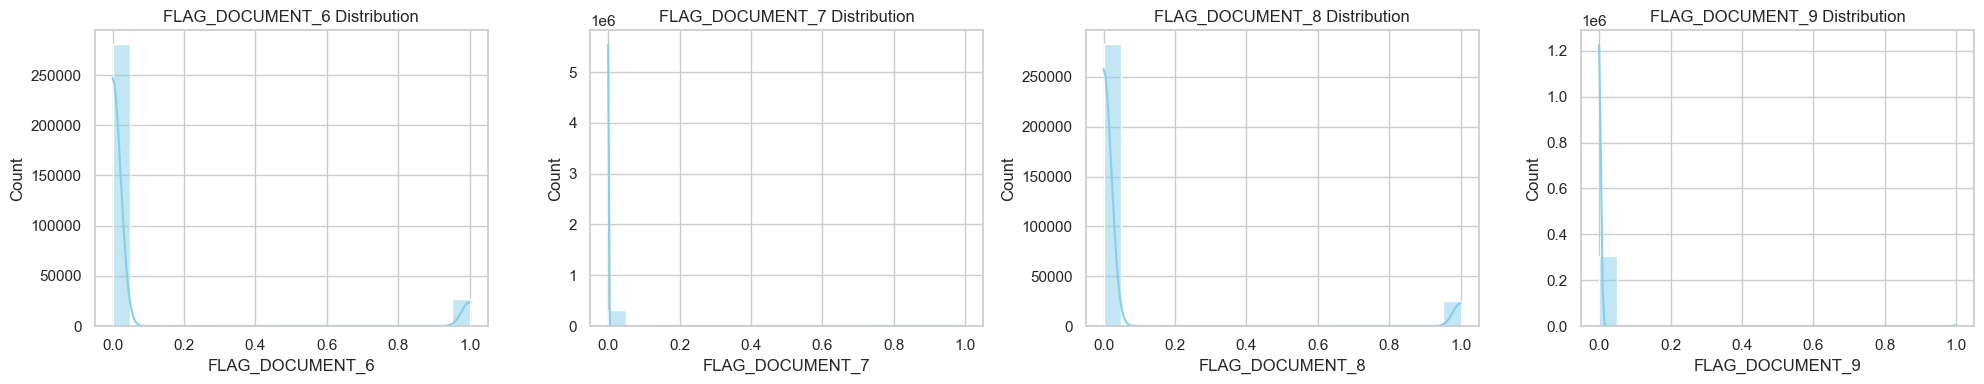

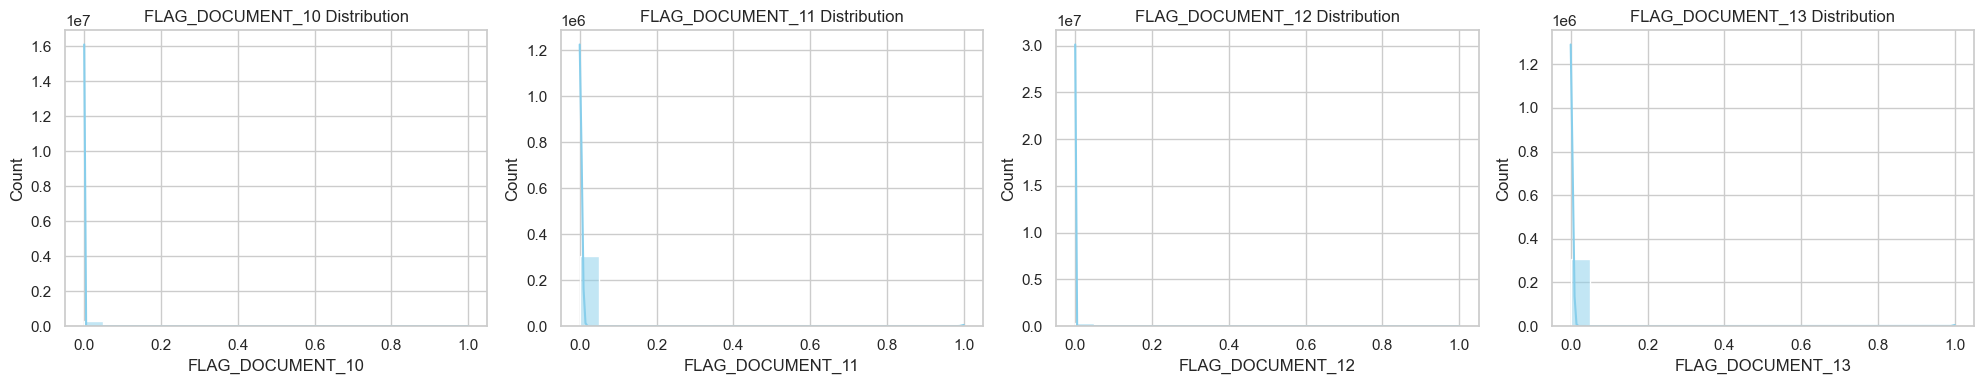

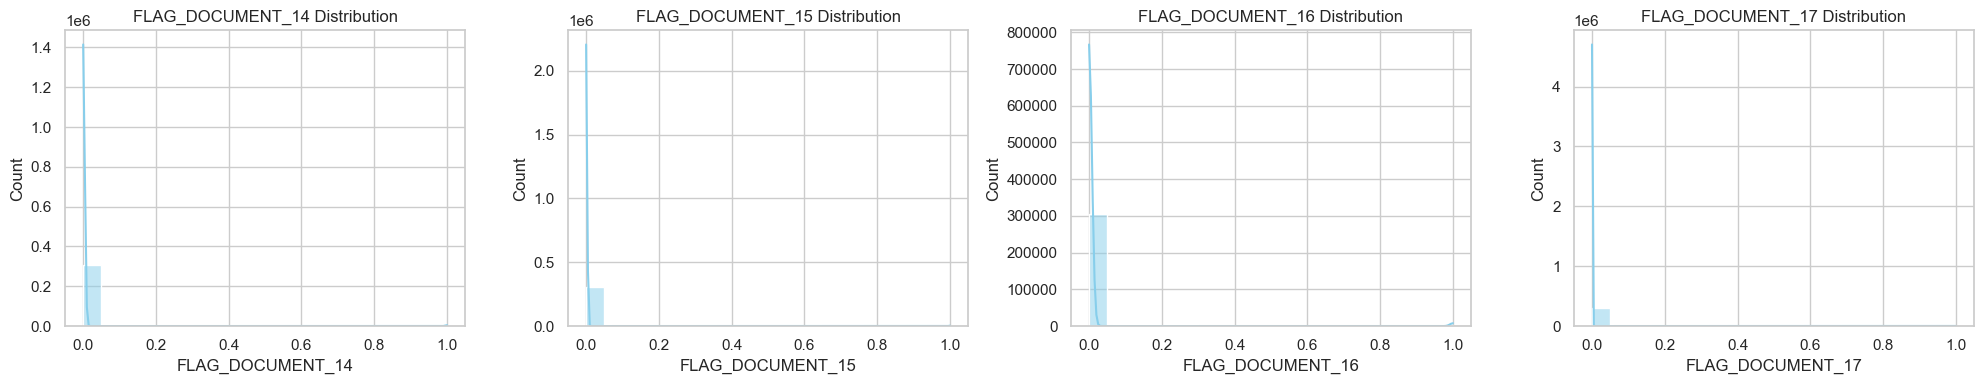

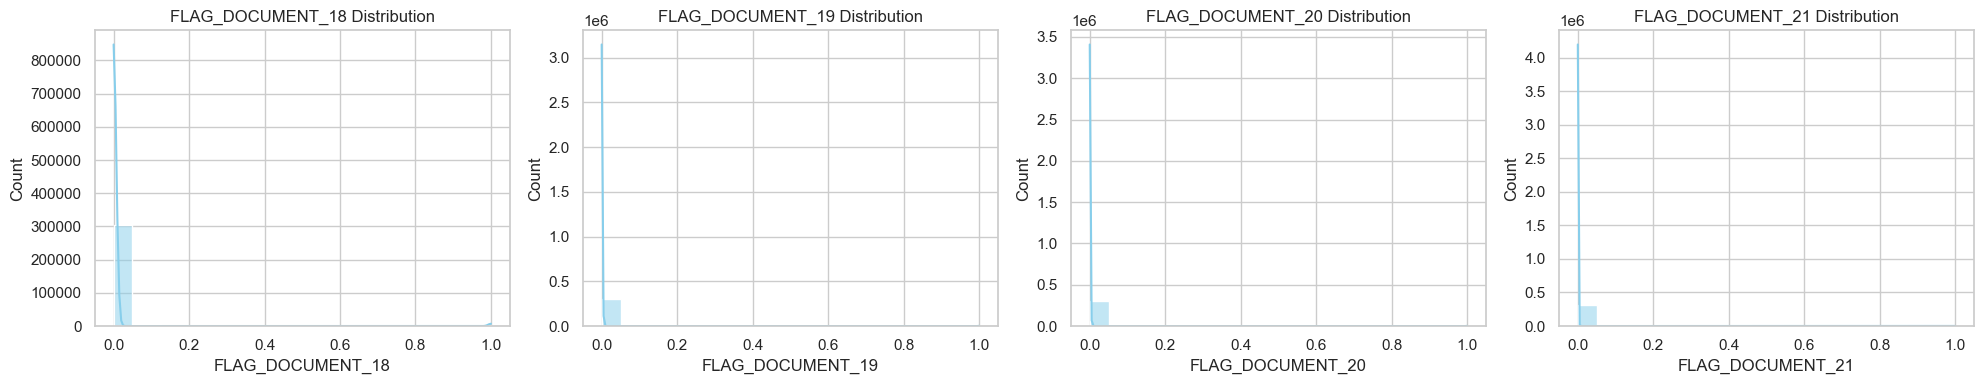

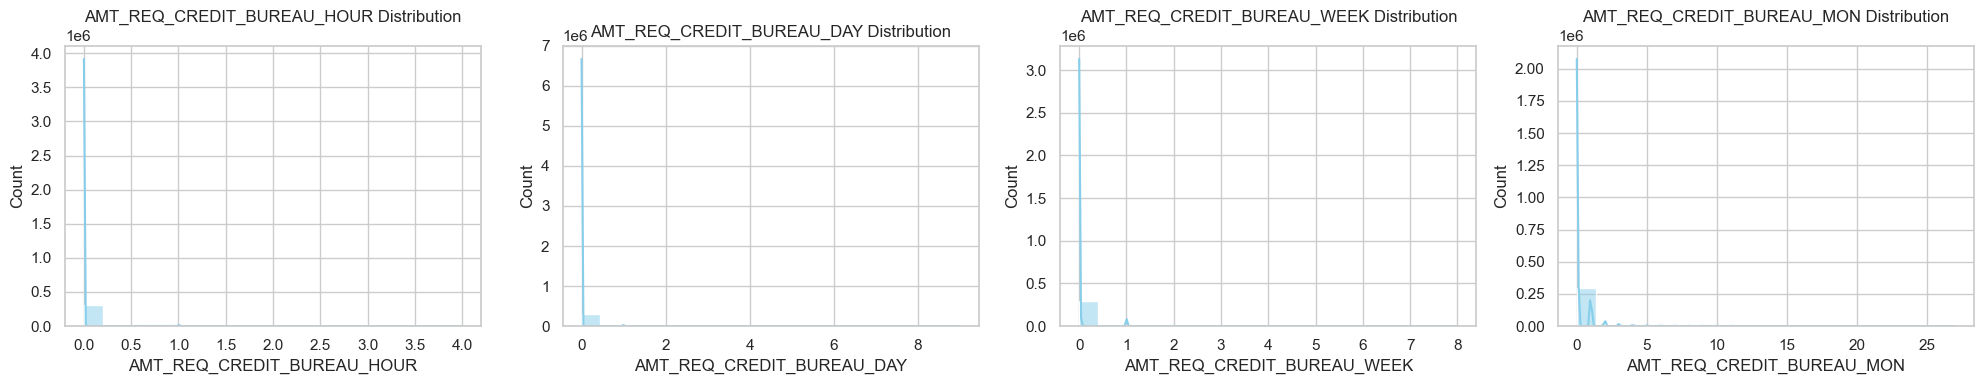

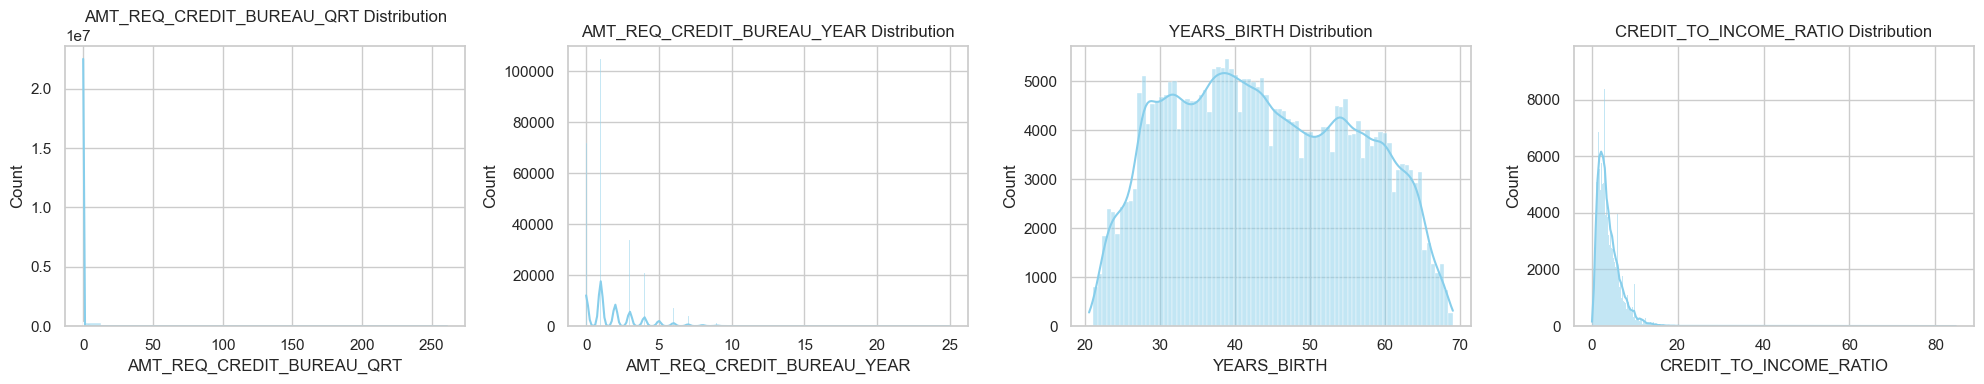

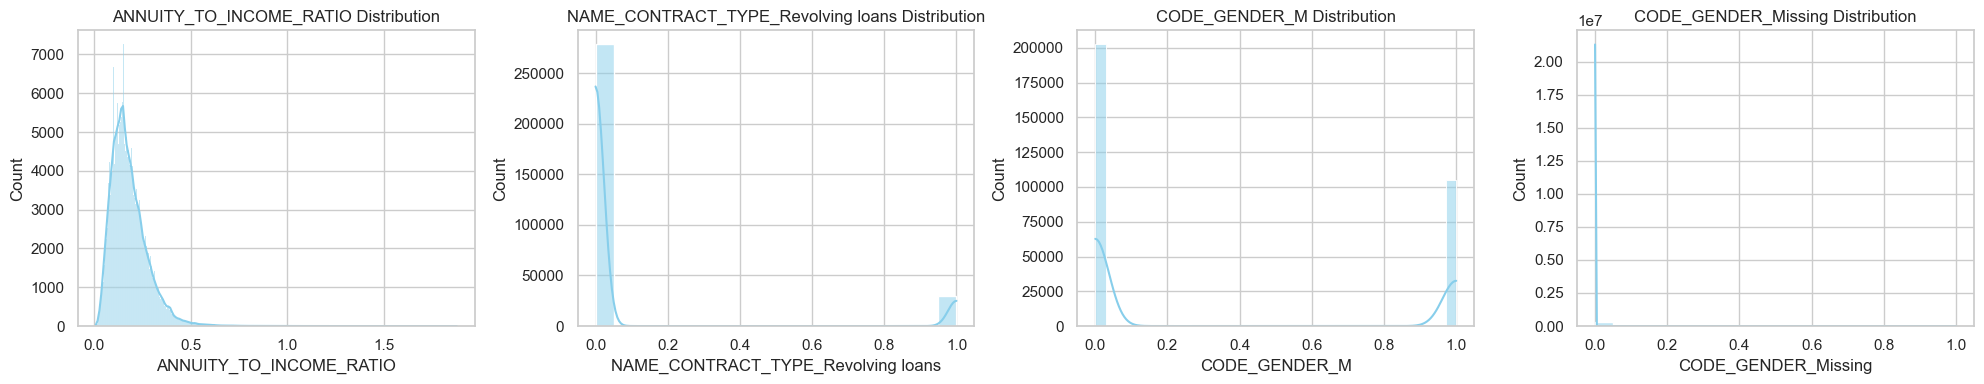

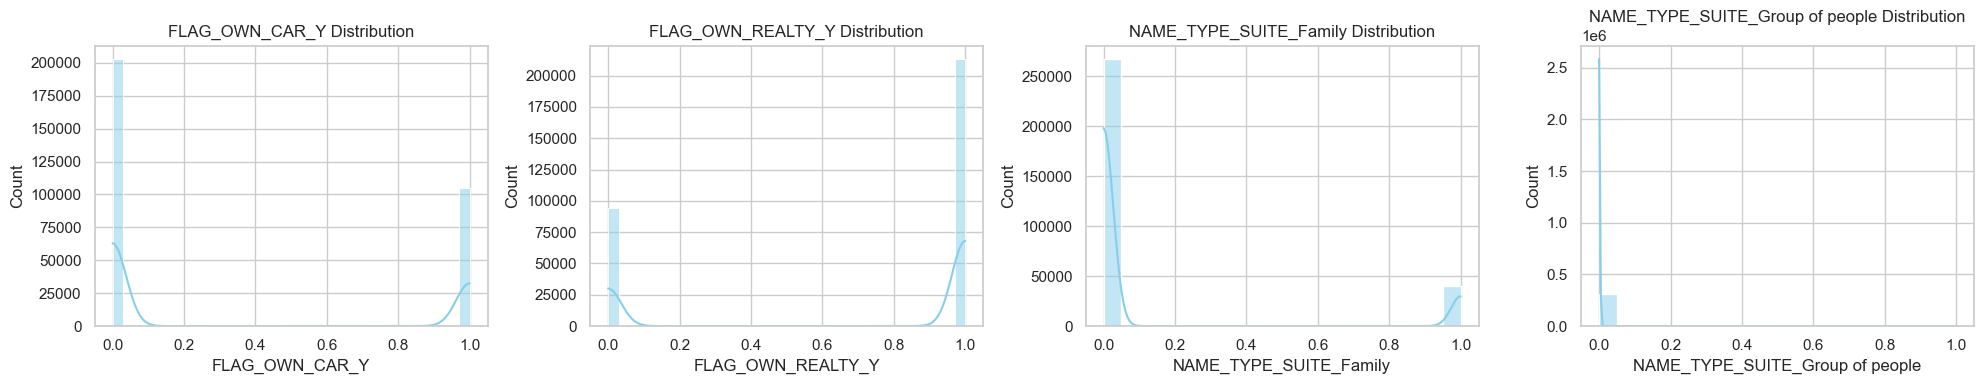

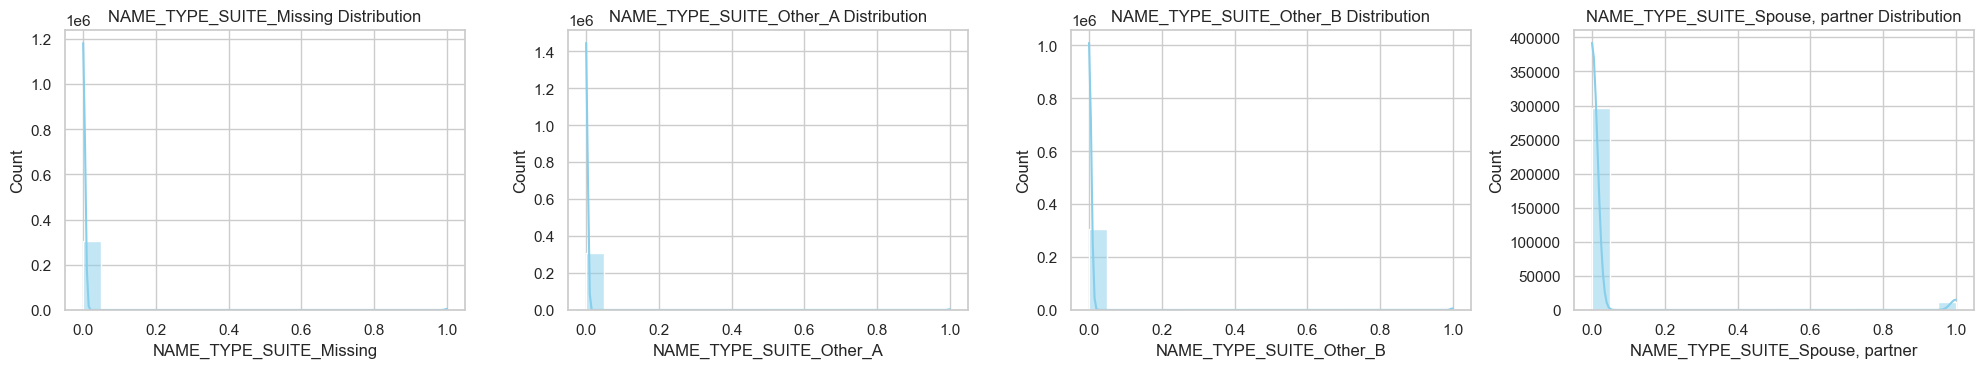

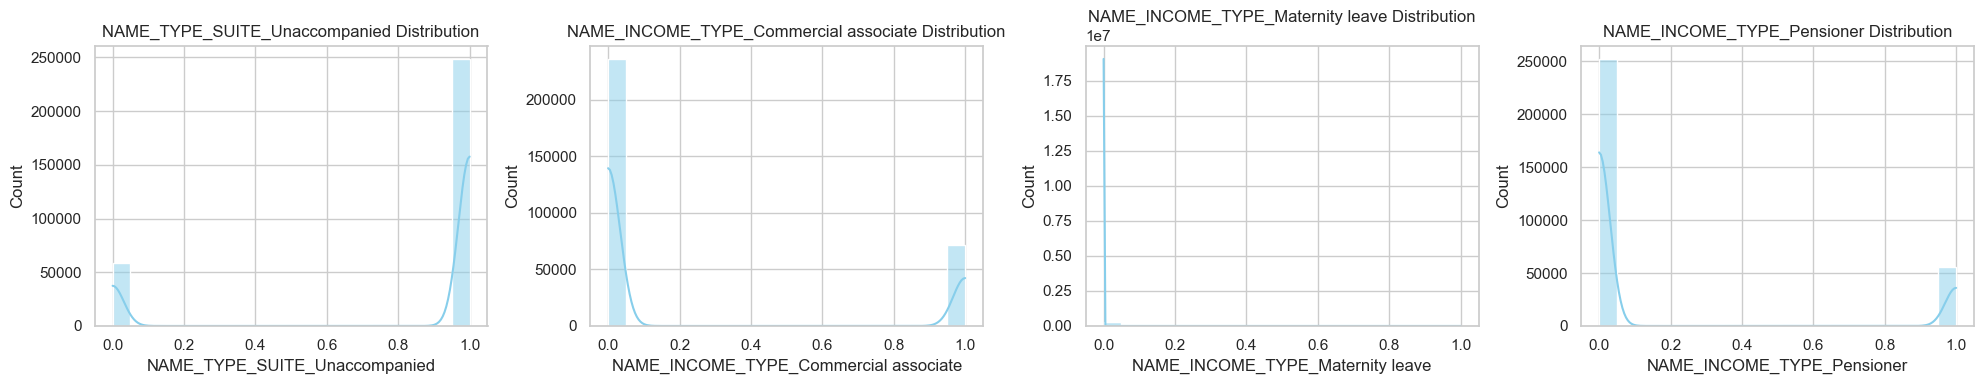

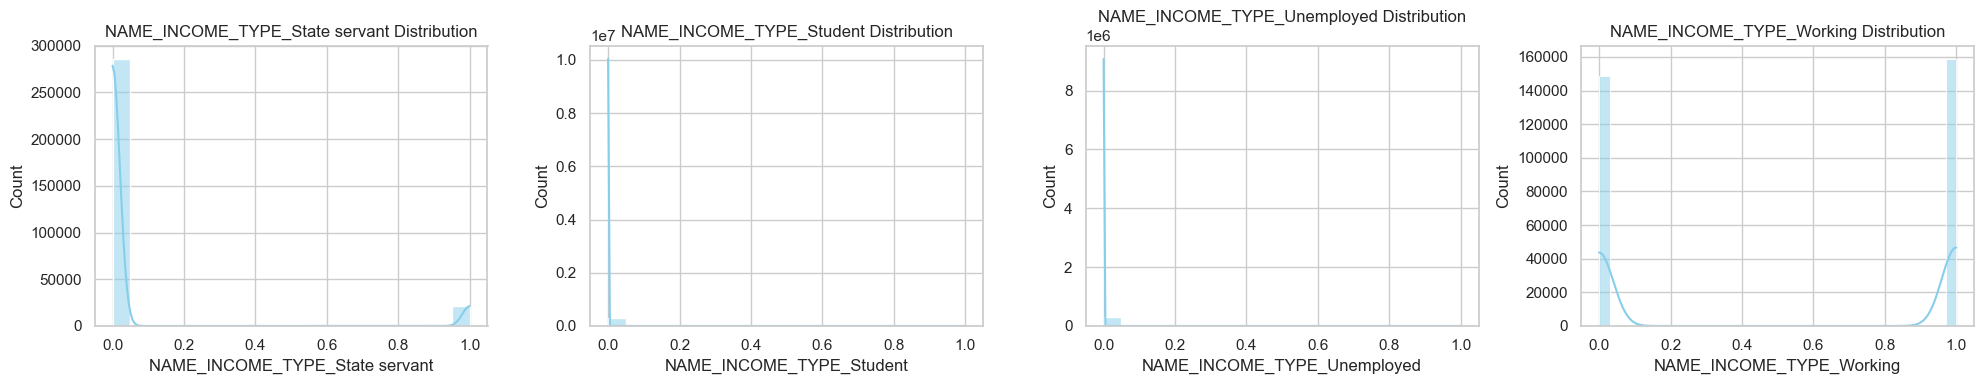

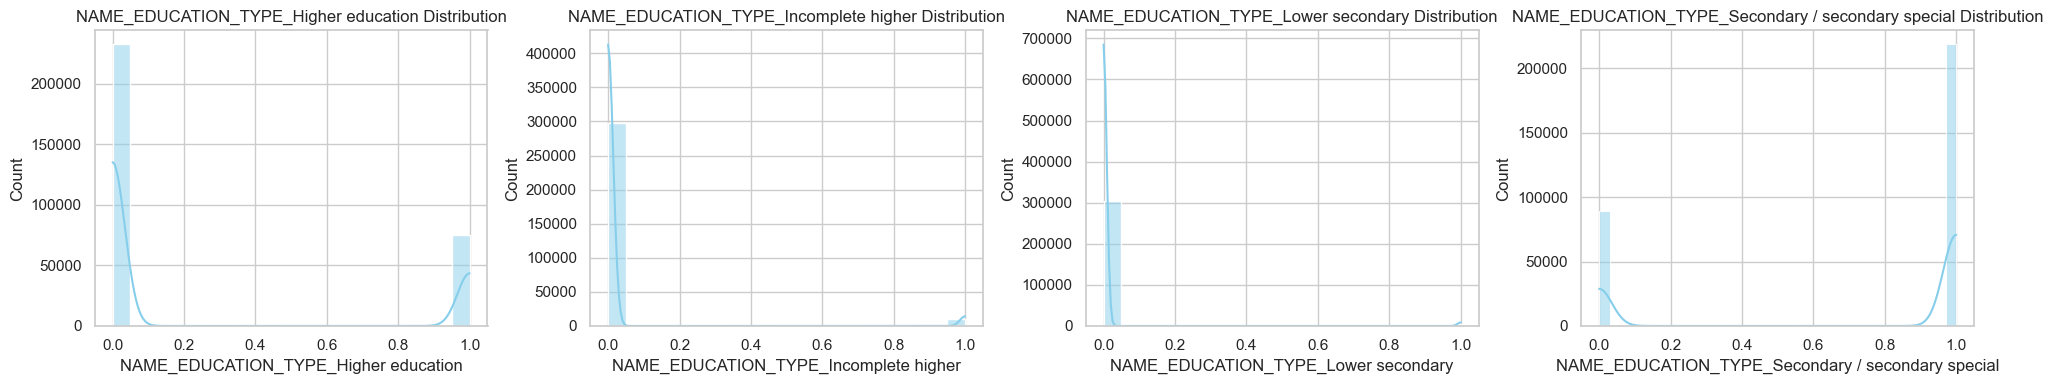

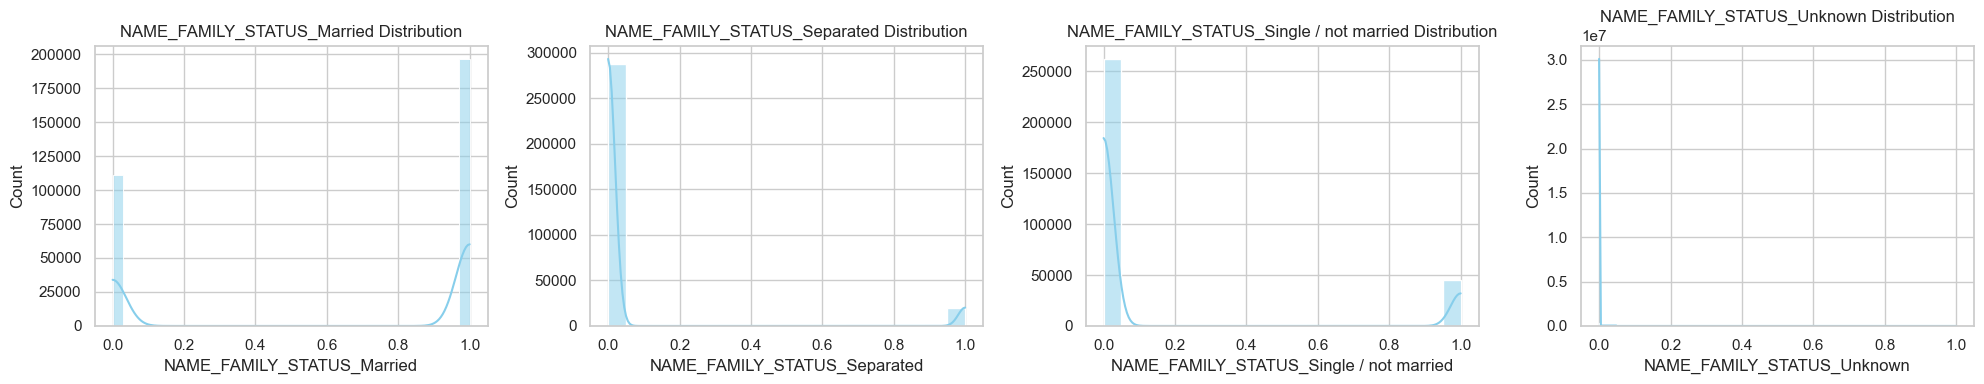

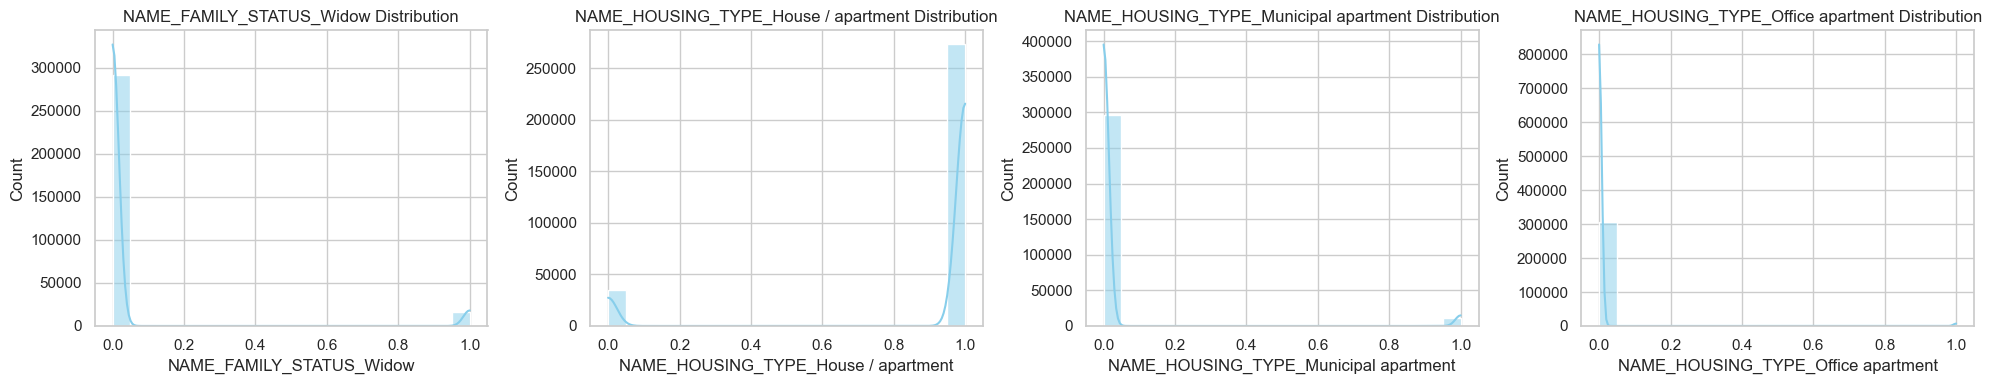

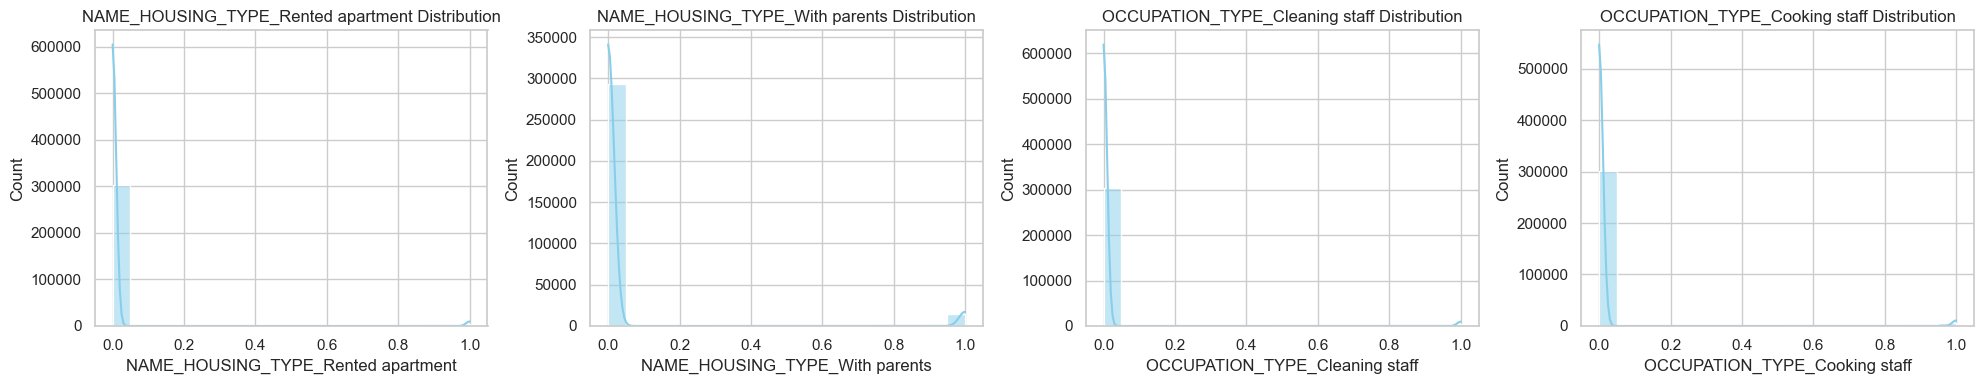

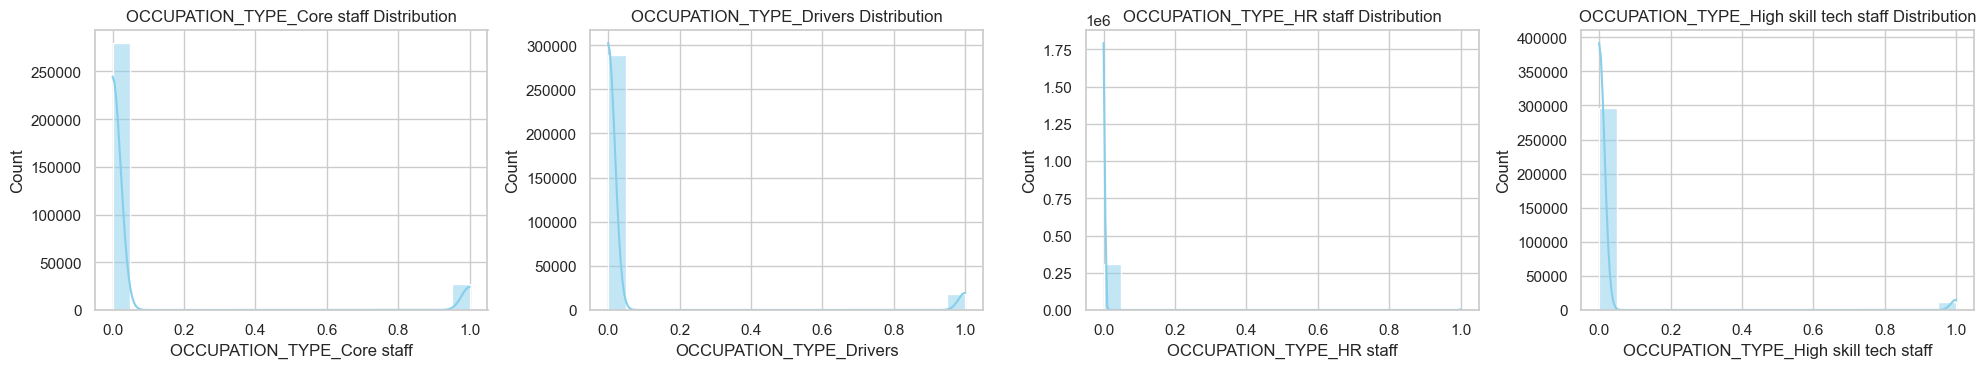

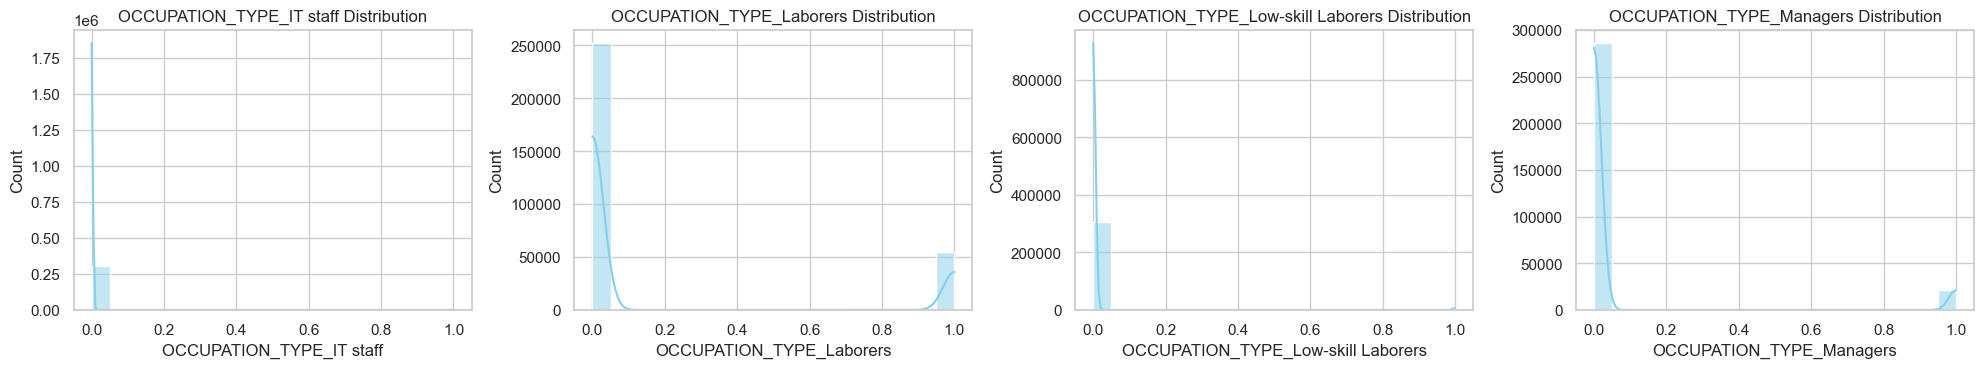

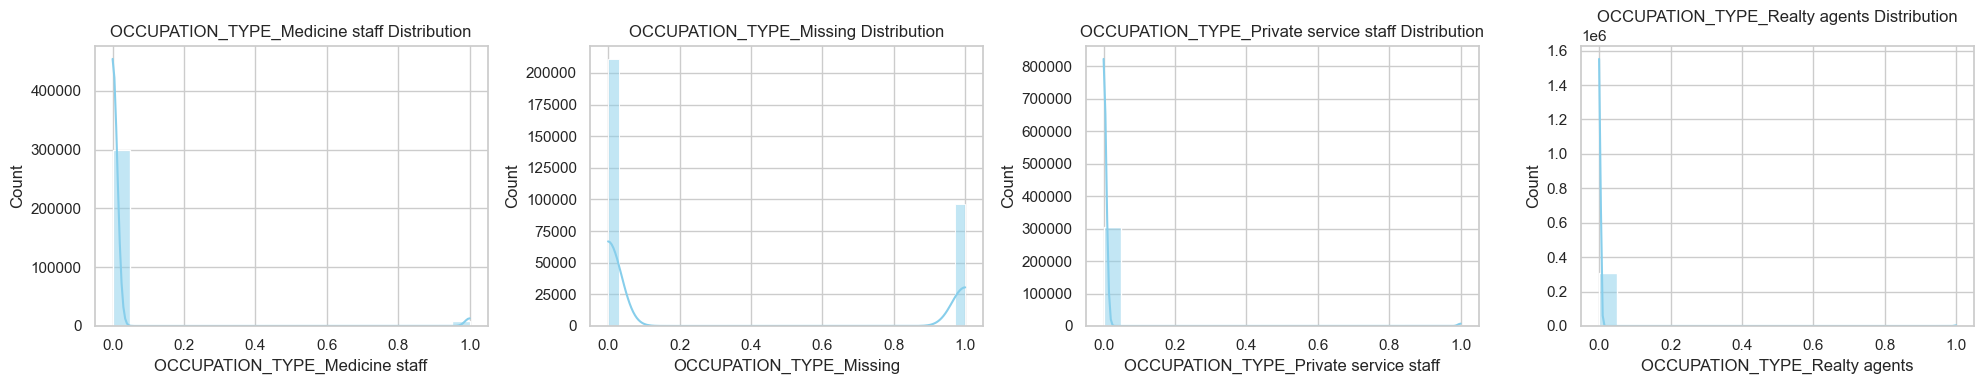

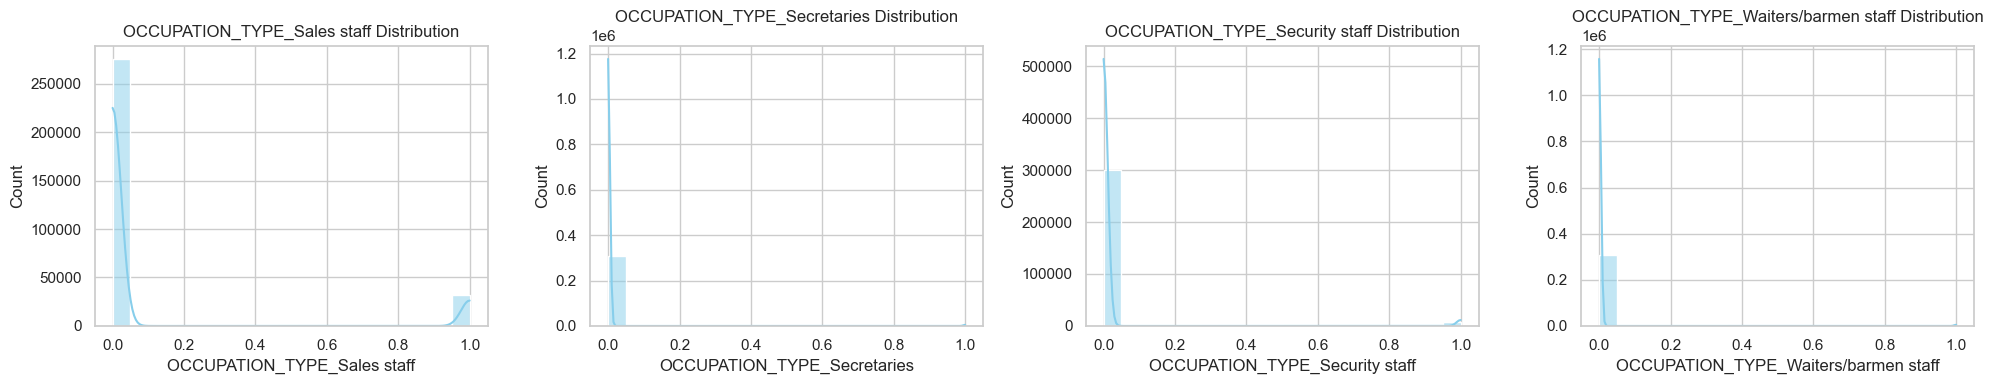

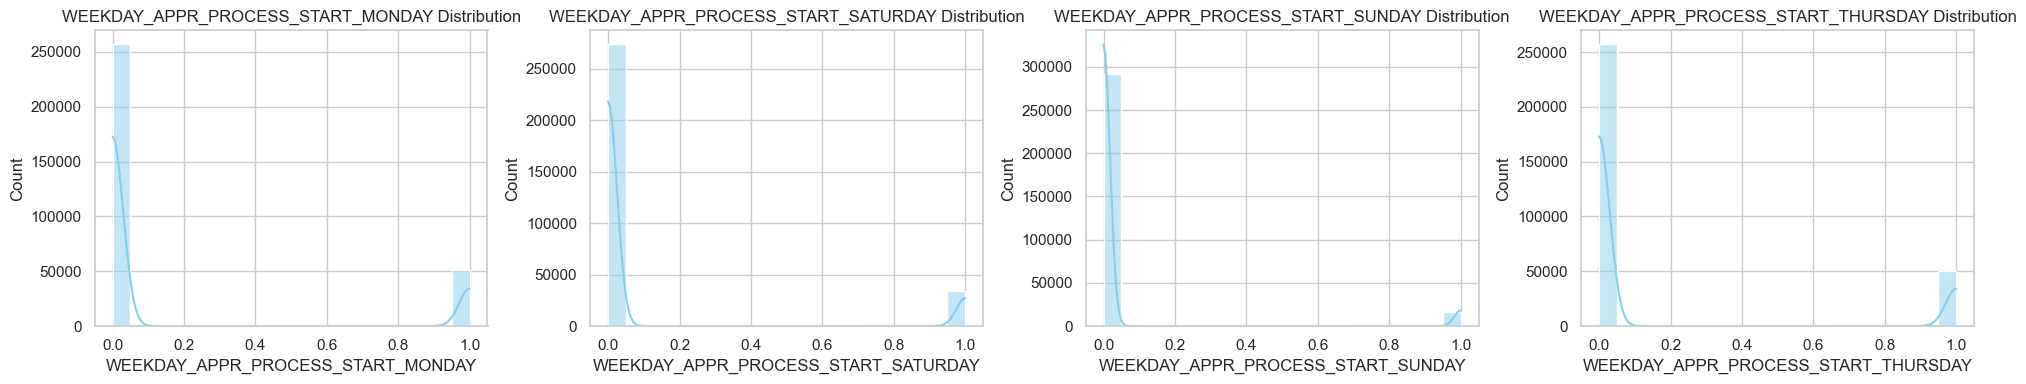

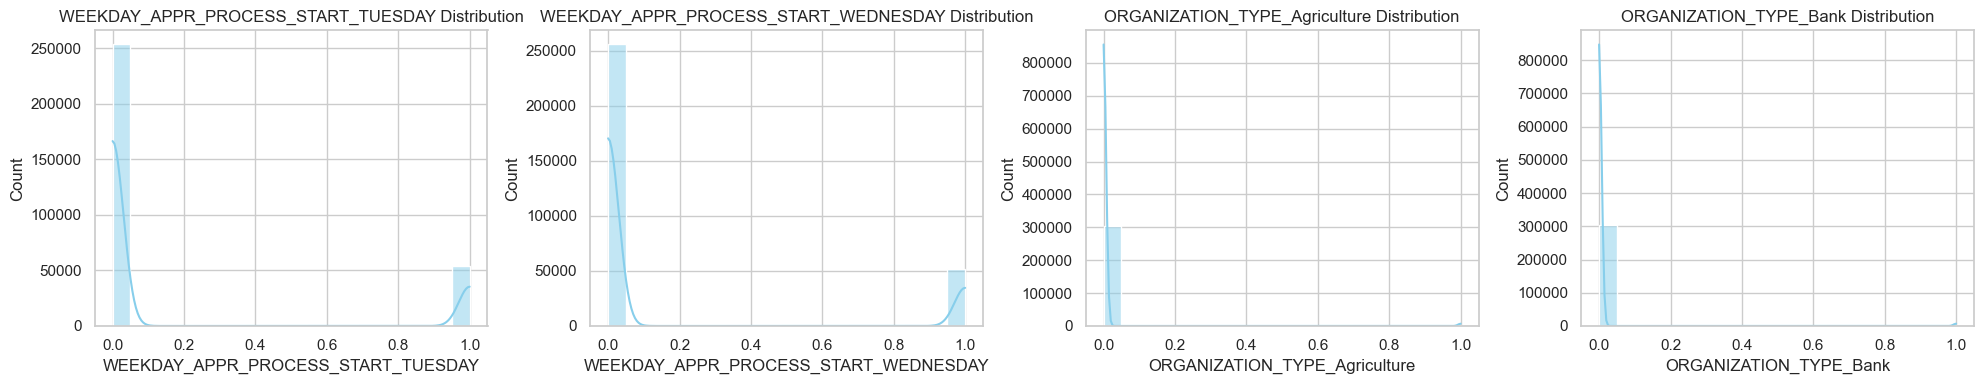

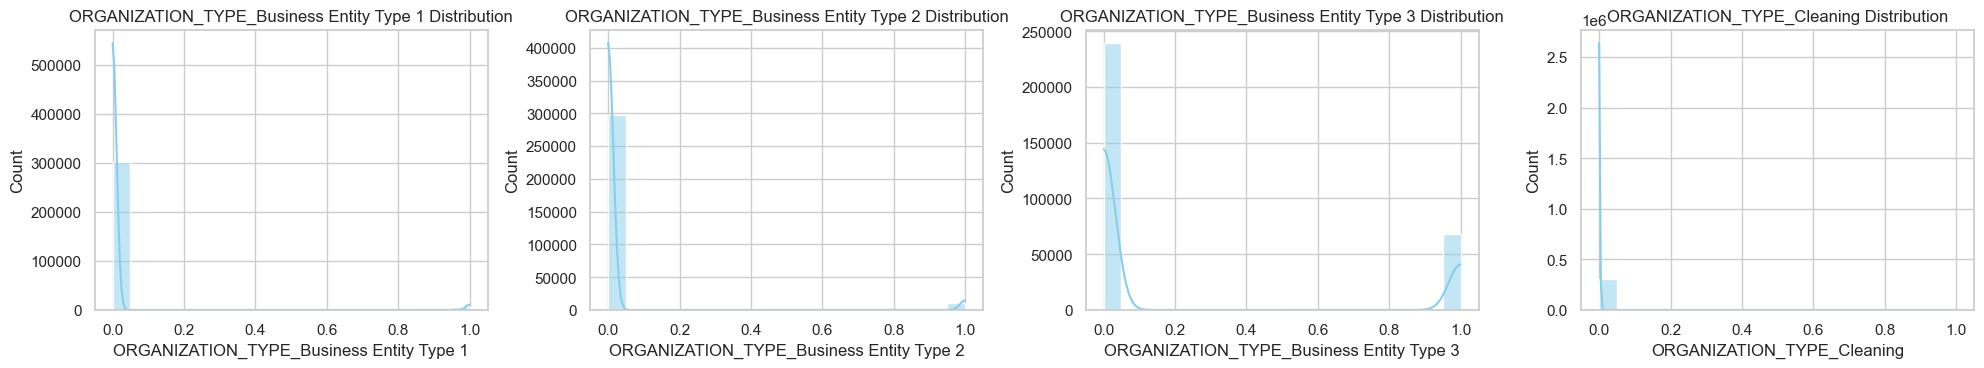

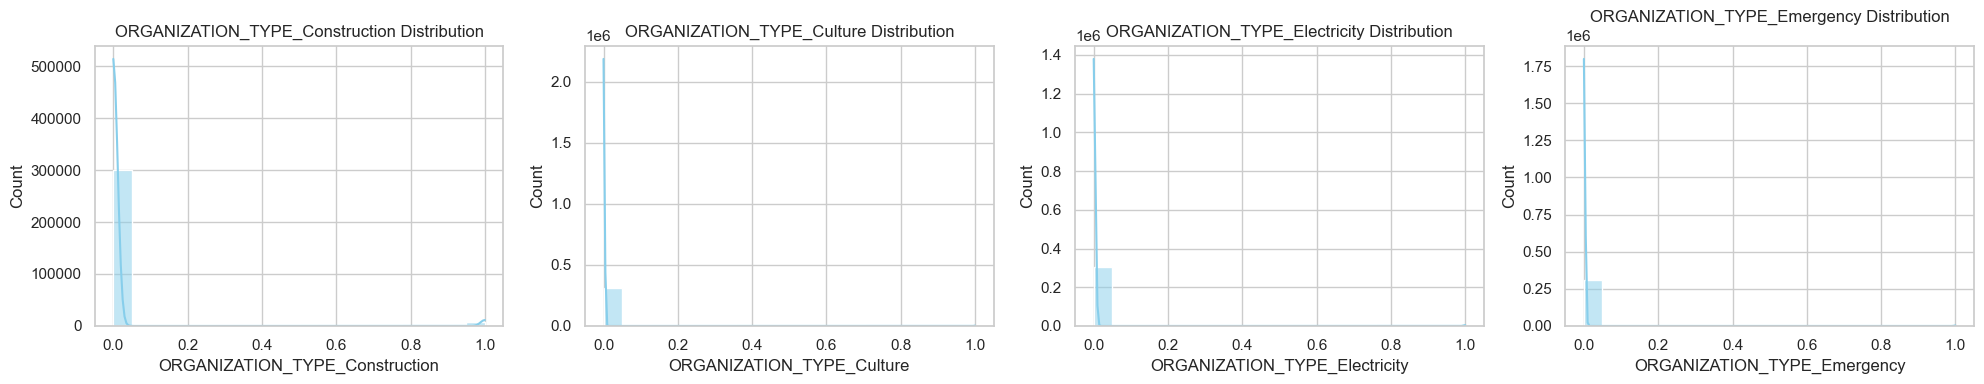

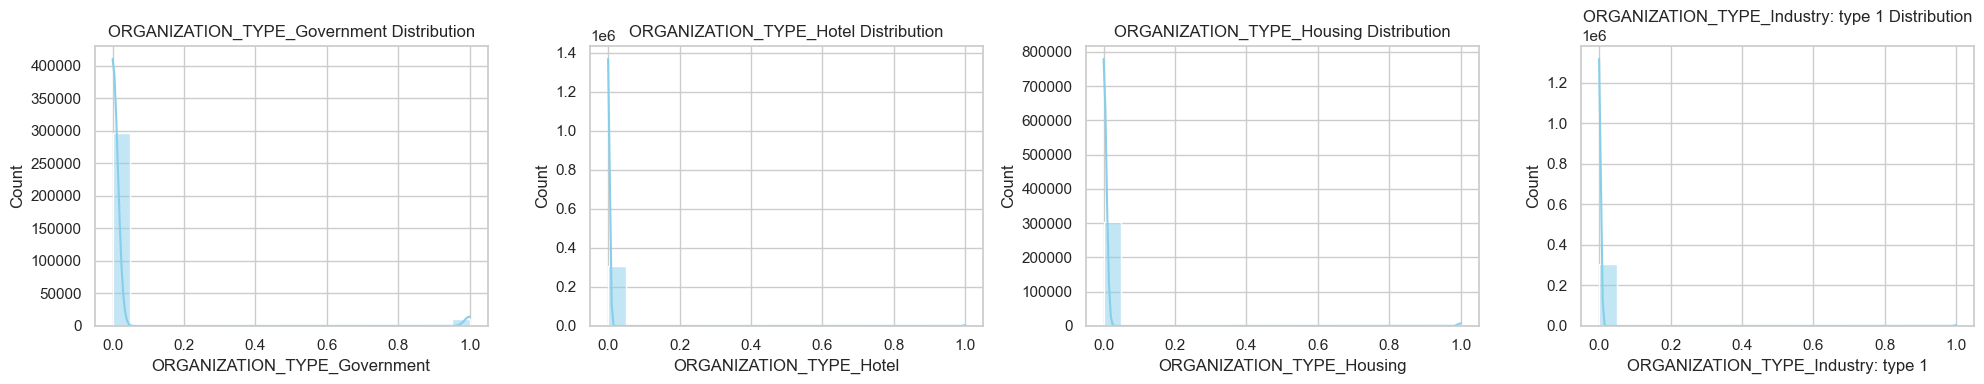

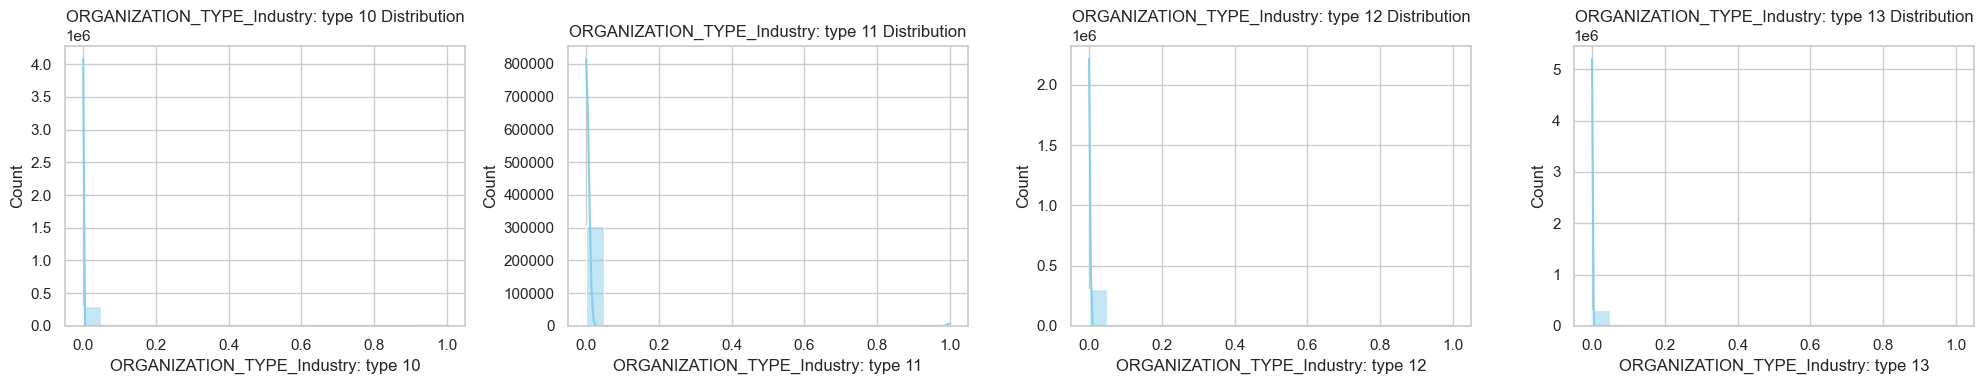

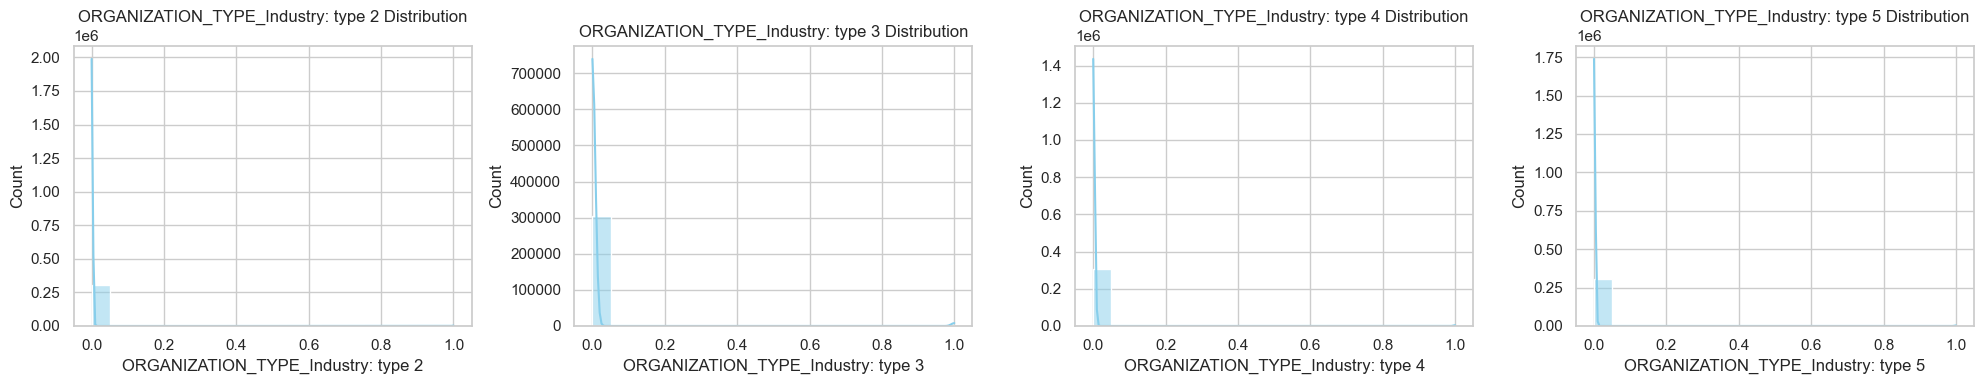

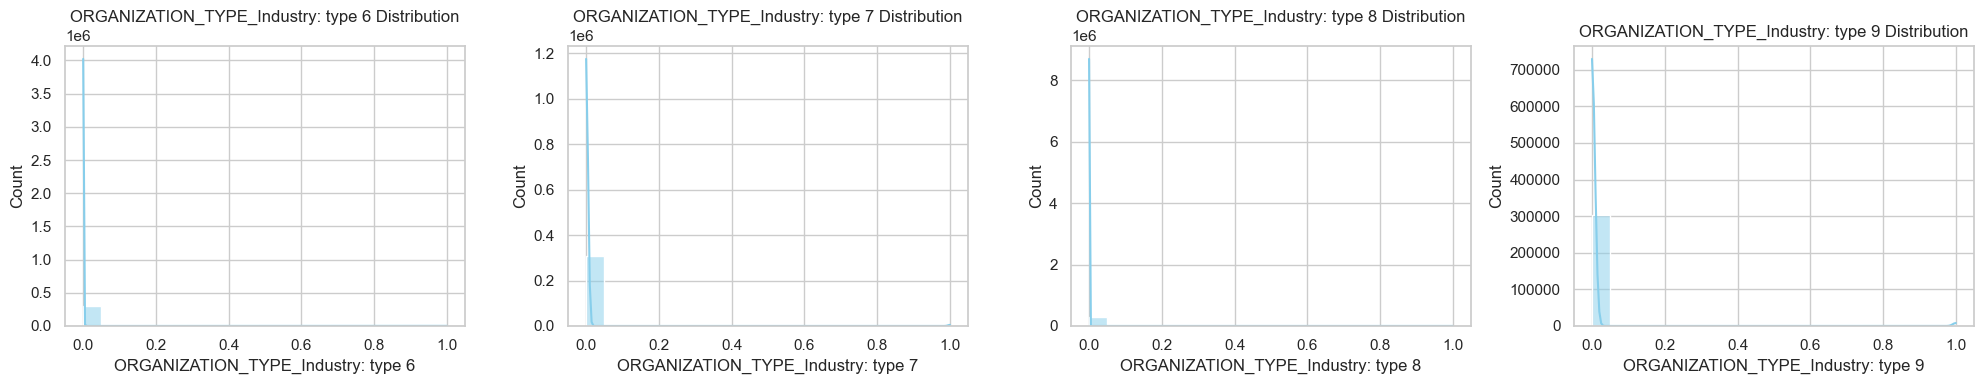

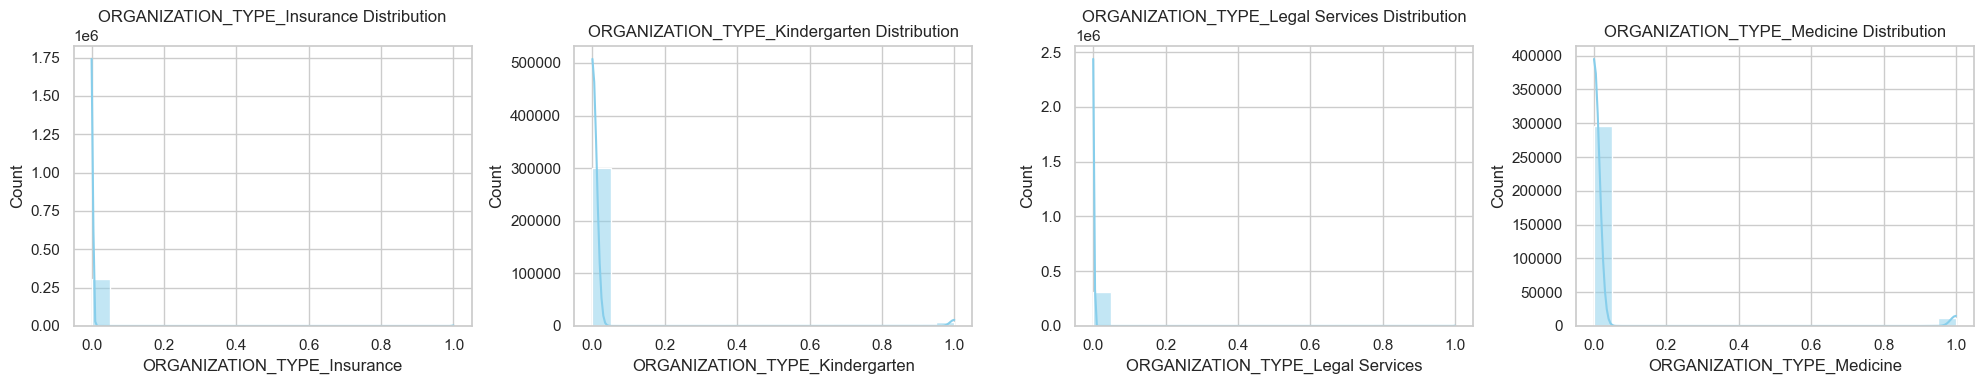

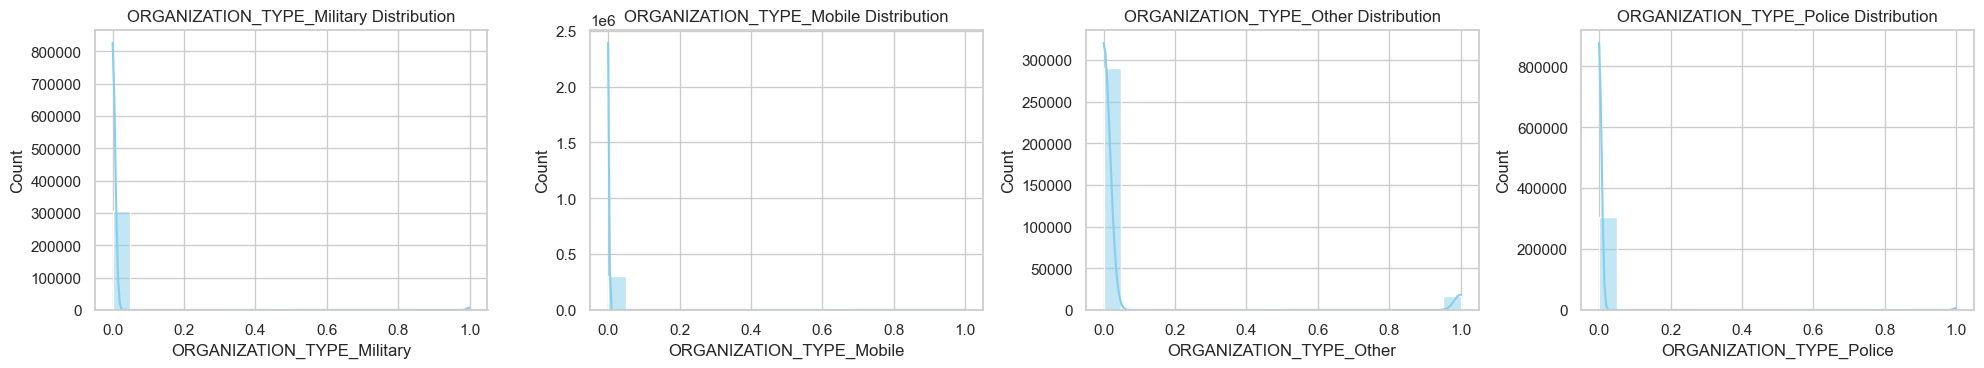

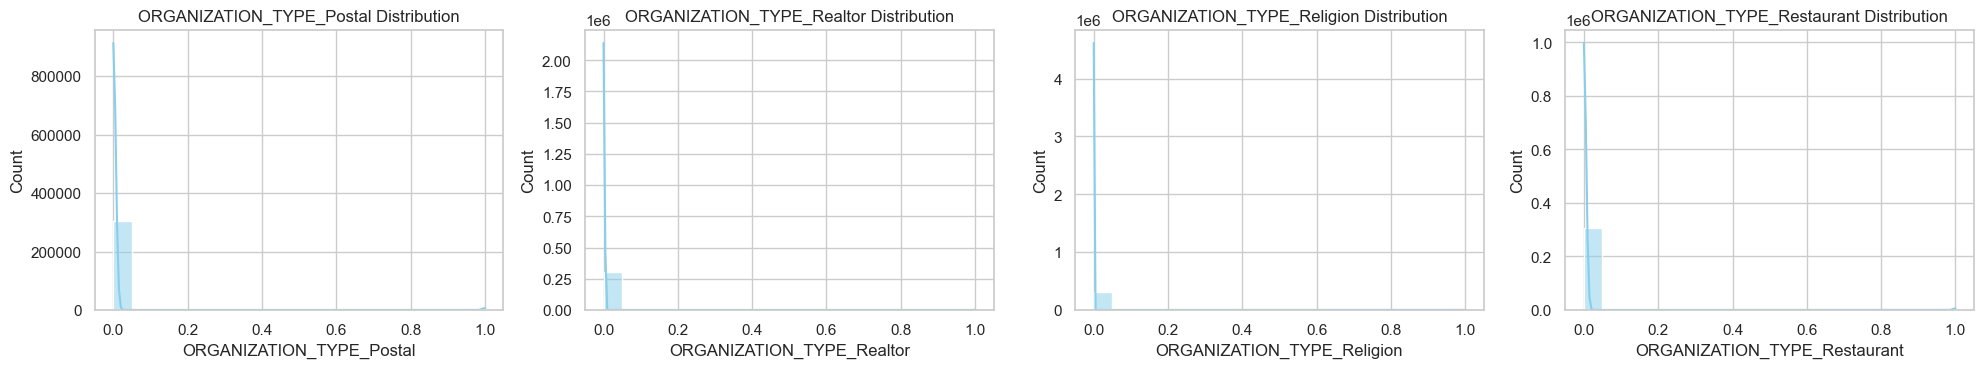

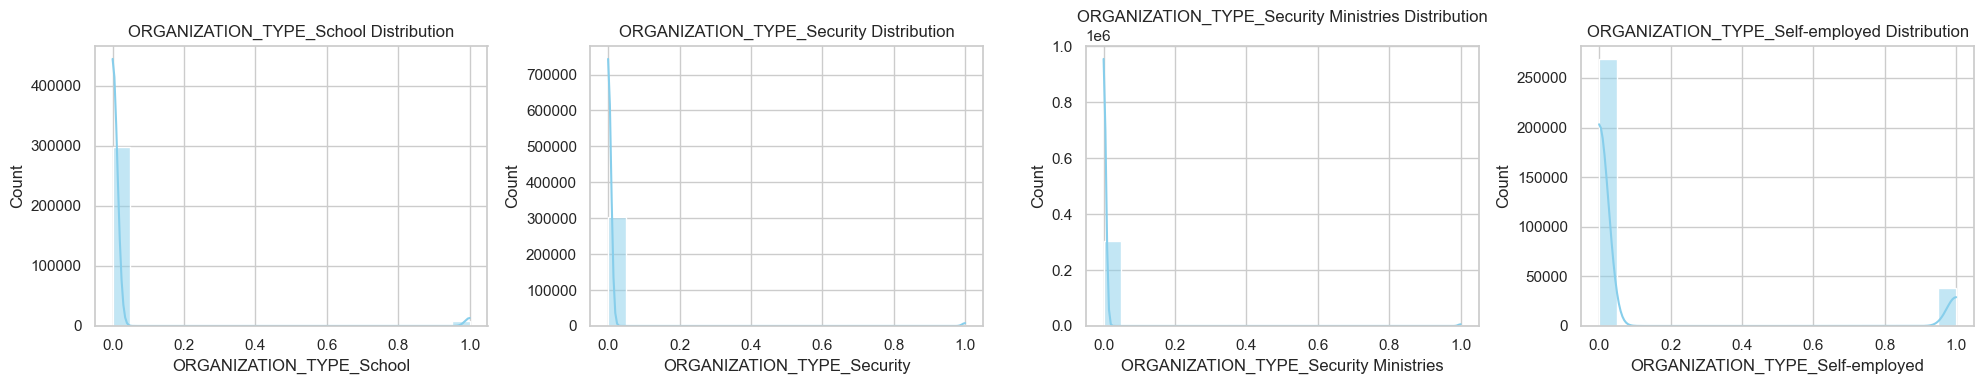

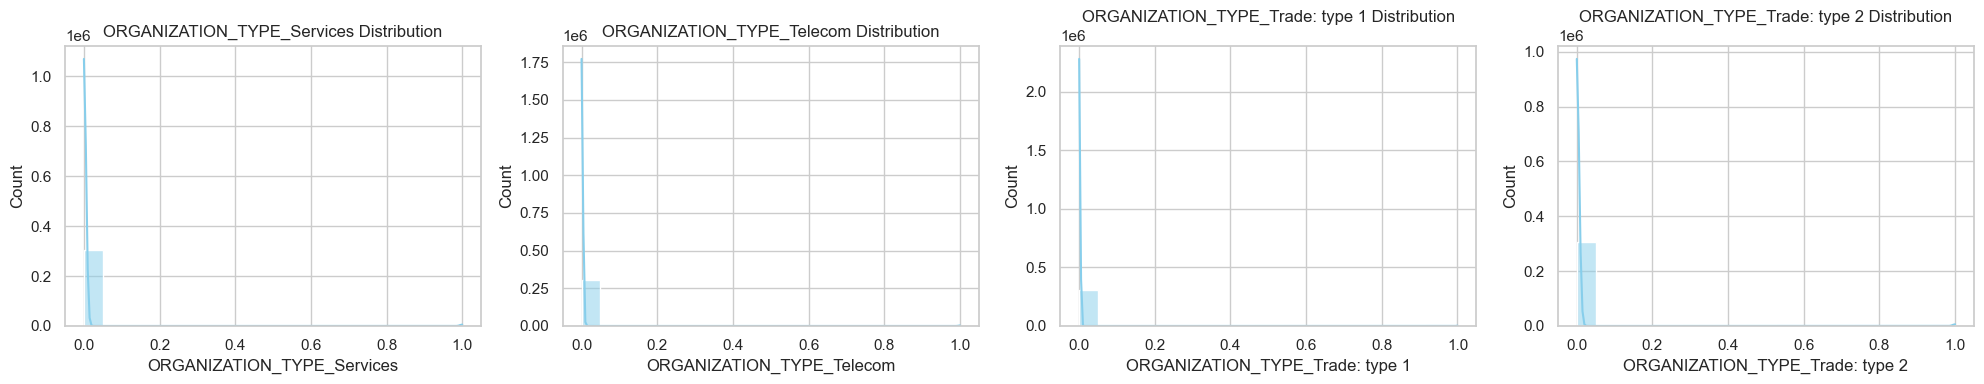

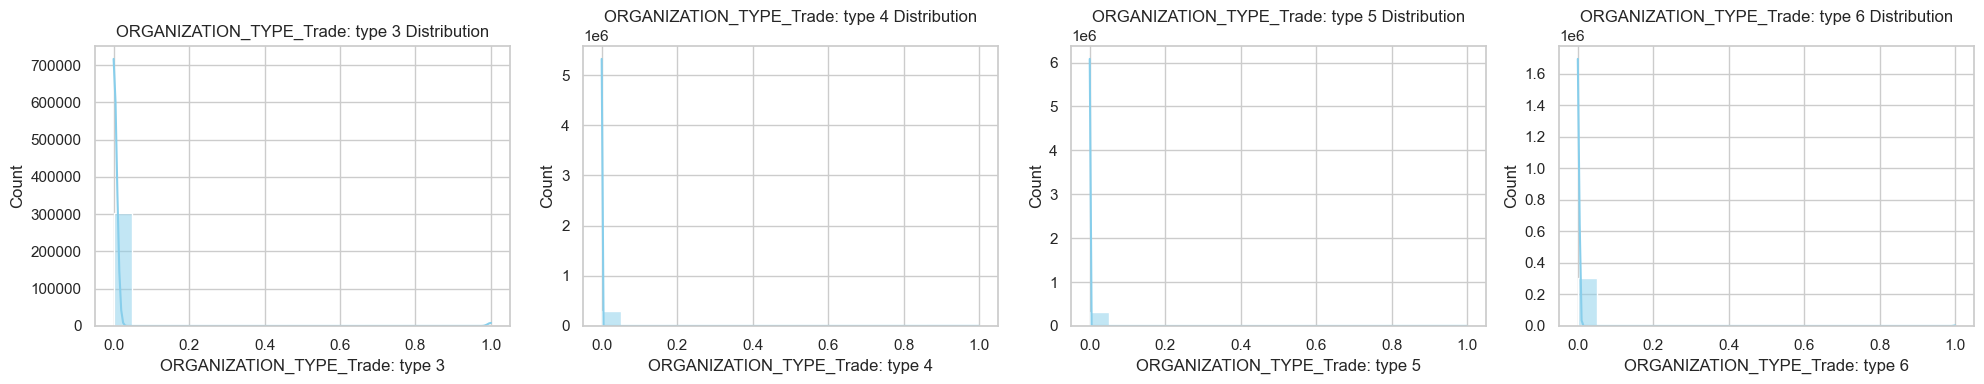

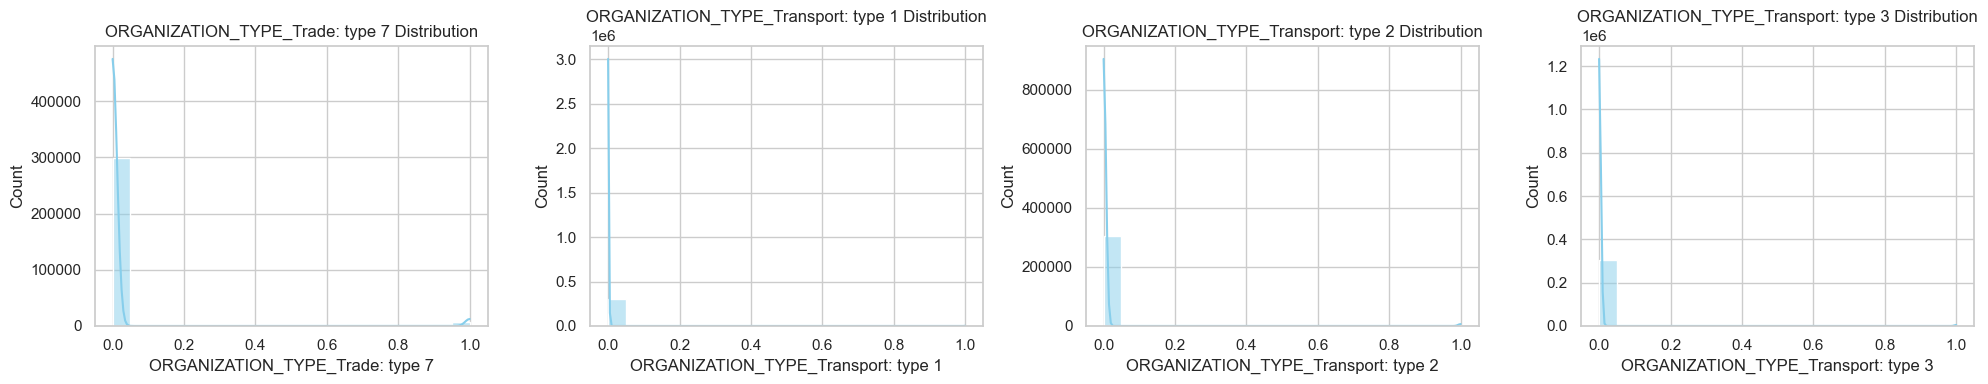

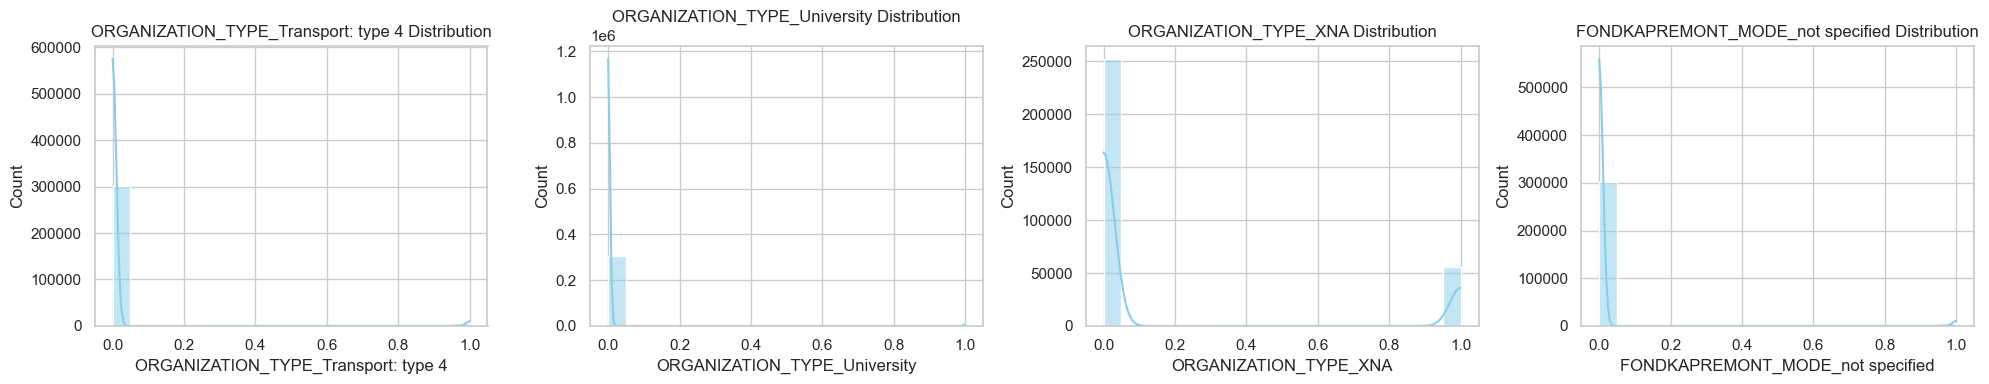

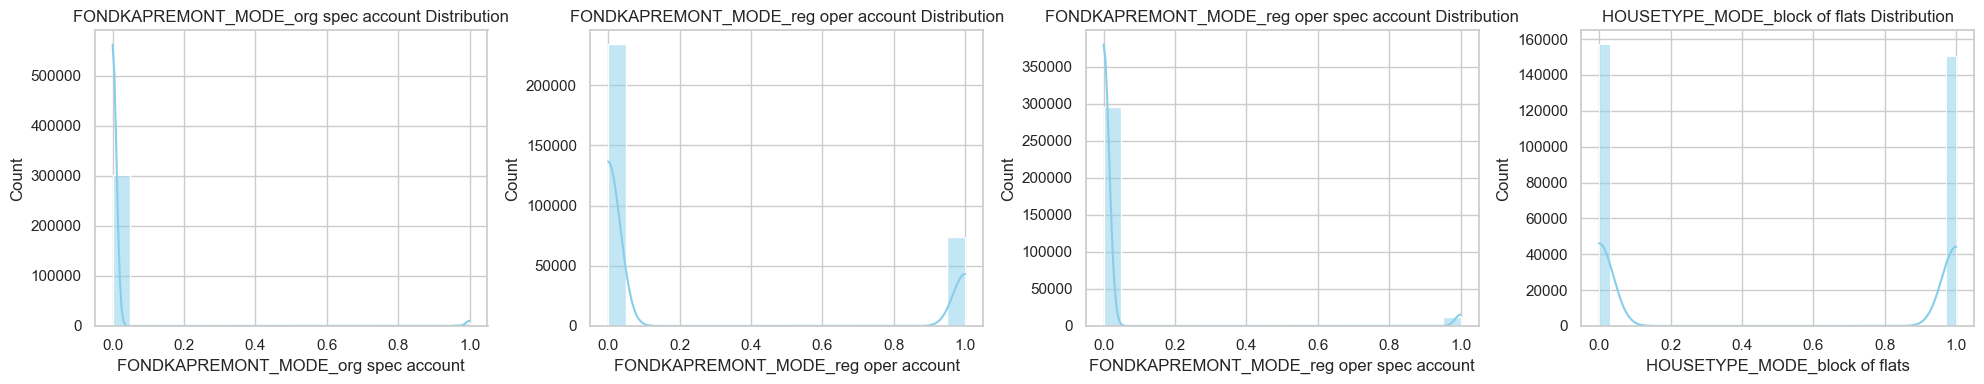

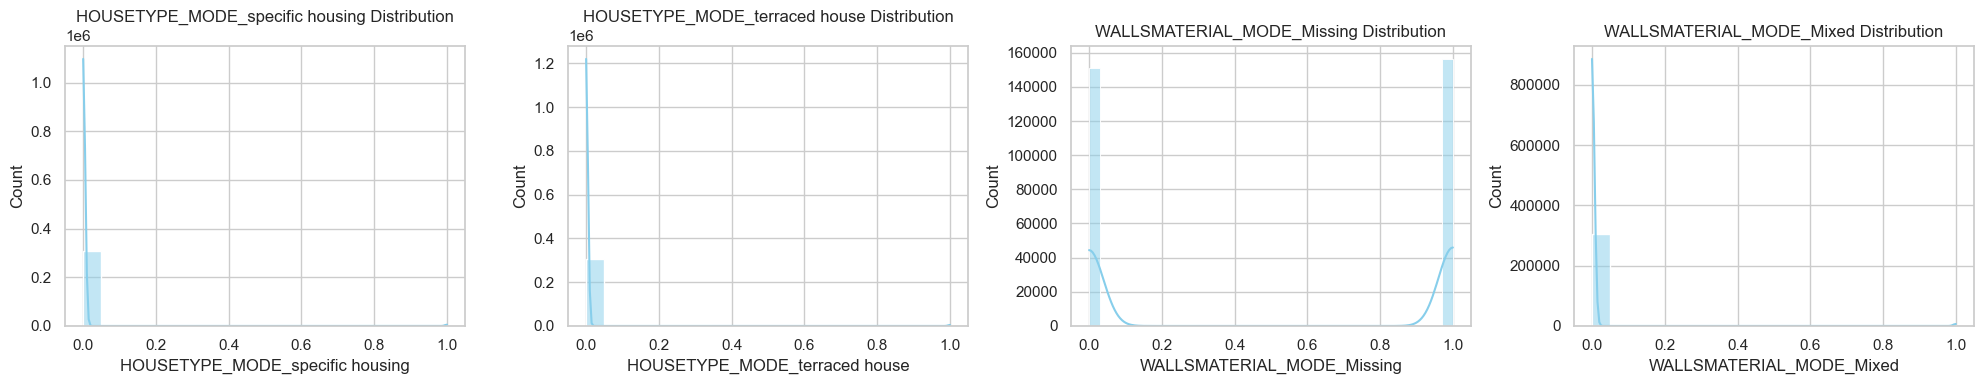

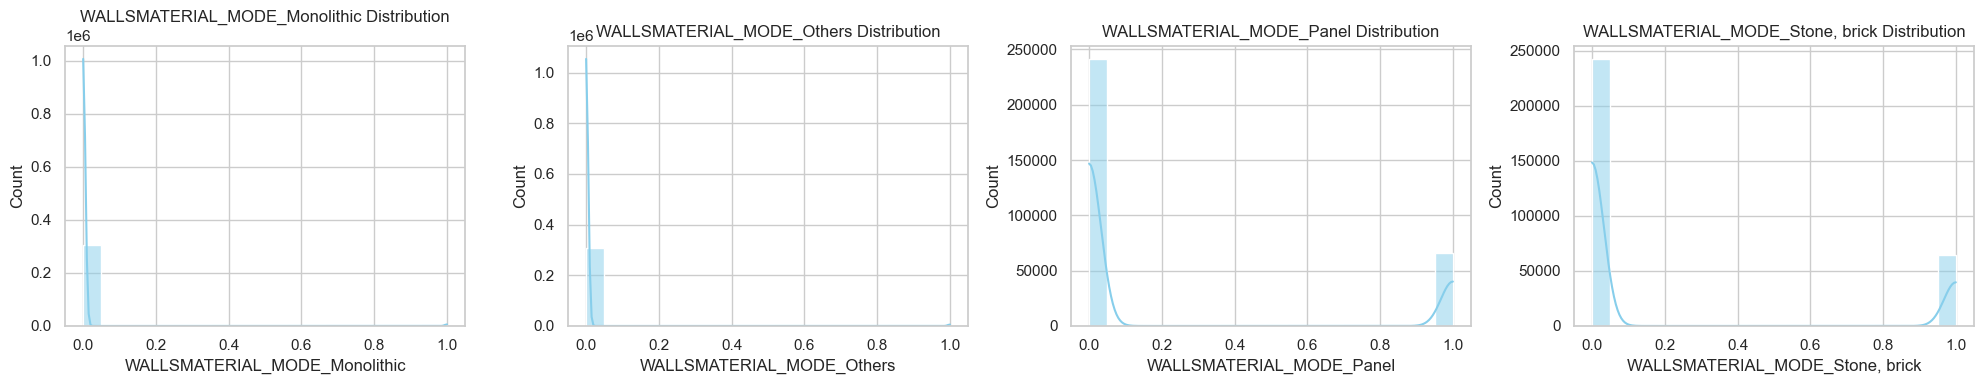

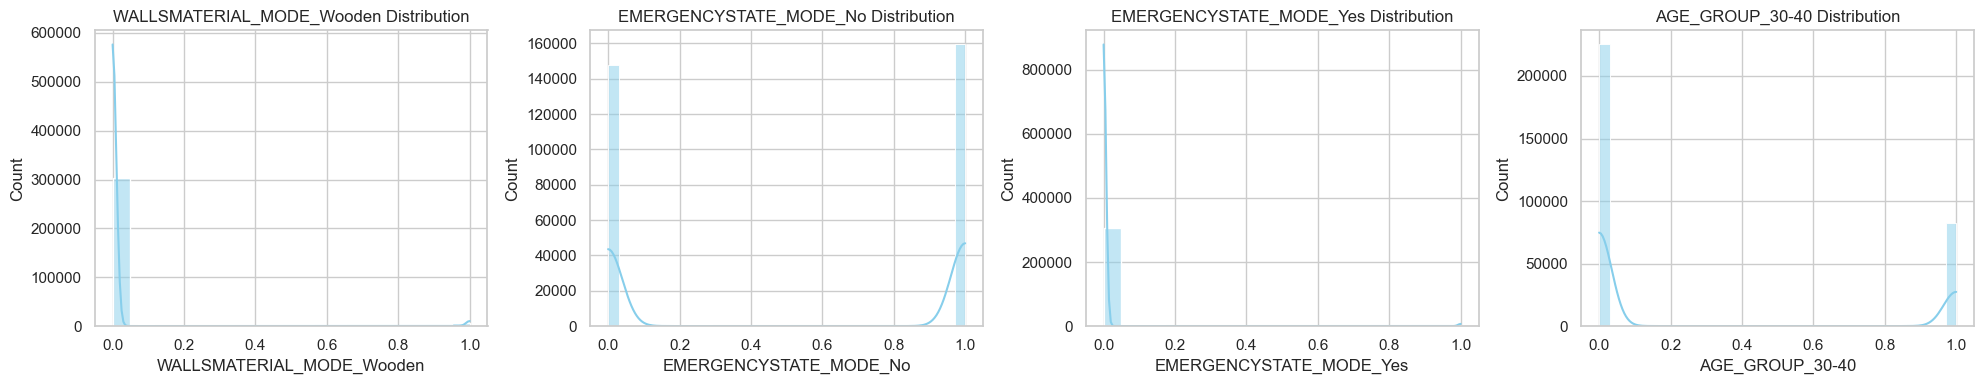

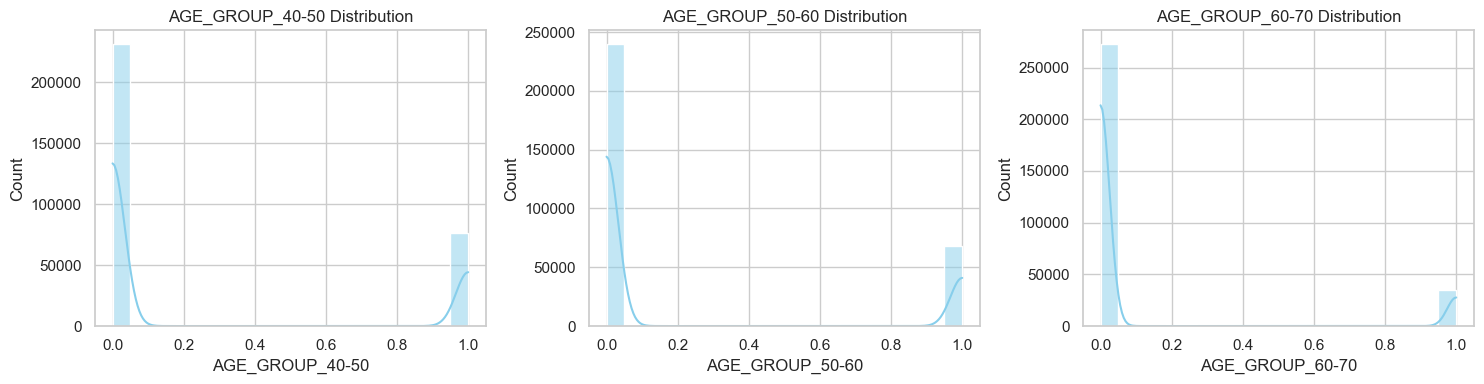

In [16]:

# Select numerical columns
num_cols = app_train.select_dtypes(include=[np.number]).columns

# Plot in batches of 4 features
batch_size = 4
for i in range(0, len(num_cols), batch_size):
    cols_batch = num_cols[i:i+batch_size]
    fig, axes = plt.subplots(1, len(cols_batch), figsize=(5*len(cols_batch), 4))
    
    if len(cols_batch) == 1:
        axes = [axes]  # Ensure axes is iterable
    
    for ax, col in zip(axes, cols_batch):
        sns.histplot(app_train[col], kde=True, color='skyblue', ax=ax)
        ax.set_title(f"{col} Distribution")
    
    plt.tight_layout()
    plt.show()



Categorical Feature Counts

In [17]:
import numpy as np
import pandas as pd

# 1) Define categorical-like columns from app_train (object + low-cardinality numeric)
cat_cols_app = app_train.select_dtypes(include=['object']).columns.tolist()
low_cardinality_app = [
    col for col in app_train.columns
    if app_train[col].dtype in ['int64', 'float64'] and app_train[col].nunique() <= 20
]
cat_cols_app = list(dict.fromkeys(cat_cols_app + low_cardinality_app))  # preserve order / dedupe

def summarize_categorical(df, cols, top_k=5):
    rows = []
    n = len(df)
    for col in cols:
        s = df[col]
        n_missing = s.isna().sum()
        pct_missing = n_missing / n * 100 if n else 0
        nunique = s.nunique(dropna=True)

        vc = s.value_counts(dropna=False)
        # Build a compact "top_k categories" string (excl. NaN label)
        vc_no_na = s.fillna("MISSING").value_counts()
        top_pairs = []
        for cat, cnt in vc_no_na.head(top_k).items():
            top_pairs.append(f"{cat}: {cnt} ({cnt/n:.1%})")
        top_str = "; ".join(top_pairs)

        # Most frequent (including missing as category)
        most_common_cat = vc_no_na.index[0] if len(vc_no_na) else None
        most_common_cnt = int(vc_no_na.iloc[0]) if len(vc_no_na) else 0
        most_common_pct = most_common_cnt / n * 100 if n else 0

        rows.append({
            "column": col,
            "n_unique": int(nunique),
            "missing_count": int(n_missing),
            "missing_pct": round(pct_missing, 2),
            "most_common": most_common_cat,
            "most_common_pct": round(most_common_pct, 2),
            f"top_{top_k}_sample": top_str
        })
    out = pd.DataFrame(rows).sort_values(["n_unique","missing_pct","column"]).reset_index(drop=True)
    return out

cat_summary_app = summarize_categorical(app_train, cat_cols_app, top_k=5)
cat_summary_app.head(30)

column  n_unique  missing_count  missing_pct  \
0           AGE_GROUP_30-40         2              0          0.0   
1           AGE_GROUP_40-50         2              0          0.0   
2           AGE_GROUP_50-60         2              0          0.0   
3           AGE_GROUP_60-70         2              0          0.0   
4             CODE_GENDER_M         2              0          0.0   
5       CODE_GENDER_Missing         2              0          0.0   
6    EMERGENCYSTATE_MODE_No         2              0          0.0   
7   EMERGENCYSTATE_MODE_Yes         2              0          0.0   
8          FLAG_CONT_MOBILE         2              0          0.0   
9          FLAG_DOCUMENT_10         2              0          0.0   
10         FLAG_DOCUMENT_11         2              0          0.0   
11         FLAG_DOCUMENT_12         2              0          0.0   
12         FLAG_DOCUMENT_13         2              0          0.0   
13         FLAG_DOCUMENT_14         2              0          0.0   
14         FLAG_DOCUMENT_15         2              0          0.0   
15         FLAG_DOCUMENT_16         2              0          0.0   
16         FLAG_DOCUMENT_17         2              0          0.0   
17         FLAG_DOCUMENT_18         2              0          0.0   
18         FLAG_DOCUMENT_19         2              0          0.0   
19          FLAG_DOCUMENT_2         2              0          0.0   
20         FLAG_DOCUMENT_20         2              0          0.0   
21         FLAG_DOCUMENT_21         2              0          0.0   
22          FLAG_DOCUMENT_3         2              0          0.0   
23          FLAG_DOCUMENT_4         2              0          0.0   
24          FLAG_DOCUMENT_5         2              0          0.0   
25          FLAG_DOCUMENT_6         2              0          0.0   
26          FLAG_DOCUMENT_7         2              0          0.0   
27          FLAG_DOCUMENT_8         2              0          0.0   
28          FLAG_DOCUMENT_9         2              0          0.0   
29               FLAG_EMAIL         2              0          0.0   

    most_common  most_common_pct                          top_5_sample  
0           0.0            73.23   0: 225196 (73.2%); 1: 82315 (26.8%)  
1           0.0            75.12   0: 231007 (75.1%); 1: 76504 (24.9%)  
2           0.0            77.87   0: 239444 (77.9%); 1: 68067 (22.1%)  
3           0.0            88.54   0: 272275 (88.5%); 1: 35236 (11.5%)  
4           0.0            65.84  0: 202452 (65.8%); 1: 105059 (34.2%)  
5           0.0           100.00       0: 307507 (100.0%); 1: 4 (0.0%)  
6           1.0            51.84  1: 159428 (51.8%); 0: 148083 (48.2%)  
7           0.0            99.24     0: 305183 (99.2%); 1: 2328 (0.8%)  
8           1.0            99.81      1: 306937 (99.8%); 0: 574 (0.2%)  
9           0.0           100.00       0: 307504 (100.0%); 1: 7 (0.0%)  
10          0.0            99.61     0: 306308 (99.6%); 1: 1203 (0.4%)  
11          0.0           100.00       0: 307509 (100.0%); 1: 2 (0.0%)  
12          0.0            99.65     0: 306427 (99.6%); 1: 1084 (0.4%)  
13          0.0            99.71      0: 306608 (99.7%); 1: 903 (0.3%)  
14          0.0            99.88      0: 307139 (99.9%); 1: 372 (0.1%)  
15          0.0            99.01     0: 304458 (99.0%); 1: 3053 (1.0%)  
16          0.0            99.97      0: 307429 (100.0%); 1: 82 (0.0%)  
17          0.0            99.19     0: 305011 (99.2%); 1: 2500 (0.8%)  
18          0.0            99.94      0: 307328 (99.9%); 1: 183 (0.1%)  
19          0.0           100.00      0: 307498 (100.0%); 1: 13 (0.0%)  
20          0.0            99.95      0: 307355 (99.9%); 1: 156 (0.1%)  
21          0.0            99.97     0: 307408 (100.0%); 1: 103 (0.0%)  
22          1.0            71.00   1: 218340 (71.0%); 0: 89171 (29.0%)  
23          0.0            99.99      0: 307486 (100.0%); 1: 25 (0.0%)  
24          0.0            98.49     0: 302863 (98.5%); 

Correlation Analysis

/var/folders/k1/2bt4tpbj41bbcqmsy0j43q_40000gn/T/ipykernel_1253/2887546588.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features_app, y=top_features_app.index, palette='coolwarm')


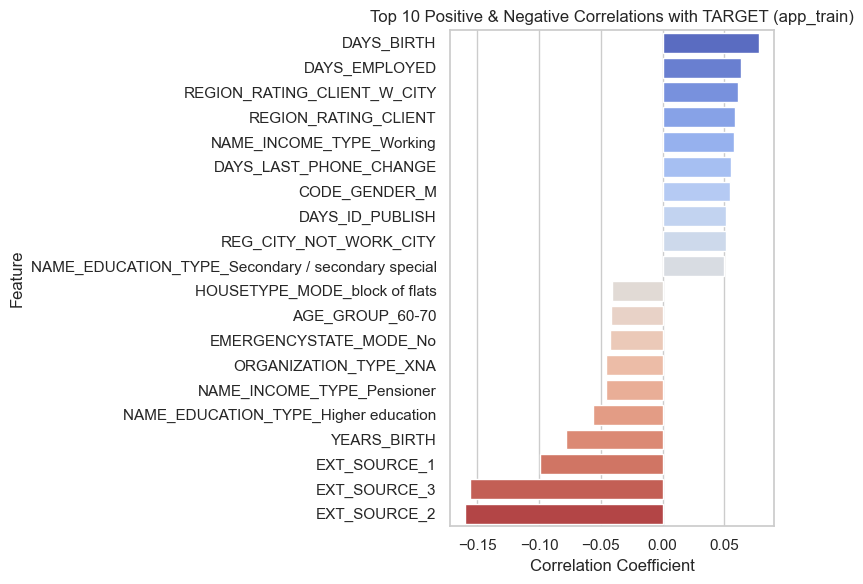

In [18]:
# Numeric-only dataframe from app_train
numeric_app = app_train.select_dtypes(include=[np.number])

# Ensure TARGET exists
assert 'TARGET' in numeric_app.columns, "TARGET not found in app_train"

# Correlation with TARGET
corr_with_target_app = numeric_app.corr(numeric_only=True)['TARGET'].sort_values(ascending=False)

# Drop self-correlation
corr_with_target_app = corr_with_target_app[corr_with_target_app.index != 'TARGET']

# Top +/- features
top_features_app = pd.concat([corr_with_target_app.head(10), corr_with_target_app.tail(10)])

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=top_features_app, y=top_features_app.index, palette='coolwarm')
plt.title("Top 10 Positive & Negative Correlations with TARGET (app_train)")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Feature vs TARGET Analysis

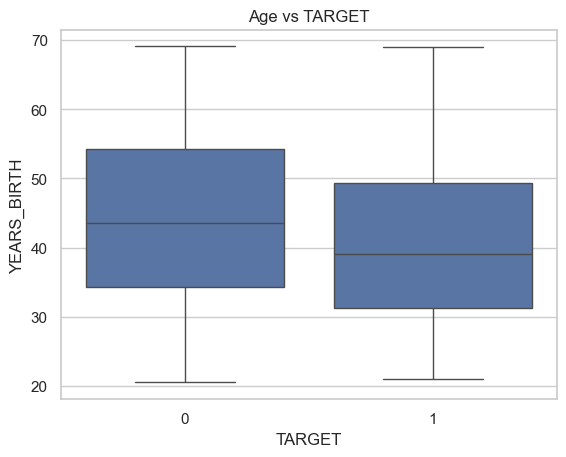

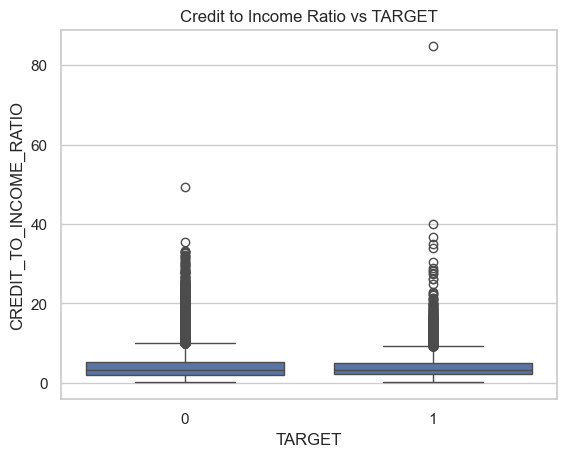

In [19]:
# Example: Age vs TARGET
sns.boxplot(data=app_train, x='TARGET', y='YEARS_BIRTH')
plt.title("Age vs TARGET")
plt.show()

# Example: Credit to Income Ratio vs TARGET
if 'CREDIT_TO_INCOME_RATIO' in app_train.columns:
    sns.boxplot(data=app_train, x='TARGET', y='CREDIT_TO_INCOME_RATIO')
    plt.title("Credit to Income Ratio vs TARGET")
    plt.show()


 Merge for Multi-Table EDA

merge for Bureau + Bureau Balance

In [20]:

# Load bureau_balance
bureau_bal = pd.read_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/bureau_balance_clean.csv")

# Downcast to save memory
for col in bureau_bal.select_dtypes(include=['float64']).columns:
    bureau_bal[col] = bureau_bal[col].astype('float32')
for col in bureau_bal.select_dtypes(include=['int64']).columns:
    bureau_bal[col] = bureau_bal[col].astype('int32')

# Aggregate at SK_ID_BUREAU level
bureau_bal_agg = bureau_bal.groupby('SK_ID_BUREAU').agg(['mean']).reset_index()

# Flatten multiindex columns
bureau_bal_agg.columns = ["_".join(col).strip("_") for col in bureau_bal_agg.columns.values]
bureau_bal_agg.rename(columns={"SK_ID_BUREAU_": "SK_ID_BUREAU"}, inplace=True)

print("Bureau Balance Aggregated Shape:", bureau_bal_agg.shape)

# Load bureau
bureau = pd.read_csv("bureau_clean.csv")

# Downcast
for col in bureau.select_dtypes(include=['float64']).columns:
    bureau[col] = bureau[col].astype('float32')
for col in bureau.select_dtypes(include=['int64']).columns:
    bureau[col] = bureau[col].astype('int32')

# Merge with bureau_balance aggregation
bureau_full = bureau.merge(bureau_bal_agg, on="SK_ID_BUREAU", how="left")

print("Bureau + Bureau Balance Shape:", bureau_full.shape)

# Aggregate all numeric columns to SK_ID_CURR level
bureau_agg = bureau_full.groupby("SK_ID_CURR").agg(['mean']).reset_index()

# Flatten multiindex columns
bureau_agg.columns = ["_".join(col).strip("_") for col in bureau_agg.columns.values]
bureau_agg.rename(columns={"SK_ID_CURR_": "SK_ID_CURR"}, inplace=True)

print("Final Bureau Aggregated Shape:", bureau_agg.shape)

# Save for later merging
#bureau_agg.to_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/bureau_agg.csv", index=False)


Bureau Balance Aggregated Shape: (817395, 9)
Bureau + Bureau Balance Shape: (1716428, 44)
Final Bureau Aggregated Shape: (305811, 44)


previous_application

In [21]:

file_path = "/Users/bella/Downloads/Home credit /home-credit-default-risk/previous_application_clean.csv"

# Step 1: infer column dtypes in advance (only once)
sample = pd.read_csv(file_path, nrows=5000)

dtypes = {}
for col in sample.columns:
    if sample[col].dtype == "float64":
        dtypes[col] = "float32"
    elif sample[col].dtype == "int64":
        dtypes[col] = "int32"

# Step 2: now read in chunks with optimized dtypes
chunk_size = 200000
agg_list = []

for i, chunk in enumerate(pd.read_csv(file_path, chunksize=chunk_size, dtype=dtypes)):
    print(f"Processing chunk {i+1}...")

    # Only keep numeric cols
    num_cols = chunk.select_dtypes(include=["float32", "int32"]).columns

    # Aggregate immediately
    chunk_agg = chunk.groupby("SK_ID_CURR")[num_cols].mean()

    # Append result
    agg_list.append(chunk_agg)

# Step 3: combine all
prev_agg = pd.concat(agg_list)

# Step 4: If SK_ID_CURR is in the index, remove it without creating a duplicate column
if 'SK_ID_CURR' in prev_agg.index.names:
    prev_agg = prev_agg.reset_index(drop=True)

# Step 5: Group and aggregate safely
prev_agg = prev_agg.groupby("SK_ID_CURR", as_index=False).mean()

print("Previous Application Aggregated Shape:", prev_agg.shape)
#prev_agg.to_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/previous_application_agg.csv", index=False)

Processing chunk 1...
Processing chunk 2...
Processing chunk 3...
Processing chunk 4...
Processing chunk 5...
Processing chunk 6...
Processing chunk 7...
Processing chunk 8...
Processing chunk 9...
Previous Application Aggregated Shape: (338857, 152)


POS_CASH Balance

In [22]:
# Load POS_CASH_balance
pos = pd.read_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/POS_CASH_balance_clean.csv")

# Downcast
for col in pos.select_dtypes(include=['float64']).columns:
    pos[col] = pos[col].astype('float32')
for col in pos.select_dtypes(include=['int64']).columns:
    pos[col] = pos[col].astype('int32')

# Aggregate at SK_ID_CURR level
pos_agg = pos.groupby("SK_ID_CURR").agg(['mean']).reset_index()

# Flatten columns
pos_agg.columns = ["_".join(col).strip("_") for col in pos_agg.columns.values]
pos_agg.rename(columns={"SK_ID_CURR_": "SK_ID_CURR"}, inplace=True)

print("POS_CASH Aggregated Shape:", pos_agg.shape)

#pos_agg.to_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/pos_cash_agg.csv", index=False)


POS_CASH Aggregated Shape: (337252, 15)


Credit Card Balance

In [23]:
# Load credit_card_balance
cc = pd.read_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/credit_card_balance_clean.csv")

# Downcast
for col in cc.select_dtypes(include=['float64']).columns:
    cc[col] = cc[col].astype('float32')
for col in cc.select_dtypes(include=['int64']).columns:
    cc[col] = cc[col].astype('int32')

# Aggregate at SK_ID_CURR level
cc_agg = cc.groupby("SK_ID_CURR").agg(['mean']).reset_index()

# Flatten columns
cc_agg.columns = ["_".join(col).strip("_") for col in cc_agg.columns.values]
cc_agg.rename(columns={"SK_ID_CURR_": "SK_ID_CURR"}, inplace=True)

print("Credit Card Aggregated Shape:", cc_agg.shape)

#cc_agg.to_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/credit_card_agg.csv", index=False)


Credit Card Aggregated Shape: (103558, 28)


Installments Payments

In [24]:
# Load installments_payments
inst = pd.read_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/installments_payments_clean.csv")

# Downcast
for col in inst.select_dtypes(include=['float64']).columns:
    inst[col] = inst[col].astype('float32')
for col in inst.select_dtypes(include=['int64']).columns:
    inst[col] = inst[col].astype('int32')

# Aggregate at SK_ID_CURR level
inst_agg = inst.groupby("SK_ID_CURR").agg(['mean']).reset_index()

# Flatten columns
inst_agg.columns = ["_".join(col).strip("_") for col in inst_agg.columns.values]
inst_agg.rename(columns={"SK_ID_CURR_": "SK_ID_CURR"}, inplace=True)

print("Installments Aggregated Shape:", inst_agg.shape)

#inst_agg.to_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/installments_agg.csv", index=False)


Installments Aggregated Shape: (339587, 8)


In [ ]:

# -------------------------
# Step 1: Load application data
# -------------------------
app_train = pd.read_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/application_train_clean.csv")
app_test  = pd.read_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/application_test_clean.csv")

print("Train shape:", app_train.shape)
print("Test shape:", app_test.shape)

# -------------------------
# Step 2: Load aggregated tables
# -------------------------
bureau_agg       = pd.read_csv("bureau_agg.csv")
prev_agg         = pd.read_csv("previous_application_agg.csv")
pos_cash_agg     = pd.read_csv("pos_cash_agg.csv")
credit_card_agg  = pd.read_csv("credit_card_agg.csv")
installments_agg = pd.read_csv("installments_agg.csv")

# -------------------------
# Step 3: Merge them into train
# -------------------------
train_merged = app_train.copy()

for df, name in zip(
    [bureau_agg, prev_agg, pos_cash_agg, credit_card_agg, installments_agg],
    ["bureau", "previous", "pos_cash", "credit_card", "installments"]
):
    print(f"Merging {name} ... before:", train_merged.shape)
    train_merged = train_merged.merge(df, on="SK_ID_CURR", how="left")
    print(f"After {name} merge:", train_merged.shape)

# -------------------------
# Step 4: Merge them into test
# -------------------------
test_merged = app_test.copy()

for df, name in zip(
    [bureau_agg, prev_agg, pos_cash_agg, credit_card_agg, installments_agg],
    ["bureau", "previous", "pos_cash", "credit_card", "installments"]
):
    print(f"Merging {name} ... before:", test_merged.shape)
    test_merged = test_merged.merge(df, on="SK_ID_CURR", how="left")
    print(f"After {name} merge:", test_merged.shape)

# -------------------------
# Step 5: Save merged datasets
# -------------------------
#train_merged.to_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/train_final.csv", index=False)
#test_merged.to_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/test_final.csv", index=False)

print("✅ Final merged datasets saved: train_final.csv & test_final.csv")


Train shape: (307511, 243)
Test shape: (48744, 8100)
Merging bureau ... before: (307511, 243)
After bureau merge: (307511, 286)
Merging previous ... before: (307511, 286)
After previous merge: (307511, 437)
Merging pos_cash ... before: (307511, 437)
After pos_cash merge: (307511, 451)
Merging credit_card ... before: (307511, 451)
After credit_card merge: (307511, 478)
Merging installments ... before: (307511, 478)
After installments merge: (307511, 485)
Merging bureau ... before: (48744, 8100)
After bureau merge: (48744, 8143)
Merging previous ... before: (48744, 8143)
After previous merge: (48744, 8294)
Merging pos_cash ... before: (48744, 8294)
After pos_cash merge: (48744, 8308)
Merging credit_card ... before: (48744, 8308)
After credit_card merge: (48744, 8335)
Merging installments ... before: (48744, 8335)
After installments merge: (48744, 8342)
✅ Final merged datasets saved: train_final.csv & test_final.csv


: 

EDA + Baseline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, confusion_matrix, classification_report

import lightgbm as lgb

In [2]:
# Load cleaned + merged datasets
train = pd.read_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/train_final.csv")
test = pd.read_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/test_final.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

train.head()


Train shape: (307511, 485)
Test shape: (48744, 8342)


SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT_x  \
0      100002       1             0          202500.0      406597.5   
1      100003       0             0          270000.0     1293502.5   
2      100004       0             0           67500.0      135000.0   
3      100006       0             0          135000.0      312682.5   
4      100007       0             0          121500.0      513000.0   

   AMT_ANNUITY_x  AMT_GOODS_PRICE_x  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0        24700.5           351000.0                    0.018801     -9461.0   
1        35698.5          1129500.0                    0.003541    -16765.0   
2         6750.0           135000.0                    0.010032    -19046.0   
3        29686.5           297000.0                    0.008019    -19005.0   
4        21865.5           513000.0                    0.028663    -19932.0   

   DAYS_EMPLOYED  ...  NAME_CONTRACT_STATUS_Refused_mean  \
0         -637.0  ...                                NaN   
1        -1188.0  ...                                NaN   
2         -225.0  ...                                NaN   
3        -3039.0  ...                                0.0   
4        -3038.0  ...                                NaN   

   NAME_CONTRACT_STATUS_Sent proposal_mean  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      0.0   
4                                      NaN   

   NAME_CONTRACT_STATUS_Signed_mean_y  SK_ID_PREV_mean  \
0                                 NaN     1.038818e+06   
1                                 NaN     2.290070e+06   
2                                 NaN     1.564014e+06   
3                                 0.0     2.217428e+06   
4                                 NaN     2.048985e+06   

   NUM_INSTALMENT_VERSION_mean  NUM_INSTALMENT_NUMBER_mean  \
0                     1.052632                   10.000000   
1                     1.040000                    5.080000   
2                     1.333333                    2.000000   
3                     1.125000                    4.437500   
4                     1.166667                    7.045455   

   DAYS_INSTALMENT_mean  DAYS_ENTRY_PAYMENT_mean  AMT_INSTALMENT_mean  \
0             -295.0000               -315.42105            11559.247   
1            -1378.1600              -1385.32000            64754.586   
2             -754.0000               -761.66670             7096.155   
3             -252.2500               -271.62500            62947.086   
4            -1028.6061              -1032.24240            12666.444   

   AMT_PAYMENT_mean  
0         11559.247  
1         64754.586  
2          7096.155  
3         62947.086  
4         12214.061  

[5 rows x 485 columns]

Feature Distributions by TARGET

0    91.927118
1     8.072882
Name: TARGET, dtype: float64


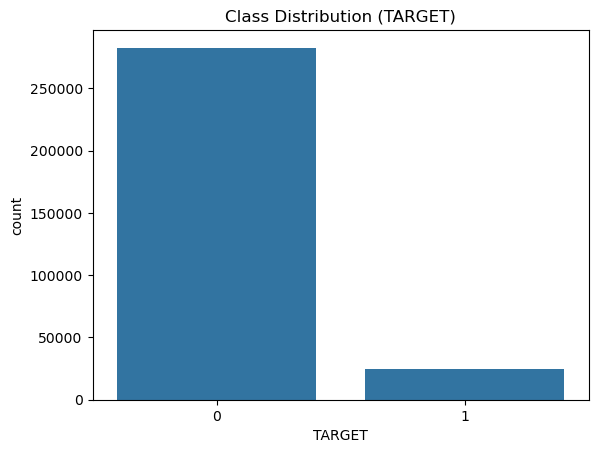

In [3]:
# TARGET distribution
target_counts = train["TARGET"].value_counts(normalize=True) * 100
print(target_counts)

sns.countplot(data=train, x="TARGET")
plt.title("Class Distribution (TARGET)")
plt.show()


Feature Distributions by TARGET

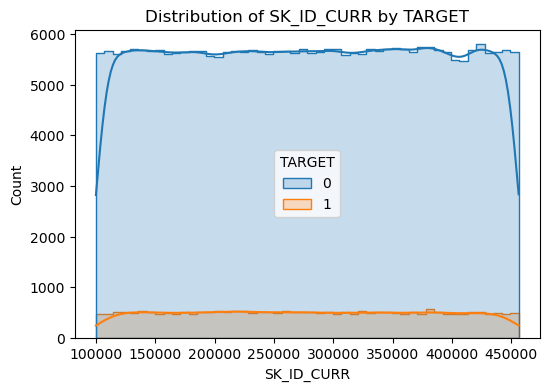

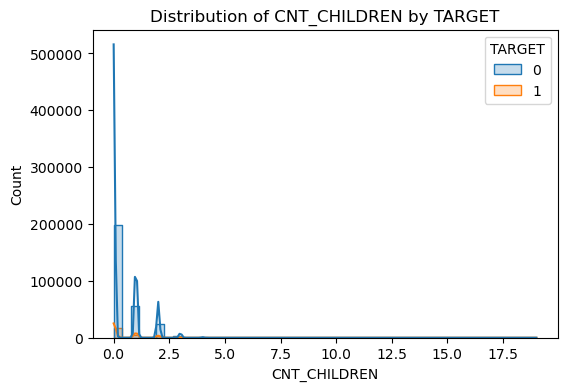

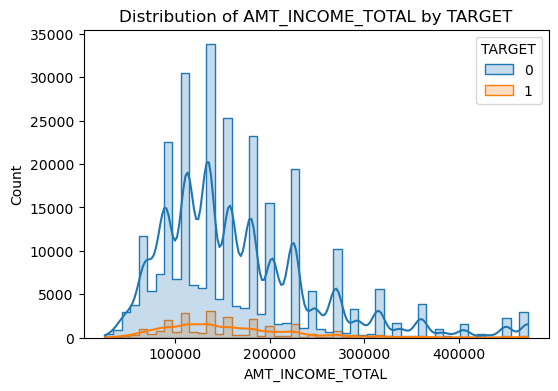

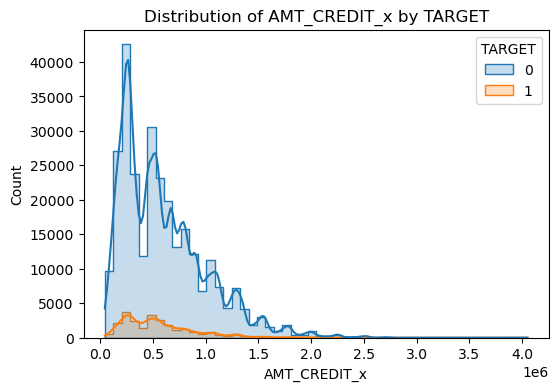

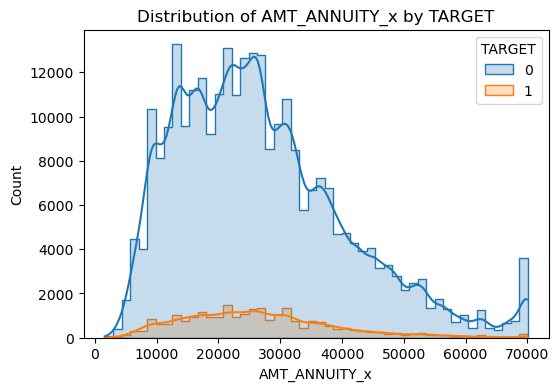

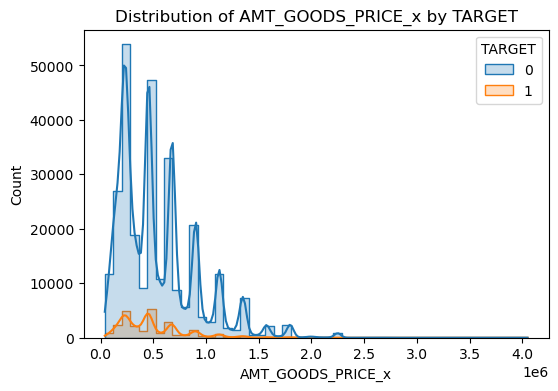

In [4]:
# Select a few numeric columns for distribution check
num_cols = train.select_dtypes(include=["int64","float64"]).columns.drop("TARGET")

for col in num_cols[:6]:  # first 6 to avoid clutter
    plt.figure(figsize=(6,4))
    sns.histplot(data=train, x=col, hue="TARGET", kde=True, bins=50, element="step")
    plt.title(f"Distribution of {col} by TARGET")
    plt.show()


Subgroup Counts (Gender & Age)

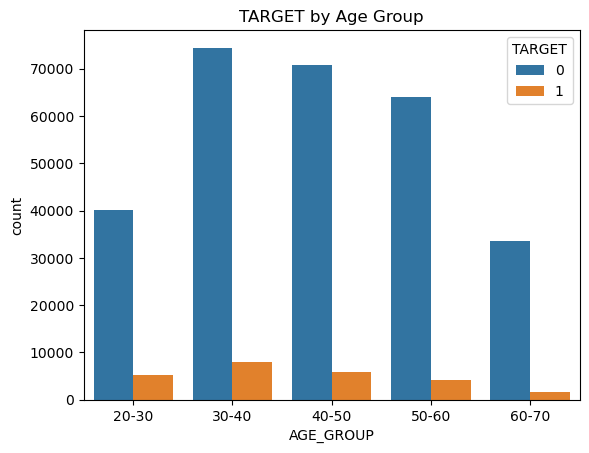

In [5]:
# Gender counts
if "CODE_GENDER" in train.columns:
    sns.countplot(data=train, x="CODE_GENDER", hue="TARGET")
    plt.title("TARGET by Gender")
    plt.show()

# Age bands (if YEARS_BIRTH exists)
if "YEARS_BIRTH" in train.columns:
    train["AGE_GROUP"] = pd.cut(train["YEARS_BIRTH"], bins=[20,30,40,50,60,70], labels=["20-30","30-40","40-50","50-60","60-70"])
    sns.countplot(data=train, x="AGE_GROUP", hue="TARGET")
    plt.title("TARGET by Age Group")
    plt.show()


Baseline Logistic Regression and Baseline LightGBM

In [6]:

import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from lightgbm import LGBMClassifier

# 0) Separate features/target
X = train.drop(columns=["TARGET"]).copy()
y = train["TARGET"].astype(int)

# 1) Identify categorical & numeric
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.columns.difference(cat_cols)

# 2) One-hot encode categoricals (handle older sklearn)
try:
    encoder = OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False)
except TypeError:
    encoder = OneHotEncoder(drop="first", handle_unknown="ignore", sparse=False)

X_cat = pd.DataFrame(
    encoder.fit_transform(X[cat_cols]),
    columns=encoder.get_feature_names_out(cat_cols),
    index=X.index
)

# 3) Combine with numeric
X_num = X[num_cols].copy()
X = pd.concat([X_num, X_cat], axis=1)

# 4) Sanitize feature names (no spaces, slashes, dashes, etc.)
def sanitize_cols(cols):
    out, seen = [], set()
    for c in cols:
        safe = re.sub(r'[^A-Za-z0-9_]+', '_', str(c))
        safe = re.sub(r'_+', '_', safe).strip('_')
        base = safe or "col"
        i = 1
        while safe in seen:
            safe = f"{base}_{i}"; i += 1
        seen.add(safe); out.append(safe)
    return out

X.columns = sanitize_cols(X.columns)

# 5) Clean numerics (no inf/NaN)
X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median(numeric_only=True))

# 6) Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 7) Train LightGBM (sklearn API avoids the callback quirks)
lgbm = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    num_leaves=31,
    class_weight="balanced",
    random_state=42
)
lgbm.fit(X_train, y_train)

# 8) Evaluate
y_proba = lgbm.predict_proba(X_val)[:, 1]
y_pred  = (y_proba >= 0.5).astype(int)
print("AUC:", roc_auc_score(y_val, y_proba))
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))

AUC: 0.7781157800026268
Accuracy: 0.7568411297009902
Precision: 0.19568660899232362
Recall: 0.6469284994964754


Save Baseline features

In [7]:
import json

# Collect results
baseline_results = {
    "Model": "LightGBM (baseline)",
    "AUC": roc_auc_score(y_val, y_proba),
    "Accuracy": accuracy_score(y_val, y_pred),
    "Precision": precision_score(y_val, y_pred),
    "Recall": recall_score(y_val, y_pred)
}

# === Save to CSV ===
import pandas as pd
#pd.DataFrame([baseline_results]).to_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/baseline_results.csv", index=False)

# === Save to JSON ===
#with open("baseline_results.json", "w") as f:
   # json.dump(baseline_results, f, indent=4)

print("Baseline results saved as baseline_results.csv and baseline_results.json")

Baseline results saved as baseline_results.csv and baseline_results.json


Evaluation of Baseline Models

/Users/bella/opt/anaconda3/envs/creditfair/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


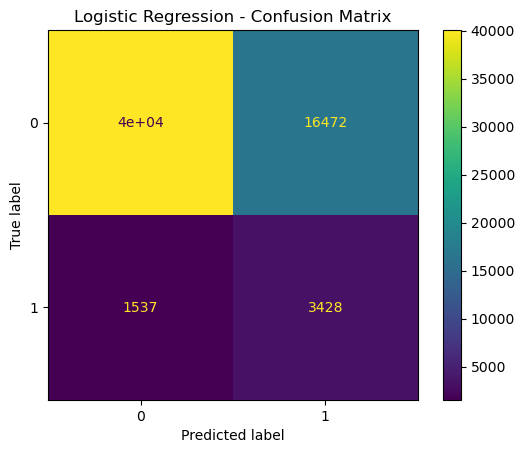

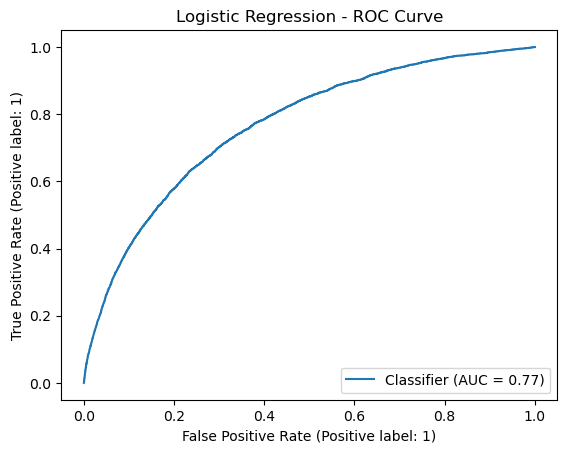

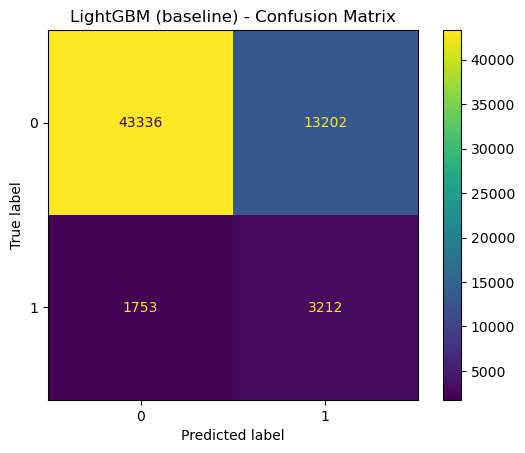

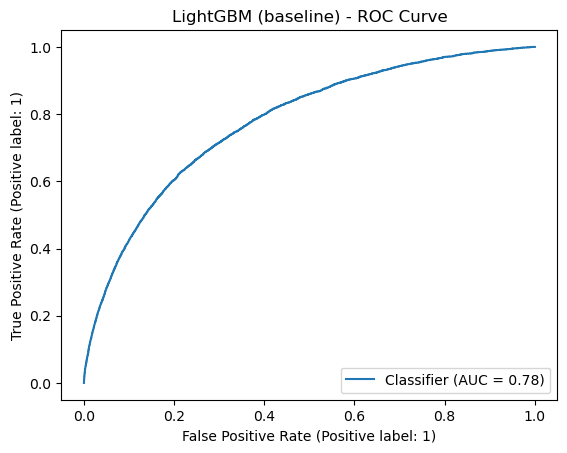

                 Model       AUC  Accuracy  Precision    Recall
0  Logistic Regression  0.767112  0.707185   0.172261  0.690433
1  LightGBM (baseline)  0.778116  0.756841   0.195687  0.646928


In [8]:
# Train Logistic Regression now, then evaluate both models
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    ConfusionMatrixDisplay, RocCurveDisplay
)
import matplotlib.pyplot as plt
import pandas as pd, json

# scale numeric features for LR (use the already-split X_train, X_val, y_train, y_val)
scaler = StandardScaler()
X_train_lr = scaler.fit_transform(X_train)
X_val_lr   = scaler.transform(X_val)

log_reg = LogisticRegression(max_iter=1000, solver="lbfgs", class_weight="balanced")
log_reg.fit(X_train_lr, y_train)

def evaluate_model(name, proba, y_true):
    preds = (proba >= 0.5).astype(int)
    auc = roc_auc_score(y_true, proba)
    acc = accuracy_score(y_true, preds)
    prec = precision_score(y_true, preds)
    rec = recall_score(y_true, preds)

    ConfusionMatrixDisplay.from_predictions(y_true, preds)
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    RocCurveDisplay.from_predictions(y_true, proba)
    plt.title(f"{name} - ROC Curve")
    plt.show()

    return {"Model": name, "AUC": auc, "Accuracy": acc, "Precision": prec, "Recall": rec}

# probabilities
lr_proba  = log_reg.predict_proba(X_val_lr)[:, 1]
lgb_proba = lgbm.predict_proba(X_val)[:, 1]

# evaluate
lr_results  = evaluate_model("Logistic Regression", lr_proba, y_val)
lgb_results = evaluate_model("LightGBM (baseline)", lgb_proba, y_val)

# save table
results_df = pd.DataFrame([lr_results, lgb_results])
#results_df.to_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/baseline_model_comparison.csv", index=False)
with open("baseline_model_comparison.json", "w") as f:
    json.dump([lr_results, lgb_results], f, indent=4)

print(results_df)

1) SHAP — Global + Local explainability for LightGBM

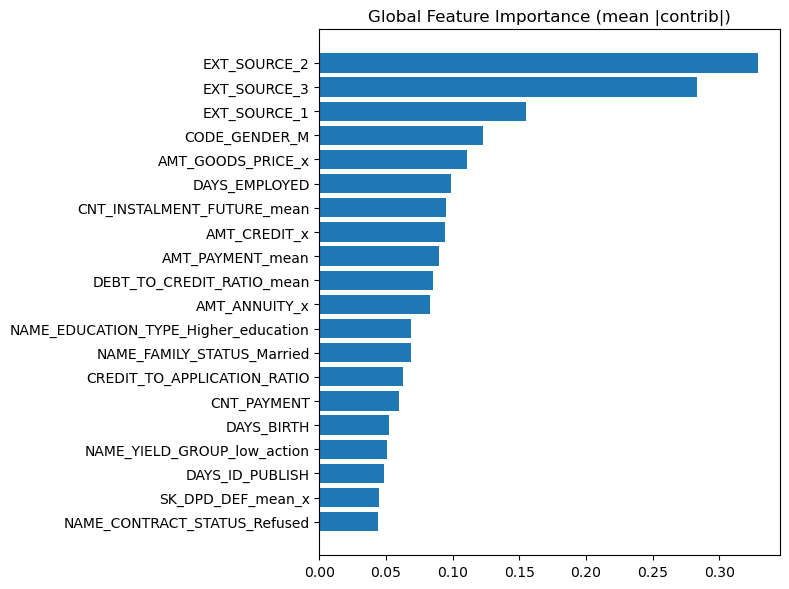

✅ Saved: shaplike_global_importance.csv

Local explanation for row 7320 (top 12 features):


feature          value  contribution
0                  EXT_SOURCE_2       0.000012      1.089117
1                  EXT_SOURCE_3       0.037119      1.042437
2   AMT_CREDIT_SUM_OVERDUE_mean   10977.375000      0.601784
3    OCCUPATION_TYPE_Core_staff       1.000000     -0.164457
4             AMT_GOODS_PRICE_x  450000.000000      0.154260
5              FLAG_DOCUMENT_18       1.000000     -0.134993
6               DAYS_ID_PUBLISH     -79.000000      0.132638
7                  AMT_CREDIT_x  545040.000000      0.111095
8                 DAYS_EMPLOYED    -856.000000      0.107329
9                  EXT_SOURCE_1       0.505998      0.106239
10           STATUS_1_mean_mean       0.195787      0.089965
11              LIVINGAREA_MEDI       0.074900      0.087115


Local explanation for row 4800 (top 12 features):


feature        value  contribution
0                           EXT_SOURCE_2     0.782033     -0.899533
1                       FLAG_DOCUMENT_13     1.000000     -0.473591
2   NAME_CONTRACT_TYPE_Revolving_loans_x     1.000000     -0.405104
3                           EXT_SOURCE_3     0.753067     -0.386547
4              CREDIT_TYPE_Car_loan_mean     0.666667     -0.269821
5                ORGANIZATION_TYPE_Hotel     1.000000     -0.251140
6   NAME_EDUCATION_TYPE_Higher_education     1.000000     -0.220492
7                          DAYS_EMPLOYED -4295.000000     -0.183506
8                            OWN_CAR_AGE     3.000000     -0.129724
9             NAME_FAMILY_STATUS_Married     1.000000     -0.124064
10           REGION_RATING_CLIENT_W_CITY     1.000000     -0.113618
11                         CODE_GENDER_M     1.000000      0.094489


Local explanation for row 29600 (top 12 features):


feature          value  contribution
0                    EXT_SOURCE_2       0.166653      0.676132
1                    AMT_CREDIT_x  201474.000000     -0.158032
2                 DAYS_ID_PUBLISH   -4995.000000     -0.138842
3     CREDIT_TO_APPLICATION_RATIO       1.128689      0.131199
4                   CODE_GENDER_M       0.000000     -0.129458
5                    EXT_SOURCE_1       0.505998      0.115566
6   NAME_GOODS_CATEGORY_Furniture       1.000000     -0.093131
7      NAME_FAMILY_STATUS_Married       0.000000      0.090583
8                      DAYS_BIRTH  -14213.000000      0.089268
9                AMT_PAYMENT_mean   14328.090000     -0.088918
10                   EXT_SOURCE_3       0.535276      0.087283
11              AMT_GOODS_PRICE_x  189000.000000      0.085242

✅ Saved local CSVs: highrisk/lowrisk/borderline


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Get SHAP-like contributions directly from LightGBM (n_features + bias term)
contrib_val = lgbm.booster_.predict(X_val, pred_contrib=True)  # shape: (n_samples, n_features+1)
feat_contrib = contrib_val[:, :-1]  # drop bias term
feat_names = X_val.columns

# 2) GLOBAL importance = mean(|contribution|)
mean_abs = np.abs(feat_contrib).mean(axis=0)
global_imp = pd.DataFrame({"feature": feat_names, "mean_abs_contrib": mean_abs}) \
               .sort_values("mean_abs_contrib", ascending=False)

# Plot top 20
top20 = global_imp.head(20)
plt.figure(figsize=(8,6))
plt.barh(top20["feature"][::-1], top20["mean_abs_contrib"][::-1])
plt.title("Global Feature Importance (mean |contrib|)")
plt.tight_layout()
plt.show()

# Save for report
#global_imp.to_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/shaplike_global_importance.csv", index=False)
print("✅ Saved: shaplike_global_importance.csv")

# 3) LOCAL explanations for selected cases
def show_local_explanation(i, k=10):
    row = feat_contrib[i]
    order = np.argsort(np.abs(row))[::-1][:k]
    df = pd.DataFrame({
        "feature": feat_names[order],
        "value": X_val.iloc[i, order].values,
        "contribution": row[order]
    })
    print(f"\nLocal explanation for row {i} (top {k} features):")
    display(df)
    return df

# Pick: high-risk, low-risk, and borderline
y_val_proba = lgbm.predict_proba(X_val)[:,1]
hi_i  = int(np.argmax(y_val_proba))
lo_i  = int(np.argmin(y_val_proba))
mid_i = int(np.argsort(np.abs(y_val_proba - 0.5))[0])

hi_df  = show_local_explanation(hi_i, k=12)
lo_df  = show_local_explanation(lo_i, k=12)
mid_df = show_local_explanation(mid_i, k=12)

#hi_df.to_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/local_explain_highrisk.csv", index=False)
#lo_df.to_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/local_explain_lowrisk.csv", index=False)
#mid_df.to_csv("/Users/bella/Downloads/Home credit /home-credit-default-risk/local_explain_borderline.csv", index=False)
print("✅ Saved local CSVs: highrisk/lowrisk/borderline")

Fairness — Demographic Parity, Equal Opportunity, False Positive Rate

In [10]:
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate
import numpy as np
import pandas as pd

# 1) Predictions from your LightGBM baseline
y_pred = (y_val_proba >= 0.5).astype(int)   # threshold = 0.5

# 2) Rebuild sensitive attributes from OHE (gender, age_group)
def reconstruct_from_ohe(df, prefix, base_label="BASE"):
    cols = [c for c in df.columns if c.startswith(prefix)]
    if not cols:
        return None
    sub = df[cols]
    labels = sub.idxmax(axis=1)                              # column name with the 1
    base_mask = (sub.sum(axis=1) == 0)                       # dropped category
    labels = labels.where(~base_mask, prefix + base_label)
    return labels.str.replace(prefix, "", regex=False)

gender_series = reconstruct_from_ohe(X_val, "CODE_GENDER_", base_label="(base)")
age_series    = reconstruct_from_ohe(X_val, "AGE_GROUP_",   base_label="(base)")

# If you didn’t keep AGE_GROUP OHE, you can fall back to binning YEARS_BIRTH:
if age_series is None and "YEARS_BIRTH" in X_val.columns:
    bins   = [20,30,40,50,60,70,120]
    labels = ["20-30","30-40","40-50","50-60","60-70","70+"]
    age_series = pd.cut(X_val["YEARS_BIRTH"], bins=bins, labels=labels, include_lowest=True)

# 3) Overall diagnostic (reference)
overall = {
    "selection_rate": selection_rate(y_val, y_pred),
    "tpr": true_positive_rate(y_val, y_pred),
    "fpr": false_positive_rate(y_val, y_pred)
}
print("Overall metrics:", overall)

# 4) Group fairness table + disparities
def fairness_report(name, sensitive_series):
    mf = MetricFrame(
        metrics={
            "selection_rate": selection_rate,
            "tpr": true_positive_rate,
            "fpr": false_positive_rate
        },
        y_true=y_val,
        y_pred=y_pred,
        sensitive_features=sensitive_series
    )
    print(f"\n=== Fairness by {name} ===")
    display(mf.by_group)

    # Disparities (max - min across groups)
    disp = mf.by_group.max() - mf.by_group.min()
    print("\nDisparity (max - min) across groups:")
    print(disp)

    # Quick “who’s disadvantaged”
    worst_tpr_group = mf.by_group["tpr"].idxmin()
    worst_fpr_group = mf.by_group["fpr"].idxmax()
    print(f"\nLower opportunity (TPR lowest): {worst_tpr_group}")
    print(f"Higher false alarms (FPR highest): {worst_fpr_group}")

    #mf.by_group.to_csv(f"/Users/bella/Downloads/Home credit /home-credit-default-risk/fairness_by_{name}.csv")
    print(f"✅ Saved: fairness_by_{name}.csv")

if gender_series is not None:
    fairness_report("gender", gender_series)

if age_series is not None:
    fairness_report("age_group", age_series)

Overall metrics: {'selection_rate': 0.26688129034356045, 'tpr': 0.6469284994964754, 'fpr': 0.2335066680816442}

=== Fairness by gender ===


selection_rate       tpr       fpr
sensitive_feature_0                                    
(base)                     0.221074  0.583216  0.193850
M                          0.355587  0.731799  0.313008
Missing                    0.500000  0.000000  0.500000


Disparity (max - min) across groups:
selection_rate    0.278926
tpr               0.731799
fpr               0.306150
dtype: float64

Lower opportunity (TPR lowest): Missing
Higher false alarms (FPR highest): Missing
✅ Saved: fairness_by_gender.csv

=== Fairness by age_group ===


selection_rate       tpr       fpr
sensitive_feature_0                                    
(base)                     0.442144  0.758929  0.401867
30_40                      0.329432  0.721343  0.287937
40_50                      0.244261  0.628670  0.212764
50_60                      0.179874  0.514484  0.157209
60_70                      0.118106  0.380952  0.104353


Disparity (max - min) across groups:
selection_rate    0.324038
tpr               0.377976
fpr               0.297514
dtype: float64

Lower opportunity (TPR lowest): 60_70
Higher false alarms (FPR highest): (base)
✅ Saved: fairness_by_age_group.csv


Bias Mitigation


A) Helpers — sensitive features, metrics, and comparison

In [11]:
import numpy as np
import pandas as pd
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

# Rebuild sensitive attributes from OHE (you used drop='first' and sanitized names)
def reconstruct_from_ohe(df, prefix, base_label="(base)"):
    cols = [c for c in df.columns if c.startswith(prefix)]
    if not cols:
        return None
    sub = df[cols]
    labels = sub.idxmax(axis=1)
    base_mask = sub.sum(axis=1) == 0
    labels = labels.where(~base_mask, prefix + base_label)
    return labels.str.replace(prefix, "", regex=False)

# Sensitive features on TRAIN and VAL (use what you actually have)
gender_train = reconstruct_from_ohe(X_train, "CODE_GENDER_")
gender_val   = reconstruct_from_ohe(X_val,   "CODE_GENDER_")

age_val = reconstruct_from_ohe(X_val, "AGE_GROUP_")
if age_val is None and "YEARS_BIRTH" in X_val.columns:
    age_val = pd.cut(X_val["YEARS_BIRTH"], bins=[20,30,40,50,60,70,120],
                     labels=["20-30","30-40","40-50","50-60","60-70","70+"], include_lowest=True)

def evaluate_all(name, y_true, y_proba, sensitive=None, threshold=0.5):
    y_hat = (y_proba >= threshold).astype(int)
    out = {
        "Model": name,
        "AUC": roc_auc_score(y_true, y_proba),
        "Accuracy": accuracy_score(y_true, y_hat),
        "Precision": precision_score(y_true, y_hat, zero_division=0),
        "Recall": recall_score(y_true, y_hat),
    }
    # fairness by sensitive feature
    if sensitive is not None:
        mf = MetricFrame(
            metrics={"selection_rate": selection_rate,
                     "tpr": true_positive_rate,
                     "fpr": false_positive_rate},
            y_true=y_true, y_pred=y_hat, sensitive_features=sensitive
        )
        disp = mf.by_group.max() - mf.by_group.min()
        out.update({
            "DP_disp": float((mf.by_group["selection_rate"].max() - mf.by_group["selection_rate"].min())),
            "TPR_disp": float(disp["tpr"]),
            "FPR_disp": float(disp["fpr"]),
        })
    return out

B) Baseline (for reference)

In [12]:
# Baseline LightGBM metrics & fairness (by gender if available)
baseline = evaluate_all("LGBM_baseline", y_val, y_val_proba, sensitive=gender_val, threshold=0.5)
pd.DataFrame([baseline])

Model       AUC  Accuracy  Precision    Recall   DP_disp  TPR_disp  \
0  LGBM_baseline  0.778116  0.756841   0.195687  0.646928  0.278926  0.731799   

   FPR_disp  
0   0.30615

C) Pre-processing — Reweighing (no external libs)

We’ll compute Kamiran–Calders-style weights:

In [13]:
def reweigh_labels(y, sensitive):
    df = pd.DataFrame({"y": y.astype(int).values, "a": sensitive.values})
    py = df["y"].value_counts(normalize=True)
    pa = df["a"].value_counts(normalize=True)
    pya = df.groupby(["y","a"]).size() / len(df)

    weights = {}
    for (yy, aa), p in pya.items():
        weights[(yy, aa)] = (py[yy] * pa[aa]) / p

    w = df.apply(lambda r: weights[(r["y"], r["a"])], axis=1).astype(float).values
    return w

# Build sample weights on TRAIN (use gender; you can swap to age if preferred)
if gender_train is not None:
    sample_w = reweigh_labels(y_train, gender_train)
else:
    sample_w = None
    print("No gender dummies found in X_train; skipping reweighing.")

# Train a reweighed LGBM
from lightgbm import LGBMClassifier
lgbm_rw = LGBMClassifier(
    n_estimators=600, learning_rate=0.05, num_leaves=31,
    class_weight=None, random_state=42
)
lgbm_rw.fit(X_train, y_train, sample_weight=sample_w)

# Evaluate
y_val_proba_rw = lgbm_rw.predict_proba(X_val)[:,1]
rw_metrics = evaluate_all("LGBM_reweighed", y_val, y_val_proba_rw, sensitive=gender_val, threshold=0.5)
pd.DataFrame([baseline, rw_metrics])

Model       AUC  Accuracy  Precision    Recall   DP_disp  \
0   LGBM_baseline  0.778116  0.756841   0.195687  0.646928  0.278926   
1  LGBM_reweighed  0.777005  0.919760   0.538660  0.042095  0.006435   

   TPR_disp  FPR_disp  
0  0.731799  0.306150  
1  0.045839  0.003472

D) In-processing — Fairlearn ExponentiatedGradient

We’ll constrain Equalized Odds (equal TPR/FPR across groups) with a simple base model (Logistic Regression) to avoid API quirks. You can also try Demographic Parity.

In [17]:
# ================= Pre-processing (Reweighing) =================
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier

# --- 0) Safety: make sure gender labels exist & aligned ---
if 'gender_train' not in globals() or gender_train is None:
    raise ValueError("gender_train is missing. Build it e.g. with reconstruct_from_ohe(X_train, 'CODE_GENDER_').")
if 'gender_val' not in globals() or gender_val is None:
    raise ValueError("gender_val is missing. Build it e.g. with reconstruct_from_ohe(X_val, 'CODE_GENDER_').")

gender_train_rw = pd.Series(gender_train).fillna("Unknown")
gender_val_rw   = pd.Series(gender_val).fillna("Unknown")

# --- 1) Reweighing function (Kamiran–Calders) ---
def reweigh_labels(y, sensitive):
    df = pd.DataFrame({"y": y.astype(int).values, "a": sensitive.values})
    py  = df["y"].value_counts(normalize=True)
    pa  = df["a"].value_counts(normalize=True)
    pya = df.groupby(["y","a"]).size().div(len(df))

    weights = {}
    for (yy, aa), p in pya.items():
        # w(y,a) = P(y) * P(a) / P(y,a)
        weights[(yy, aa)] = (py[yy] * pa[aa]) / p

    w = df.apply(lambda r: weights[(r["y"], r["a"])], axis=1).astype(float).values
    # Normalize weights to mean 1 (keeps scale tame)
    return w / np.mean(w)

sample_w = reweigh_labels(y_train, gender_train_rw)

# --- 2) Train a reweighed LightGBM (fast & robust) ---
lgbm_rw = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
lgbm_rw.fit(X_train, y_train, sample_weight=sample_w)

# --- 3) Evaluate on validation ---
y_val_proba_rw = lgbm_rw.predict_proba(X_val)[:, 1]
rw_metrics = evaluate_all(
    name="LGBM_Reweighed(gender)",
    y_true=y_val,
    y_proba=y_val_proba_rw,
    sensitive=gender_val_rw,
    threshold=0.5
)

# --- 4) Save/merge with your comparison CSV (same path as you used) ---
pre_rows = []
if 'baseline' in globals(): pre_rows.append(baseline)
pre_rows.append(rw_metrics)

pre_df = pd.DataFrame(pre_rows)
print(pre_df)

# If you want to append into your existing file:
save_path = "/Users/bella/Downloads/Home credit /home-credit-default-risk/week3_inprocessing_comparison.csv"
try:
    # If file already exists from in-processing, append unique rows on 'Model'
    existing = pd.read_csv(save_path)
    merged = pd.concat([existing, pre_df], ignore_index=True)\
               .drop_duplicates(subset=["Model"], keep="last")
    merged.to_csv(save_path, index=False)
    print(f"✅ Updated comparison CSV at: {save_path}")
except Exception as e:
    # First time: just write our pre_df
    pre_df.to_csv(save_path, index=False)
    print(f"✅ Wrote comparison CSV at: {save_path}")

                    Model       AUC  Accuracy  Precision    Recall   DP_disp  \
0           LGBM_baseline  0.778116  0.756841   0.195687  0.646928  0.278926   
1  LGBM_Reweighed(gender)  0.775844  0.919890   0.553073  0.039879  0.006139   

   TPR_disp  FPR_disp  
0  0.731799  0.306150  
1  0.042666  0.003393  
✅ Wrote comparison CSV at: /Users/bella/Downloads/Home credit /home-credit-default-risk/week3_inprocessing_comparison.csv


E) Post-processing — ThresholdOptimizer (group-wise thresholds)

In [20]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate

# ---- 0) Inputs assumed available ----
# lgbm (trained LightGBM sklearn API), X_val, y_val, y_val_proba = lgbm.predict_proba(X_val)[:,1]
# gender_val (Series reconstructed from OHE), baseline row 'baseline' optional

# ---- 1) Clean sensitive attr & detect degenerate/small groups ----
gender_val_pp = pd.Series(gender_val, index=X_val.index).fillna("Missing")

# Count by group and label
ct = pd.crosstab(gender_val_pp, y_val)
# groups with both classes present
valid_groups = ct[(ct.get(0, 0) > 0) & (ct.get(1, 0) > 0)].index.tolist()

# Optionally, merge very small groups into "Other" before checking degeneracy
min_count = 50  # tweak as needed
group_sizes = gender_val_pp.value_counts()
small_groups = group_sizes[group_sizes < min_count].index.tolist()

# Build a mapped sensitive attribute where small or degenerate groups => "Other"
def map_group(g):
    if g in small_groups or g not in valid_groups:
        return "Other"
    return g

gender_mapped = gender_val_pp.map(map_group)

# Recompute degeneracy after mapping
ct2 = pd.crosstab(gender_mapped, y_val)
valid_groups2 = ct2[(ct2.get(0, 0) > 0) & (ct2.get(1, 0) > 0)].index.tolist()

# Final mask for rows belonging to valid groups
mask_valid = gender_mapped.isin(valid_groups2)

# ---- 2) Fit ThresholdOptimizer on valid subset only ----
baseline_auc = roc_auc_score(y_val, y_val_proba)
constraint_name = "equalized_odds"  # or "demographic_parity"

topt = ThresholdOptimizer(
    estimator=lgbm,                 # prefit model
    constraints=constraint_name,    # 'equalized_odds' or 'demographic_parity'
    objective="accuracy_score",
    predict_method="predict_proba",
    prefit=True,
    grid_size=200,
    flip=False
)

# Fit on subset with non-degenerate groups
topt.fit(
    X_val[mask_valid], y_val[mask_valid],
    sensitive_features=gender_mapped[mask_valid]
)

# ---- 3) Build predictions on ALL rows:
# start with baseline (0.5 threshold), then overwrite valid rows with post-processed labels
y_hat_post = (y_val_proba >= 0.5).astype(int)  # fallback for invalid groups
y_hat_post_valid = topt.predict(
    X_val[mask_valid],
    sensitive_features=gender_mapped[mask_valid]
)
y_hat_post[mask_valid] = y_hat_post_valid

# ---- 4) Performance metrics (AUC unchanged by thresholding) ----
post_metrics = {
    "Model": f"LGBM_Postproc_{constraint_name}_safe",
    "AUC": float(baseline_auc),
    "Accuracy": accuracy_score(y_val, y_hat_post),
    "Precision": precision_score(y_val, y_hat_post, zero_division=0),
    "Recall": recall_score(y_val, y_hat_post),
}

# ---- 5) Fairness metrics on valid groups only (avoids degenerate groups) ----
mf_post = MetricFrame(
    metrics={"selection_rate": selection_rate,
             "tpr": true_positive_rate,
             "fpr": false_positive_rate},
    y_true=y_val[mask_valid],
    y_pred=y_hat_post[mask_valid],
    sensitive_features=gender_mapped[mask_valid]
)

post_metrics.update({
    "DP_disp": float(mf_post.by_group["selection_rate"].max() - mf_post.by_group["selection_rate"].min()),
    "TPR_disp": float(mf_post.by_group["tpr"].max() - mf_post.by_group["tpr"].min()),
    "FPR_disp": float(mf_post.by_group["fpr"].max() - mf_post.by_group["fpr"].min()),
})

# ---- 6) Save/compare ----
rows = []
for name in ["baseline", "rw_metrics", "eo_metrics", "dp_metrics"]:
    if name in globals():
        rows.append(globals()[name])
rows.append(post_metrics)

comparison_post = pd.DataFrame(rows)
comparison_post.to_csv(
    "/Users/bella/Downloads/Home credit /home-credit-default-risk/week3_postprocessing_comparison.csv",
    index=False
)
comparison_post

Model       AUC  Accuracy  Precision    Recall  \
0                      LGBM_baseline  0.778116  0.756841   0.195687  0.646928   
1             LGBM_Reweighed(gender)  0.775844  0.919890   0.553073  0.039879   
2  LGBM_Postproc_equalized_odds_safe  0.778116  0.919126   0.492437  0.059013   

    DP_disp  TPR_disp  FPR_disp  
0  0.278926  0.731799  0.306150  
1  0.006139  0.042666  0.003393  
2  0.001286  0.000297  0.000490

F) Compare & Save

In [23]:
rows = []
for name in ["baseline", "rw_metrics", "eo_metrics", "dp_metrics", "post_metrics"]:
    if name in globals():
        rows.append(globals()[name])

results = pd.DataFrame(rows)
results.to_csv(
    "/Users/bella/Downloads/Home credit /home-credit-default-risk/week3_mitigation_comparison.csv",
    index=False
)